In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Target Spectra

freq_true.shape (1003,)
R_true.shape (201,)


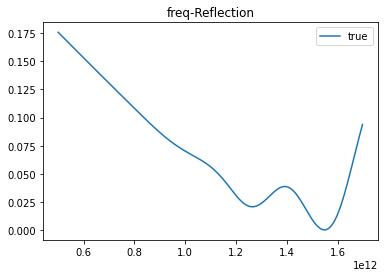

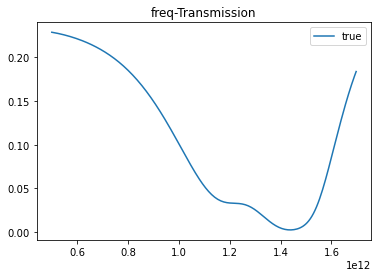

1098
(222,)
idx_freq_tg1 ORIG: 151
idx_freq_tg1: 166.77611940298507
R_tg1: 0.038314723405216806
T_tg1: 0.004280525157849011
T_tg2: 0.22840801357720697
--------
idx_freq_tg2 ORIG: 117
idx_freq_tg2: 129.22388059701493
R_tg2: 0.03066116289643781


In [4]:
path_true_R = './Simple_RCWA/data/R_absorber.txt'
R_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_R)
freq_true = R_file[:, 0] * 1e12
R_true = R_file[:, 1]
R_true = R_true**2
print('freq_true.shape', freq_true.shape)
# print(R_true)

path_true_T = './Simple_RCWA/data/T_absorber.txt'
T_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_T)
T_true = T_file[:, 1]
T_true = T_true**2

# truncate freq
freq_truncate = 1.7  # in THz
N_freq_stop = np.argmax(R_file[:,0]>freq_truncate)
freq_true = freq_true[:N_freq_stop]
R_true = R_true[:N_freq_stop]
T_true = T_true[:N_freq_stop]
freq_step = 4
freq_true, R_true, T_true = freq_true[::freq_step], R_true[::freq_step], T_true[::freq_step]
print('R_true.shape', R_true.shape)

plt.figure(1)
plt.plot(freq_true, R_true, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq_true, T_true, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
print(eps_absorber_file.shape[0])
# truncate freq over 1.7THz
# freq_truncate = 1.7  # in THz
# freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12
print(freq.shape)


# ================== Get Target Spectra Value
# print(freq_true)
idx_freq_tg1 = np.min(np.argwhere(freq_true>=1.4*1e12))
print('idx_freq_tg1 ORIG:', idx_freq_tg1)
R_tg1 = R_true[idx_freq_tg1]
T_tg1 = T_true[idx_freq_tg1]
T_tg2 = T_true[0]

idx_freq_tg1 = idx_freq_tg1/201*222
print('idx_freq_tg1:', idx_freq_tg1)
print('R_tg1:', R_tg1)
print('T_tg1:', T_tg1)
print('T_tg2:', T_tg2)


print('--------')
idx_freq_tg2 = np.min(np.argwhere(freq_true>=1.2*1e12))
print('idx_freq_tg2 ORIG:', idx_freq_tg2)
R_tg2 = R_true[idx_freq_tg2]

idx_freq_tg2 = idx_freq_tg2/201*222
print('idx_freq_tg2:', idx_freq_tg2)
print('R_tg2:', R_tg2)

# Looping to generate data and training

In [5]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(params_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [80. 80.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [80. 79.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [130.  93.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 73. 136.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [108. 114.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [92. 73.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [87. 90.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [84. 63.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [102.  85.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [56. 95.]
Calculation Progress: 100%
-----------

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [94. 56.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [101.  78.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [123.  74.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [130.  55.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [61. 63.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [119. 102.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 55. 122.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 86. 134.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [149.  89.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 97. 115.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 58. 128.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [63. 69.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.0013458799121508491
### TEST LOSS  0.00047874969701903564
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.0007278976254201553
### TEST LOSS  0.00043561621957148117
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 0.0004650250119266275
### TEST LOSS  0.0005983028871317705
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.0004035976207251224
### TEST LOSS  0.00021317180168504515
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.000267815678507759
### TEST LOSS  0.0007574810103202859
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 0.0003286562380253599
### TEST LOSS  0.00012071149588640158
----------------------------------------------------------------------
**

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.8455980131761863e-05
### TEST LOSS  2.5236467384578038e-05
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 3.0125834717864565e-05
### TEST LOSS  4.766159084586737e-05
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 4.869444130235934e-05
### TEST LOSS  1.4349291329078065e-05
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.3499064625648316e-05
### TEST LOSS  1.5949790091932908e-05
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.8633727660812836e-05
### TEST LOSS  3.655897671706043e-05
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.2998879228689474e-05
### TEST LOSS  8.978366319449075e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.3593555282275248e-06
### TEST LOSS  2.736829098163677e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 3.060141097250835e-06
### TEST LOSS  5.2539561086935764e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 2.677486929769657e-06
### TEST LOSS  1.6359131222998258e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.9903580751190476e-06
### TEST LOSS  2.3949517071741866e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.962457635897863e-06
### TEST LOSS  2.391369738082479e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.7753257819208557e-06
### TEST LOSS  1.3725884097463374e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.165460949934527e-06
### TEST LOSS  1.335887153193956e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.3844026913290009e-06
### TEST LOSS  1.7186142334442895e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.3679316020898113e-06
### TEST LOSS  2.1402347556431778e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 1.1961996497689143e-06
### TEST LOSS  7.549210939335657e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.0831727238524992e-06
### TEST LOSS  1.4569219122980333e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 4.277597347481787e-06
### TEST LOSS  2.4892750237389314e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.652640260185194e-07
### TEST LOSS  5.313931789411678e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.492131709734395e-07
### TEST LOSS  4.4494145375513955e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.1976804816526965e-06
### TEST LOSS  1.0330460327168112e-06
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 7.011803956658013e-07
### TEST LOSS  5.095186187039266e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.752846179518656e-07
### TEST LOSS  5.792180862348081e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.721452271245652e-07
### TEST LOSS  4.7593572579292715e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.284825130047465e-07
### TEST LOSS  4.393275313911242e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.2549863565000124e-07
### TEST LOSS  5.52516913406483e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.193682896020846e-07
### TEST LOSS  3.736207077054132e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.849632714927111e-07
### TEST LOSS  5.313466904984429e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.568286143997625e-07
### TEST LOSS  5.663290304861827e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.464525451870373e-07
### TEST LOSS  3.502419095487615e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.9343677052272594e-07
### TEST LOSS  3.3419477555677685e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.8139547701376843e-07
### TEST LOSS  2.982179410082608e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.0339104639741663e-07
### TEST LOSS  6.223951155940691e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.5576319010365293e-07
### TEST LOSS  3.311744004956078e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.482338042104516e-07
### TEST LOSS  4.0901878151089477e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.7421434729623114e-07
### TEST LOSS  3.03600131701387e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.4633033649432716e-07
### TEST LOSS  3.6025078505493485e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.640154016792962e-07
### TEST LOSS  3.0229582156001317e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.78563173444968e-07
### TEST LOSS  4.693175412739947e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.824670562480037e-07
### TEST LOSS  3.308144300717686e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.489328044992135e-07
### TEST LOSS  2.8144799557594524e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 2.7619014314694823e-07
### TEST LOSS  3.0935922268326976e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.741407040891431e-07
### TEST LOSS  5.750544384378978e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.7286385772716813e-07
### TEST LOSS  2.970908496990887e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.2754414171165534e-07
### TEST LOSS  2.5186764200194983e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.7088716265666334e-07
### TEST LOSS  2.609336320347211e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.768816844067601e-07
### TEST LOSS  2.2525184325180211e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.783581432552751e-07
### TEST LOSS  4.020462635404935e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.841042362357939e-07
### TEST LOSS  3.7162319207103184e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.1842414124128025e-07
### TEST LOSS  2.5282322250556416e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.018314510112475e-07
### TEST LOSS  2.4970071403155697e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.273325022234985e-07
### TEST LOSS  2.583760666160136e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.837172775826957e-07
### TEST LOSS  2.7655252665681473e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.5336266485330725e-07
### TEST LOSS  9.880885727397981e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.505039066846848e-07
### TEST LOSS  2.17247740389818e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.561582377287209e-07
### TEST LOSS  6.513086911278757e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.0032364779941643e-07
### TEST LOSS  2.65551714543714e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.385907414037547e-07
### TEST LOSS  1.9650058883750413e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 2.8410899028941116e-07
### TEST LOSS  3.0872657437915524e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.528480880314987e-07
### TEST LOSS  2.6223634108646365e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 1.7274445839987607e-07
### TEST LOSS  1.635205109096205e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.6740016579651637e-07
### TEST LOSS  3.345852235270286e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.500186267935135e-07
### TEST LOSS  2.0014963316346743e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.9471556588944737e-07
### TEST LOSS  2.006739900177005e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 2.2064227019669148e-07
### TEST LOSS  3.0016165434669045e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 2.1171494061889006e-07
### TEST LOSS  1.5393650680077067e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.01928302239196e-07
### TEST LOSS  1.406833263217777e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 1.873363332904887e-07
### TEST LOSS  1.733330018775329e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.7212650547548946e-07
### TEST LOSS  1.464509272371591e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 1.776579297896319e-07
### TEST LOSS  2.9650979627149354e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.4935617405574816e-07
### TEST LOSS  1.4267022171073526e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.487807128837005e-07
### TEST LOSS  1.4966296409587207e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 1.6122951278063623e-07
### TEST LOSS  1.9384038788909189e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 1.5978401771477024e-07
### TEST LOSS  1.672143478496461e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 1.670102101769544e-07
### TEST LOSS  1.3449388092112713e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 1.4716963384842074e-07
### TEST LOSS  1.2048055234951485e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 1.4622791707274985e-07
### TEST LOSS  1.696232772019357e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 1.9703003896864858e-07
### TEST LOSS  3.3715071860266715e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 1.5305263062259655e-07
### TEST LOSS  2.8478899594119866e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 1.9693085567595858e-07
### TEST LOSS  1.8707307939772969e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.1116892719774683e-07
### TEST LOSS  1.8568946795009347e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.5218369678725597e-07
### TEST LOSS  1.9582386319901465e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 1.8457595523102556e-07
### TEST LOSS  1.1976010938496984e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 1.9659244422598475e-07
### TEST LOSS  3.306161223311695e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 1.4527173988199138e-07
### TEST LOSS  1.0831256247456622e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 1.8269675251758598e-07
### TEST LOSS  2.3604673060617642e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.6174073580899062e-07
### TEST LOSS  1.5677351920354946e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.4261811550397852e-07
### TEST LOSS  1.2246092495615812e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 1.4934197129612414e-07
### TEST LOSS  1.3056882390098204e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 1.4907978554745682e-07
### TEST LOSS  1.0460861687988654e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 1.2163398064757302e-07
### TEST LOSS  1.424266097653041e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 1.4426503253339717e-07
### TEST LOSS  1.430155739020241e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 1.2456839382224416e-07
### TEST LOSS  1.1985891272085306e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 1.1643009441897333e-07
### TEST LOSS  1.3483372166926225e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 1.4282677110344366e-07
### TEST LOSS  1.2623952727608412e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 1.3494347175679877e-07
### TEST LOSS  1.2867271455737259e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 1.560913353149118e-07
### TEST LOSS  1.0203429923194562e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 1.2700639956619852e-07
### TEST LOSS  9.56756333418222e-08
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 1.4011430318205954e-07
### TEST LOSS  1.7710668013630007e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.4424481763697373e-07
### TEST LOSS  1.3070737736597948e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 1.4332634173719328e-07
### TEST LOSS  1.1983936095324074e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 1.297195542049323e-07
### TEST LOSS  1.1213119440374915e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 1.4694477417975804e-07
### TEST LOSS  1.014532363304473e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.5738766302675343e-07
### TEST LOSS  1.2906131985346292e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.5503961860119374e-07
### TEST LOSS  1.3159198649267031e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 1.42258614994617e-07
### TEST LOSS  9.547690874948482e-08
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 1.3847932882171675e-07
### TEST LOSS  1.9967663907512664e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 1.5774216484132352e-07
### TEST LOSS  1.4700596295824653e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.423196055938547e-07
### TEST LOSS  1.5073319540685284e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.4163000443545571e-07
### TEST LOSS  1.264765951229189e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.2351455609405092e-07
### TEST LOSS  9.407119231733911e-08
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 1.3530571307818207e-07
### TEST LOSS  1.7018820130942913e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.2084696120749926e-07
### TEST LOSS  9.104674063564744e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.9992119896959936e-07
### TEST LOSS  3.1033604367773176e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 1.0784013935616344e-07
### TEST LOSS  8.754151300157294e-08
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.177073995428657e-07
### TEST LOSS  9.43195364773904e-08
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 1.0394084299925055e-07
### TEST LOSS  1.4783037253588796e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.992323476951441e-07
### TEST LOSS  1.426515794378247e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.1835995220366157e-07
### TEST LOSS  8.920022764868918e-08
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 1.09710912434835e-07
### TEST LOSS  1.1633242517442947e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 1.237880204385533e-07
### TEST LOSS  1.8823208354964058e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 1.6751498185918479e-07
### TEST LOSS  2.0943601934201675e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 1.4211129804486688e-07
### TEST LOSS  2.635801384561394e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 1.8556996814744763e-07
### TEST LOSS  1.344738933539702e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.6536474564409216e-07
### TEST LOSS  1.0914500829054911e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 1.2651038264976932e-07
### TEST LOSS  1.0963704018725669e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 1.6015261807389437e-07
### TEST LOSS  8.862775994581777e-08
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 1.1435498526779498e-07
### TEST LOSS  1.1843379373506953e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 1.1292603240065091e-07
### TEST LOSS  9.90991064024153e-08
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 1.7897175911052443e-07
### TEST LOSS  1.962843943677702e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.4301728969989825e-07
### TEST LOSS  8.336229958179804e-08
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 1.6539510703239557e-07
### TEST LOSS  8.886719863691421e-08
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 1.185507570200528e-07
### TEST LOSS  9.185342264572682e-08
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 9.276539409519557e-08
### TEST LOSS  9.89593402778155e-08
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 1.0477944140774297e-07
### TEST LOSS  9.990099177533314e-08
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 9.98965141540964e-08
### TEST LOSS  1.305150002887482e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 9.842996544939809e-08
### TEST LOSS  1.1112383191402841e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 8.894415512550324e-08
### TEST LOSS  1.349655865586404e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 9.644409563414059e-08
### TEST LOSS  1.1413129878216448e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.12463164727572e-07
### TEST LOSS  8.565343752782913e-08
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 1.1630080298807854e-07
### TEST LOSS  1.569948769504966e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.3537046307021682e-07
### TEST LOSS  1.0973903386002348e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 1.1573105413553719e-07
### TEST LOSS  7.864956330649875e-08
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 1.2025648562286052e-07
### TEST LOSS  1.0917611585152069e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.498147605261124e-07
### TEST LOSS  1.1242666175803606e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.2093407000257628e-07
### TEST LOSS  7.047370568595095e-08
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.0359670623572015e-07
### TEST LOSS  1.9685640495481493e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 1.1286411925937045e-07
### TEST LOSS  7.97866685312935e-08
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 1.2412797842920042e-07
### TEST LOSS  9.131338411331551e-08
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 1.0870212898694832e-07
### TEST LOSS  8.46237024158351e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 9.210079929822256e-08
### TEST LOSS  7.330017837148262e-08
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 8.575382712816548e-08
### TEST LOSS  7.407894031530304e-08
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 9.168700694228704e-08
### TEST LOSS  8.614737367906855e-08
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.433479095158674e-07
### TEST LOSS  1.0502774472342935e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 9.704996232429153e-08
### TEST LOSS  1.0056648373317027e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.3705358377968935e-07
### TEST LOSS  1.218460094302524e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 1.0870769456161611e-07
### TEST LOSS  7.288969428032033e-08
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 8.348484636933051e-08
### TEST LOSS  7.155570358463592e-08
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.4146512621771024e-07
### TEST LOSS  1.612609139556298e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.4533827983775892e-07
### TEST LOSS  1.0210760829446978e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 1.1038181352951425e-07
### TEST LOSS  7.427930389288424e-08
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 8.850028219598017e-08
### TEST LOSS  8.177739374559678e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 1.0343601595241835e-07
### TEST LOSS  7.591406377590222e-08
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 9.909042396394341e-08
### TEST LOSS  8.867776794356057e-08
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 9.449256509697079e-08
### TEST LOSS  1.0773161089142984e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 1.0438866389073098e-07
### TEST LOSS  8.818216201689211e-08
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.0564967380943813e-07
### TEST LOSS  8.669635794452309e-08
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 8.834571059601615e-08
### TEST LOSS  8.9837916069276e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 8.082678587761904e-08
### TEST LOSS  9.53679636002865e-08
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 9.92135508637304e-08
### TEST LOSS  6.95714703624617e-08
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.0840126563937958e-07
### TEST LOSS  1.6206394093387644e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.1825631825335137e-07
### TEST LOSS  1.0667642887559244e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.3953479412798232e-07
### TEST LOSS  1.0055455608911264e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 1.2125023959974612e-07
### TEST LOSS  9.59727775769655e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 9.268185890309866e-08
### TEST LOSS  7.901288749205075e-08
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 7.900557299045374e-08
### TEST LOSS  8.079709109172957e-08
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 8.635778594445754e-08
### TEST LOSS  6.604867763826405e-08
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 7.689794685461493e-08
### TEST LOSS  7.148519169201488e-08
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 8.218096158696398e-08
### TEST LOSS  1.135053651069029e-07
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 1.225102088930896e-07
### TEST LOSS  6.179090306090984e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.6748343239392228e-07
### TEST LOSS  1.078540871427928e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 9.379056573610711e-08
### TEST LOSS  7.976130215562686e-08
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.060386531781532e-07
### TEST LOSS  1.2710407304439286e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 1.0103648232284712e-07
### TEST LOSS  7.595219623605469e-08
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 1.057804968951359e-07
### TEST LOSS  7.405350051688704e-08
----------------------------------------------------------------------
*** EPOCH 1640 || AVG LOSS 1.4908574980765365e-07
### TEST LOSS  5.7829427172843374e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.0959008970523599e-07
### TEST LOSS  7.28824431917019e-08
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 7.781435895637401e-08
### TEST LOSS  6.00230076012546e-08
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 7.217087006239353e-08
### TEST LOSS  8.108522801345923e-08
----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 8.567543301918335e-08
### TEST LOSS  1.0235295633265196e-07
----------------------------------------------------------------------
*** EPOCH 1692 || AVG LOSS 1.3704534833181013e-07
### TEST LOSS  9.380989022626333e-08
----------------------------------------------------------------------
*** EPOCH 1693 || AVG LOSS 7.993026213348742e-08
### TEST LOSS  9.23866139146412e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.0995246171319196e-07
### TEST LOSS  1.4886184374063305e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 1.8089209405047768e-07
### TEST LOSS  7.484625067869881e-08
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 7.881625923467084e-08
### TEST LOSS  8.293586262198005e-08
----------------------------------------------------------------------
*** EPOCH 1744 || AVG LOSS 8.27713967588295e-08
### TEST LOSS  1.1255514683246777e-07
----------------------------------------------------------------------
*** EPOCH 1745 || AVG LOSS 6.903726863960457e-08
### TEST LOSS  7.552236051348397e-08
----------------------------------------------------------------------
*** EPOCH 1746 || AVG LOSS 1.0745321219030046e-07
### TEST LOSS  1.4679569441492882e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 7.801759415171361e-08
### TEST LOSS  5.546272892805367e-08
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 6.974531415071539e-08
### TEST LOSS  6.29834945679401e-08
----------------------------------------------------------------------
*** EPOCH 1796 || AVG LOSS 6.749834473351868e-08
### TEST LOSS  6.278837124303512e-08
----------------------------------------------------------------------
*** EPOCH 1797 || AVG LOSS 6.484230801184765e-08
### TEST LOSS  6.514949172734912e-08
----------------------------------------------------------------------
*** EPOCH 1798 || AVG LOSS 8.654467364976881e-08
### TEST LOSS  7.323937959805941e-08
----------------------------------------------------------------------
*** EPOCH 1799 || AVG LOSS 8.709469575762796e-08
### TEST LOSS  7.909234985466658e-08
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 3.1277517217986886e-07
### TEST LOSS  2.1647425777852428e-07
----------------------------------------------------------------------
*** EPOCH 1848 || AVG LOSS 1.1570401402316577e-07
### TEST LOSS  9.214169457057626e-08
----------------------------------------------------------------------
*** EPOCH 1849 || AVG LOSS 9.216193891159463e-08
### TEST LOSS  8.017472197252573e-08
----------------------------------------------------------------------
*** EPOCH 1850 || AVG LOSS 8.881687580508667e-08
### TEST LOSS  8.782648327117688e-08
----------------------------------------------------------------------
*** EPOCH 1851 || AVG LOSS 7.73716372526323e-08
### TEST LOSS  6.896583689316078e-08
----------------------------------------------------------------------
*** EPOCH 1852 || AVG LOSS 9.787566538577153e-08
### TEST LOSS  6.437111466084389e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1900 || AVG LOSS 8.057911600634071e-08
### TEST LOSS  6.648225555257643e-08
----------------------------------------------------------------------
*** EPOCH 1901 || AVG LOSS 8.467978582782365e-08
### TEST LOSS  9.150033501252135e-08
----------------------------------------------------------------------
*** EPOCH 1902 || AVG LOSS 1.0874334914312556e-07
### TEST LOSS  1.1047972729253767e-07
----------------------------------------------------------------------
*** EPOCH 1903 || AVG LOSS 8.894806151626966e-08
### TEST LOSS  9.477559596386224e-08
----------------------------------------------------------------------
*** EPOCH 1904 || AVG LOSS 8.796465147398181e-08
### TEST LOSS  7.602428079659755e-08
----------------------------------------------------------------------
*** EPOCH 1905 || AVG LOSS 7.820571093386519e-08
### TEST LOSS  6.192368928736869e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1953 || AVG LOSS 6.985056610009365e-08
### TEST LOSS  5.2951167598772976e-08
----------------------------------------------------------------------
*** EPOCH 1954 || AVG LOSS 9.921342205121419e-08
### TEST LOSS  8.255881548772474e-08
----------------------------------------------------------------------
*** EPOCH 1955 || AVG LOSS 8.83415205654714e-08
### TEST LOSS  9.339944047799993e-08
----------------------------------------------------------------------
*** EPOCH 1956 || AVG LOSS 9.88555239445077e-08
### TEST LOSS  8.167723090461247e-08
----------------------------------------------------------------------
*** EPOCH 1957 || AVG LOSS 8.710251863774943e-08
### TEST LOSS  8.688770947173907e-08
----------------------------------------------------------------------
*** EPOCH 1958 || AVG LOSS 7.258398639242713e-08
### TEST LOSS  8.176749588528764e-08
-----------------------------------------------------------

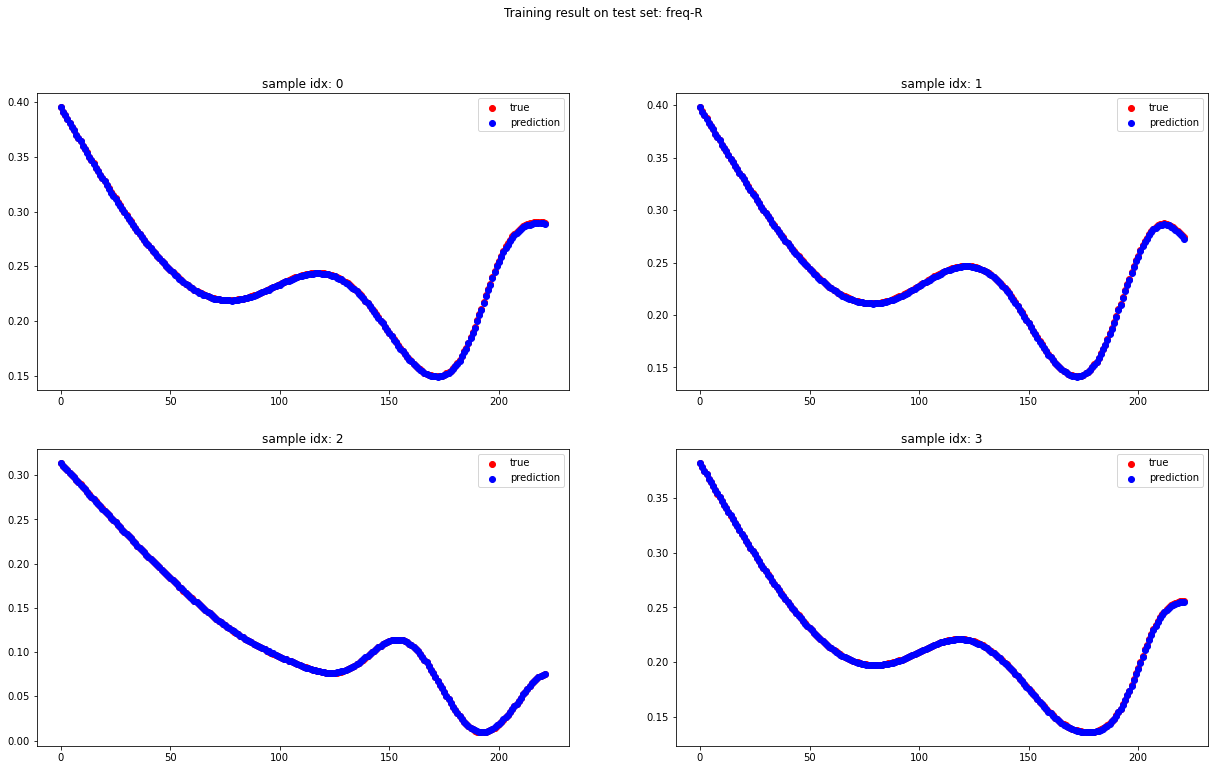

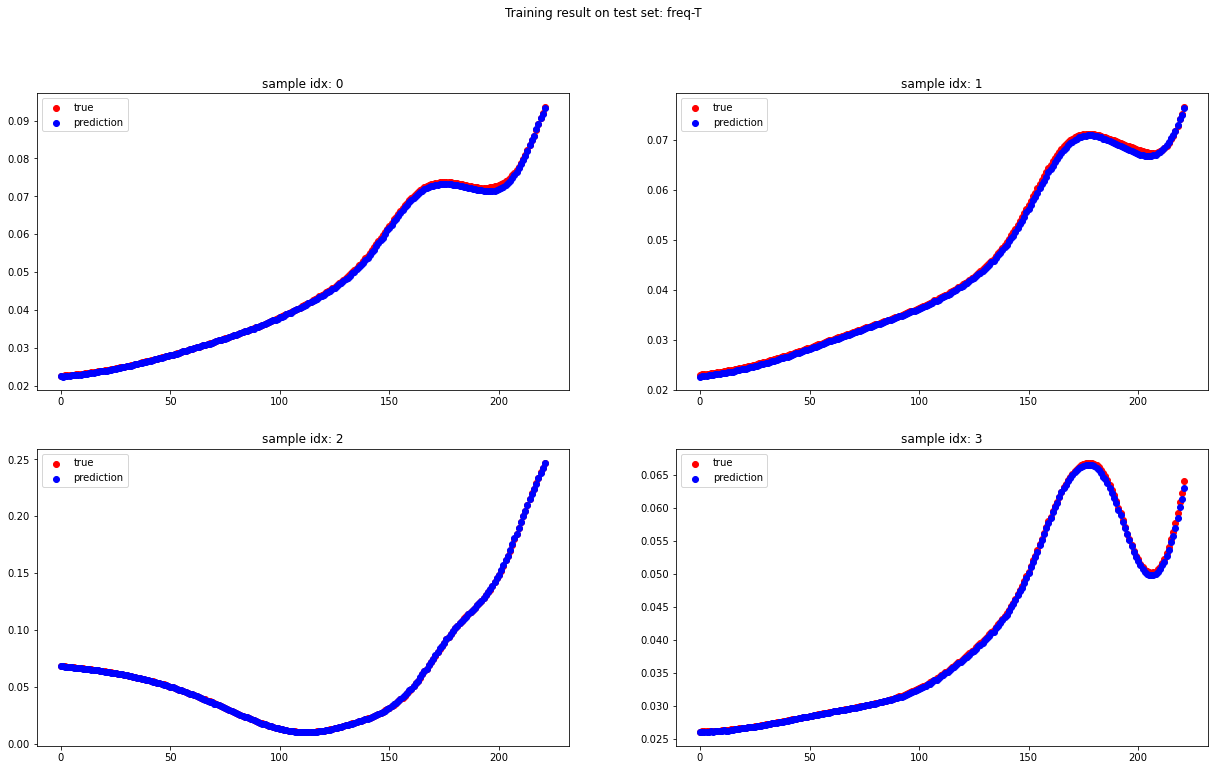

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 123. 160.  75.]
 [147. 123. 160.  75.]
 [145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [146. 121. 160.  75.]
 [146. 124. 160.  75.]
 [145. 120. 160.  75.]
 [145. 123. 160.  75.]
 [147. 122. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


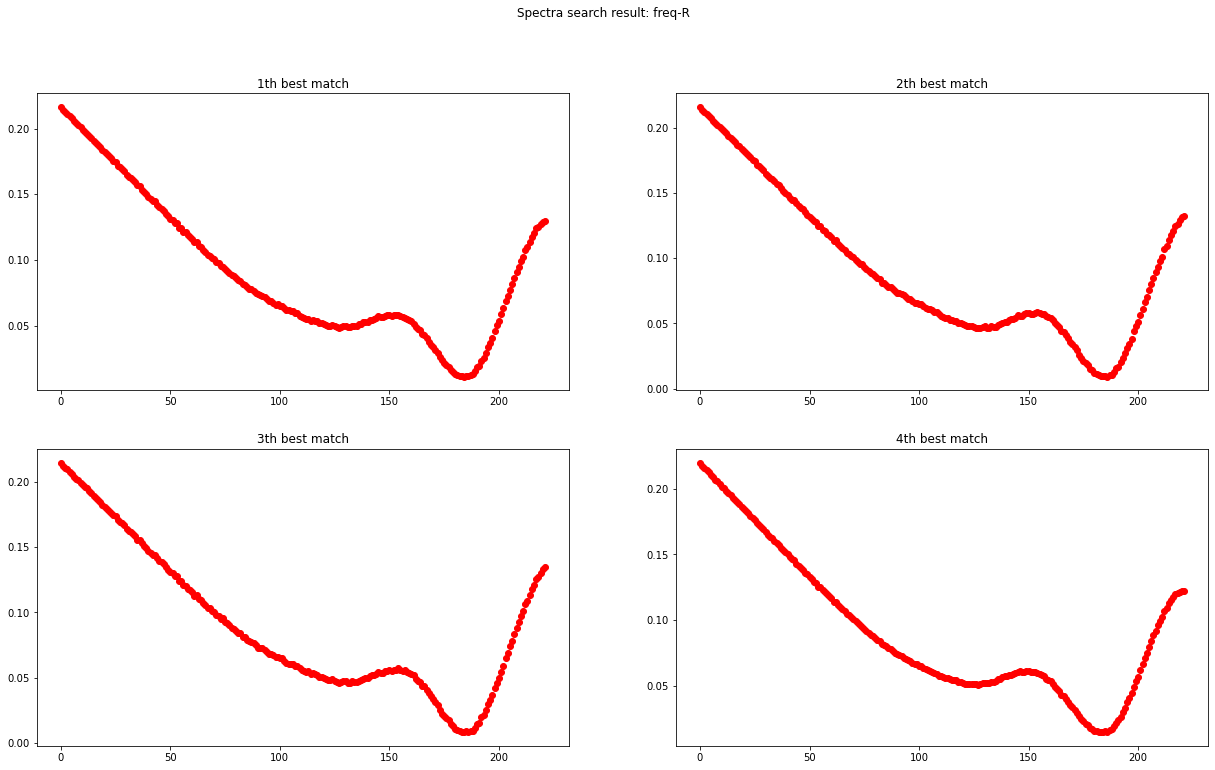

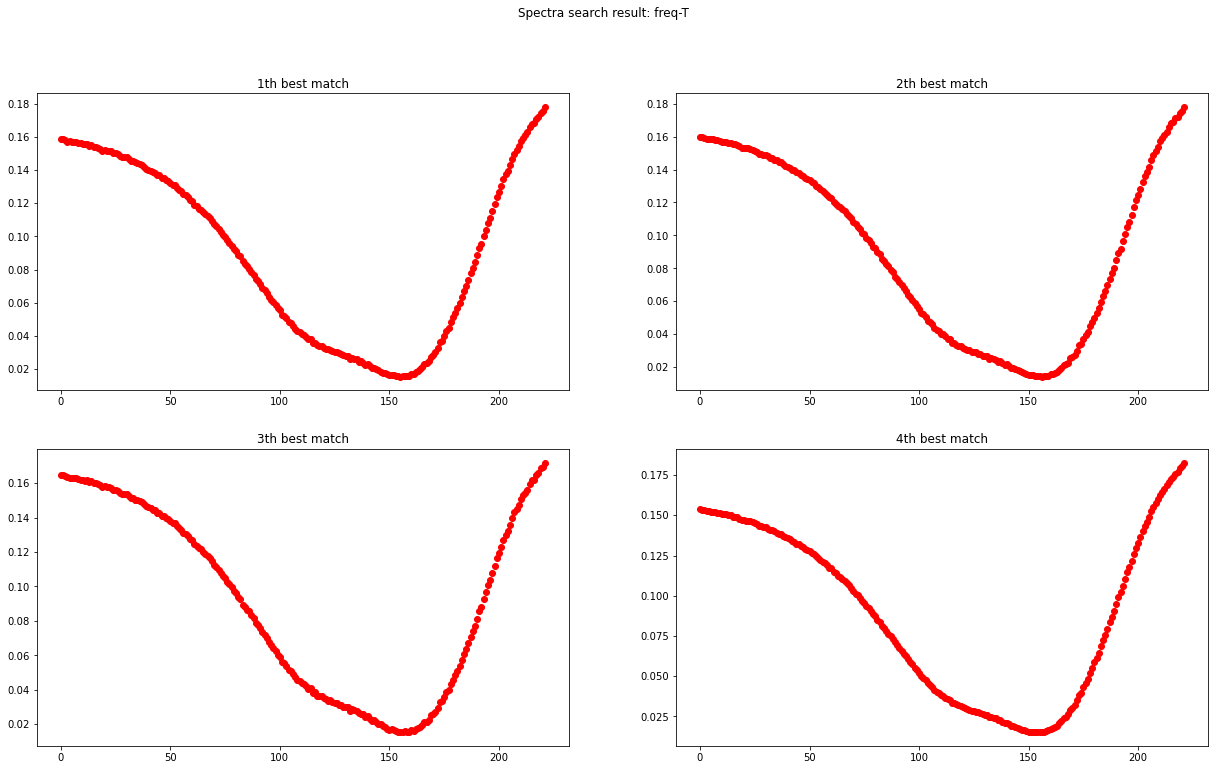

*** Reruning RCWA on picked params
params_dict.shape: (200, 4)
R_dict.shape: (200, 222)
T_dict.shape: (200, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [146. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [146. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [147. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [145. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [145. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6

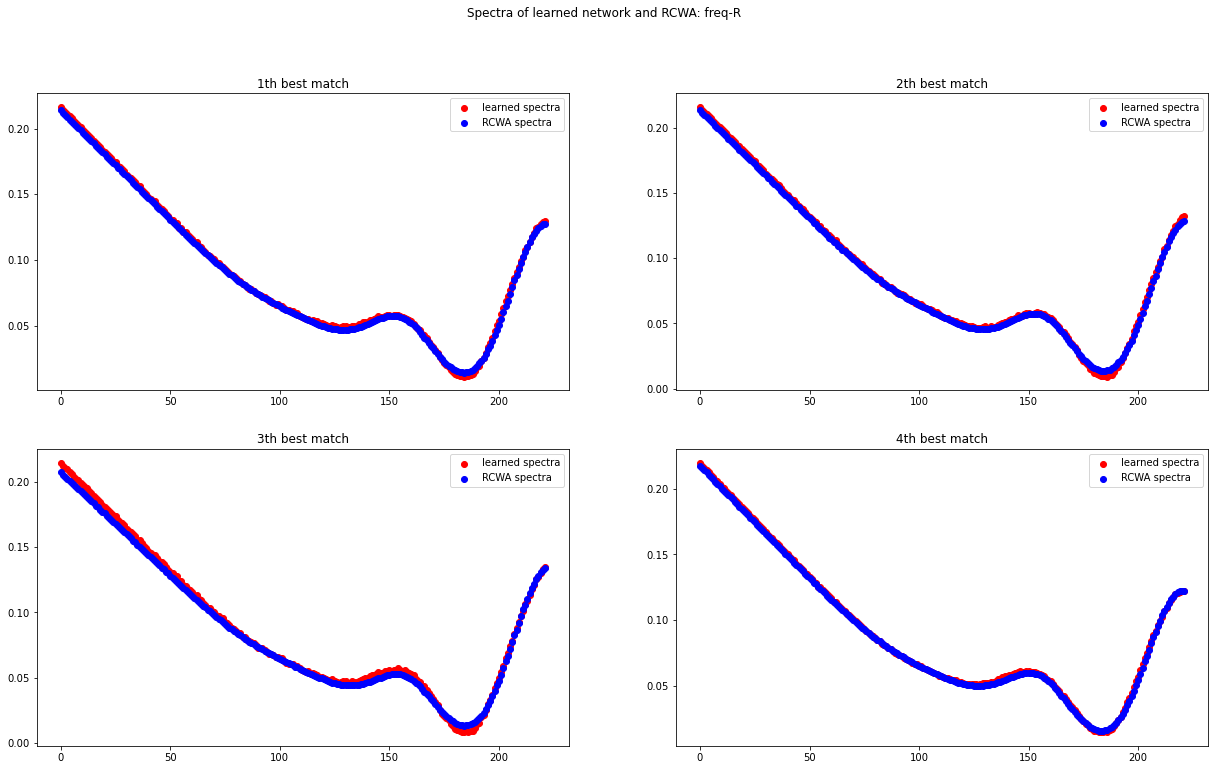

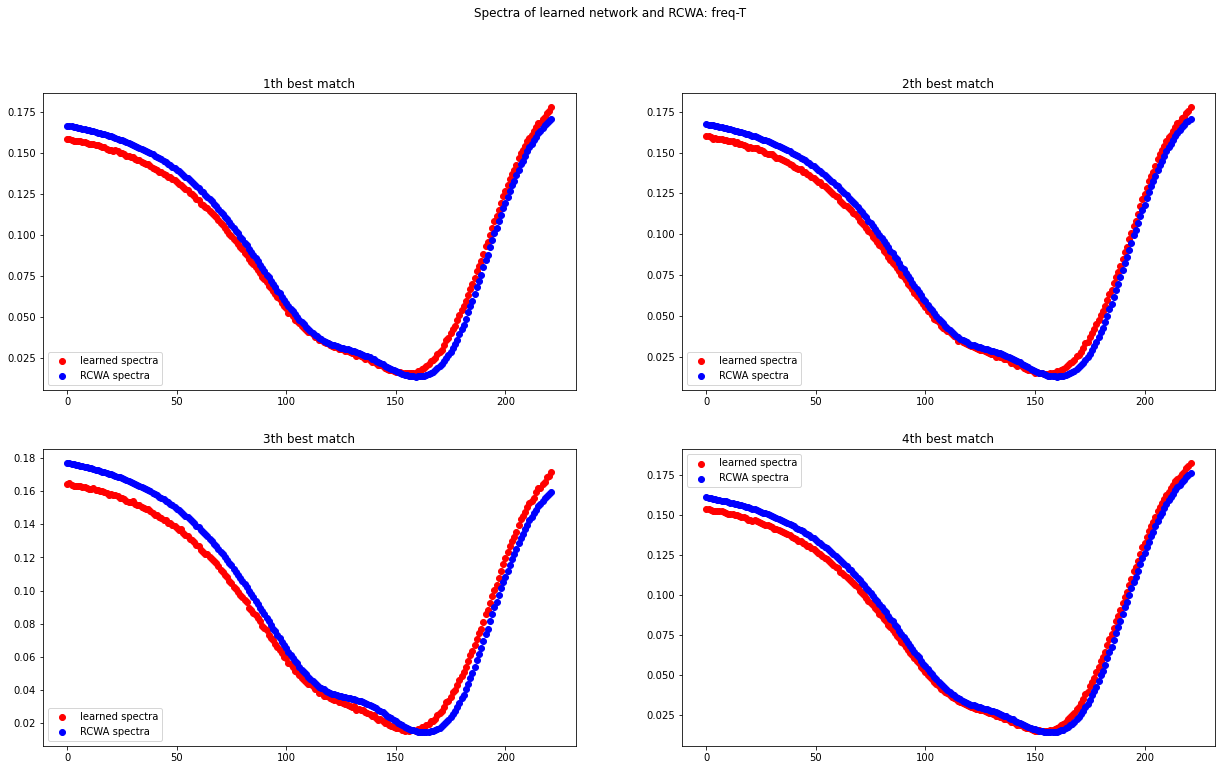

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 400
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [ 91. 111.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [140. 112.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [96. 84.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [54. 78.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [146.  75.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [101.  97.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [146.  60.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [146. 112.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [119.  95.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 72. 119.]
Calculation Pr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [106. 114.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [109.  54.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 68. 112.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [98. 54.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [97. 60.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [102. 131.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 73. 129.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [77. 72.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [143. 118.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 99. 105.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 79. 123.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [55. 99.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00044535563854879
### TEST LOSS  0.0006640635644240925
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.00016693736871843613
### TEST LOSS  9.25917969046471e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 7.33515985757549e-05
### TEST LOSS  8.587871828543332e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 6.84183533525129e-05
### TEST LOSS  6.0942939550538235e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 6.024519502943804e-05
### TEST LOSS  0.00013188712546252646
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 8.081176535029044e-05
### TEST LOSS  0.00010142981166912553
----------------------------------------------------------------------
*** EP

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 3.776230688785631e-06
### TEST LOSS  3.2914540118630007e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 4.523693434563825e-06
### TEST LOSS  6.3814914028625935e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.6021844780359517e-05
### TEST LOSS  1.3384433562653916e-05
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.019820165386932e-05
### TEST LOSS  1.770778408172191e-05
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.231311645938149e-05
### TEST LOSS  7.381788464044803e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 2.4539984985949558e-05
### TEST LOSS  1.3368593651345387e-05
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.4975884889523173e-06
### TEST LOSS  1.853437500661433e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.230935573239833e-06
### TEST LOSS  7.524767511313257e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.041150360716614e-06
### TEST LOSS  8.496139590382276e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 8.904116737440404e-07
### TEST LOSS  9.347646236316601e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 9.766961183999001e-07
### TEST LOSS  9.723954500865755e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.036077467553298e-06
### TEST LOSS  1.663742106453962e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.0997933998169175e-06
### TEST LOSS  1.3283992833142595e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.6443241025676515e-06
### TEST LOSS  7.426327783832676e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 8.381235076271309e-07
### TEST LOSS  2.099471203109715e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.829802166625655e-07
### TEST LOSS  9.687483952802722e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.9438714915957e-07
### TEST LOSS  4.124229585992604e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.278404020283347e-07
### TEST LOSS  5.293273659390252e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.2792647966603e-07
### TEST LOSS  6.248383215279318e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.76226999356544e-07
### TEST LOSS  9.606696759571303e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.913091664133674e-07
### TEST LOSS  4.756123341091249e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.94247089310096e-07
### TEST LOSS  7.93997240104242e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 1.0611684982819724e-06
### TEST LOSS  7.992447971597964e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 8.312796478016082e-07
### TEST LOSS  4.3605382889685035e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.37023886137311e-07
### TEST LOSS  1.1369483180108848e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.488988420054853e-07
### TEST LOSS  4.4434493891761423e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.4921743587167383e-07
### TEST LOSS  3.40639796074053e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.600094445272873e-07
### TEST LOSS  4.5738885035007115e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.565926123767383e-07
### TEST LOSS  3.267747577713938e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.7414916125809726e-07
### TEST LOSS  3.83390499791858e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 7.137165214565755e-07
### TEST LOSS  6.627803183315942e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 7.73034192818045e-07
### TEST LOSS  8.713267334314878e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.717017150885795e-07
### TEST LOSS  5.372130923812316e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.374053837314819e-07
### TEST LOSS  4.2562789796344685e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.4081111482418e-07
### TEST LOSS  4.979404953549723e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 7.249094466210692e-07
### TEST LOSS  4.814831603046817e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.733694672509614e-07
### TEST LOSS  3.944367203227254e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.250128483869077e-07
### TEST LOSS  4.365619901136597e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.4879911987649733e-07
### TEST LOSS  3.9326656538681465e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 6.027986026246878e-07
### TEST LOSS  1.3995207647591694e-06
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 6.041477862872568e-07
### TEST LOSS  5.773710446040544e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 5.703498407605423e-07
### TEST LOSS  4.403356352137659e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 6.90318926368505e-07
### TEST LOSS  5.465554030100369e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 6.302969967553195e-07
### TEST LOSS  1.1882851254085836e-06
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.589515987391991e-07
### TEST LOSS  3.472965062201183e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.624710803113885e-07
### TEST LOSS  3.476521612810757e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 5.344794008266263e-07
### TEST LOSS  2.810739398266075e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.5451786313321917e-07
### TEST LOSS  3.817071103640046e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 6.629049641304619e-07
### TEST LOSS  4.0206013333469553e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.608720870002969e-07
### TEST LOSS  6.658145063435464e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 8.595213187412299e-07
### TEST LOSS  5.567325729316508e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.6383967938545823e-07
### TEST LOSS  4.2074246664469683e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.6729766397746173e-07
### TEST LOSS  1.3771002803271888e-06
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 7.058577431173774e-07
### TEST LOSS  4.359202800211885e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.276903463169447e-07
### TEST LOSS  6.430073729764748e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.3916548779266976e-07
### TEST LOSS  1.8945267517741135e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.0835220116820494e-07
### TEST LOSS  3.0737840480317874e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.040879518945161e-07
### TEST LOSS  3.71629207999528e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.704819903749268e-07
### TEST LOSS  2.718071291004283e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.6232438780814393e-07
### TEST LOSS  3.384482643771965e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.4978866512602737e-07
### TEST LOSS  4.806620523822858e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.3364827511993554e-07
### TEST LOSS  3.093846032697911e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.648470966410855e-07
### TEST LOSS  2.1809366520149828e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.165470206134557e-07
### TEST LOSS  2.0196739806503197e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.0212096331361237e-07
### TEST LOSS  8.521908417454446e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.2972436229350423e-07
### TEST LOSS  2.080412547419049e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.596081299672704e-07
### TEST LOSS  2.093009878005129e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.0378750176751623e-07
### TEST LOSS  5.663644960426003e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.825106625843233e-07
### TEST LOSS  2.2736147542445906e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.407592161774886e-07
### TEST LOSS  2.2935993608067898e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.666232655901268e-07
### TEST LOSS  7.696833771812331e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.510637979926457e-07
### TEST LOSS  5.351793343303749e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.7294242342712495e-07
### TEST LOSS  2.130738418297066e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.8533307860456603e-07
### TEST LOSS  2.644667726296272e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.6943775963239605e-07
### TEST LOSS  2.1479791693460962e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.074972370464835e-07
### TEST LOSS  5.327141726259773e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.72449231722527e-07
### TEST LOSS  4.1640902281869785e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.8365864856105817e-07
### TEST LOSS  2.0869524301285006e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.450072720756481e-07
### TEST LOSS  2.207049689673113e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.653467980451296e-07
### TEST LOSS  3.5789783225936844e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.1635714317523875e-07
### TEST LOSS  2.1774300999292487e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.5242974798000973e-07
### TEST LOSS  3.033753870340661e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.1246430060249963e-07
### TEST LOSS  2.1277308566898986e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.850460414105527e-07
### TEST LOSS  2.915983638255663e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.5592278194940265e-07
### TEST LOSS  2.717608348727178e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.8424000229575485e-07
### TEST LOSS  6.798599467098635e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.0329090913383536e-07
### TEST LOSS  4.920159663394467e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.4215906137724515e-07
### TEST LOSS  3.0169405344319483e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.0057849725272377e-07
### TEST LOSS  1.1827275632943686e-06
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.800259255053561e-07
### TEST LOSS  3.0775087841069154e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.06438354726879e-07
### TEST LOSS  2.6131063653641223e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.533439397467419e-07
### TEST LOSS  2.9117590827354434e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.7512858886691304e-07
### TEST LOSS  2.5730986171386877e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.0374301821668438e-07
### TEST LOSS  1.551999773141688e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.0346431777239503e-07
### TEST LOSS  4.265923555143066e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.418963946215769e-07
### TEST LOSS  1.6852290229962819e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.7340623795678593e-07
### TEST LOSS  5.62166803774744e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.6360264017366573e-07
### TEST LOSS  6.485546843274884e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.515267043763259e-07
### TEST LOSS  2.665472322860296e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.992811145308139e-07
### TEST LOSS  1.8274248247962532e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.9456672854699663e-07
### TEST LOSS  2.7739961439010585e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.750304025411765e-07
### TEST LOSS  1.7053789965378505e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.1961916105261991e-07
### TEST LOSS  1.5665944867275053e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.3932096691936523e-07
### TEST LOSS  3.0625959368535405e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.9472716027646443e-07
### TEST LOSS  1.735645038062709e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.3170692419860473e-07
### TEST LOSS  2.0281215048119824e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.578227147953527e-07
### TEST LOSS  5.686711688213109e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.3926108021553604e-07
### TEST LOSS  3.811358103196956e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.210959988779848e-07
### TEST LOSS  2.1593295921699487e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.2556100284454317e-07
### TEST LOSS  2.343701339668769e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.266906997190233e-07
### TEST LOSS  8.549882863917446e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.8202466999083244e-07
### TEST LOSS  3.846191702905344e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.3421179082893107e-07
### TEST LOSS  2.2266235551645272e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.6452804719134803e-07
### TEST LOSS  1.42842208579926e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.1830105223562555e-07
### TEST LOSS  2.031954740762861e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.4049509294243877e-07
### TEST LOSS  3.602888748825232e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.396528220227623e-07
### TEST LOSS  2.398619661410824e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.1423622992067237e-07
### TEST LOSS  2.353653509127677e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.759850920723949e-07
### TEST LOSS  1.7899069367407114e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.44607581452172e-07
### TEST LOSS  2.844601946587015e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.006602182813566e-07
### TEST LOSS  1.6349365949963612e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.0622072633157416e-07
### TEST LOSS  6.065046894339806e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.9151396255144843e-07
### TEST LOSS  2.748539742469802e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.3450637523403373e-07
### TEST LOSS  2.38369828764462e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.4163133205412635e-07
### TEST LOSS  1.7176027237534677e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.597072217991325e-07
### TEST LOSS  1.3414444547758345e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.1065949586063225e-07
### TEST LOSS  3.0288440200365585e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.6301120597427286e-07
### TEST LOSS  2.0767817687783463e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.3886432564346195e-07
### TEST LOSS  2.860148858493024e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.2206136424784972e-07
### TEST LOSS  2.266037171239077e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.4285653218658607e-07
### TEST LOSS  1.4727997665886505e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.8574216151433515e-07
### TEST LOSS  2.588426539773536e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.3349238248204785e-07
### TEST LOSS  1.6841363030077142e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 1.9202008118668347e-07
### TEST LOSS  4.4559140140639403e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.4838320654474445e-07
### TEST LOSS  2.2091028029080917e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.458157609463996e-07
### TEST LOSS  1.4942568071774076e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.985903072261209e-07
### TEST LOSS  4.621908071082241e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.1922962539555613e-07
### TEST LOSS  1.1884484389194465e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.3202317199988443e-07
### TEST LOSS  9.303186724688809e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.5734503822659747e-07
### TEST LOSS  3.7820507259311853e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.875972093718815e-07
### TEST LOSS  1.9507939915304936e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.3583019887585265e-07
### TEST LOSS  4.3147377463507536e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 1.815578901798176e-07
### TEST LOSS  1.229859544575144e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 1.8309750150713454e-07
### TEST LOSS  2.0280631692533765e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.2263236603592418e-07
### TEST LOSS  1.50855271385808e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.9853655554680217e-07
### TEST LOSS  2.1022394965560429e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.9000594238871572e-07
### TEST LOSS  1.9922472915823164e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.033627824589047e-07
### TEST LOSS  1.470061358569789e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 1.7913698686644607e-07
### TEST LOSS  1.5250026071574516e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 1.7793234998286779e-07
### TEST LOSS  1.3638852180974936e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.7239047657380267e-07
### TEST LOSS  2.025852623432911e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.415246426812345e-07
### TEST LOSS  2.2918226960655375e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.9657088136337818e-07
### TEST LOSS  1.9669967343816097e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.8119265964067212e-07
### TEST LOSS  1.1549061795790294e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.3889465573301293e-07
### TEST LOSS  1.4423672212160454e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.7995025948014386e-07
### TEST LOSS  2.0166615399830334e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.2569126517879567e-07
### TEST LOSS  1.7557749032448555e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 1.5340482024672751e-07
### TEST LOSS  1.3712572410895518e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.7849594871943708e-07
### TEST LOSS  2.4167101268327923e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.1430607793249124e-07
### TEST LOSS  1.699881124750391e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 1.7531426883099498e-07
### TEST LOSS  1.6658792863684843e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.0570456502166934e-07
### TEST LOSS  1.8256128223962756e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.1438071999391183e-07
### TEST LOSS  1.3152695525301775e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 1.5877824911747494e-07
### TEST LOSS  1.3566015629370062e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.4375961301448255e-07
### TEST LOSS  5.742534957183428e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.8608920037042084e-07
### TEST LOSS  4.865838244919966e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.1019151186306715e-07
### TEST LOSS  1.476201004398566e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 1.9801338212221965e-07
### TEST LOSS  1.44442912149619e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 1.686812518642e-07
### TEST LOSS  3.918955826520687e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.5928499016281135e-07
### TEST LOSS  2.394019607739513e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.4096299027286393e-07
### TEST LOSS  2.1352818890818526e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.8967051951701563e-07
### TEST LOSS  1.6511141846346314e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.7269098914862724e-07
### TEST LOSS  1.5475673601865006e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.9875300325100653e-07
### TEST LOSS  1.2588332036026864e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.463487635306905e-07
### TEST LOSS  2.3010938576817352e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.5956040176234864e-07
### TEST LOSS  1.2319949860284396e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.5813547859243614e-07
### TEST LOSS  1.9941194058977393e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.772138562294856e-07
### TEST LOSS  1.854742658717138e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.365717162122749e-07
### TEST LOSS  2.258324774591832e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.2221706544710574e-07
### TEST LOSS  2.411783484035368e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.5230740178839853e-07
### TEST LOSS  1.4670391360975069e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 1.8512164140727094e-07
### TEST LOSS  2.438905231845941e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.9956533499954077e-07
### TEST LOSS  1.764945546748701e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.9100728703147497e-07
### TEST LOSS  3.8397337220885674e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.8540731327565397e-07
### TEST LOSS  1.813023473573594e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.6734457263467562e-07
### TEST LOSS  1.2244142647925096e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.7301262186464328e-07
### TEST LOSS  1.9236939152733612e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.7322365244432092e-07
### TEST LOSS  1.8527085880274777e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.1609733368954665e-07
### TEST LOSS  1.273577912760023e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 1.905197137253012e-07
### TEST LOSS  1.197314567491503e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.8062823986753074e-07
### TEST LOSS  2.1016258007951669e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.9747101412725953e-07
### TEST LOSS  2.2517115638720497e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 1.959004170437595e-07
### TEST LOSS  1.475545066872049e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.0015384450354787e-07
### TEST LOSS  1.8571104476450273e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.9997929442627793e-07
### TEST LOSS  2.3275647957158677e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.0394666760736868e-07
### TEST LOSS  1.3413115359147318e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.399595580415692e-07
### TEST LOSS  7.792988488593741e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.8682294633531882e-07
### TEST LOSS  1.60304807650391e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 1.9048108572672363e-07
### TEST LOSS  1.7876519109449873e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 1.817781629442905e-07
### TEST LOSS  1.844321424471218e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 1.7192990581893496e-07
### TEST LOSS  1.5787702049389432e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.989105711253103e-07
### TEST LOSS  1.7559285699538427e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.1126266473103782e-07
### TEST LOSS  3.45126707657073e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.9379357206149594e-07
### TEST LOSS  1.5564210424183025e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 1.646102762453694e-07
### TEST LOSS  1.1644718493168209e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.056958478124926e-07
### TEST LOSS  1.4574301943071077e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 1.4348766660621237e-07
### TEST LOSS  1.4918446448556702e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.7687584452197314e-07
### TEST LOSS  1.4645313465659152e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.527491220887356e-07
### TEST LOSS  1.8801299717097208e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.5455227079463895e-07
### TEST LOSS  1.411787948768506e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 1.4427334183331197e-07
### TEST LOSS  1.44420701767937e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 1.7548222182917073e-07
### TEST LOSS  1.396136373917519e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 1.747903318749522e-07
### TEST LOSS  1.6957281445684202e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.5585036425402876e-07
### TEST LOSS  1.9481335774192607e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.432000749179707e-07
### TEST LOSS  1.075163863125302e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 1.6629972388493286e-07
### TEST LOSS  2.7403734748077113e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.0306122464397447e-07
### TEST LOSS  1.3224597594785337e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 1.7833031512815012e-07
### TEST LOSS  1.5612926773656e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.1997415688534972e-07
### TEST LOSS  9.268307602875818e-08
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 1.7096107121084004e-07
### TEST LOSS  1.3017222026216282e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.9227148440714714e-07
### TEST LOSS  1.887194519175258e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.9555046345320904e-07
### TEST LOSS  1.5575019792398356e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.1085285760058524e-07
### TEST LOSS  2.6134857715002607e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 1.7245312786684507e-07
### TEST LOSS  3.5319919315194664e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.8241195078871897e-07
### TEST LOSS  1.1845236021675494e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.202298017601635e-07
### TEST LOSS  1.928187079632456e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 1.6437005081915146e-07
### TEST LOSS  1.4855023285538968e-07
** loss_train 1.6437005081915146e-07
** loss_test 1.4855023285538968e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


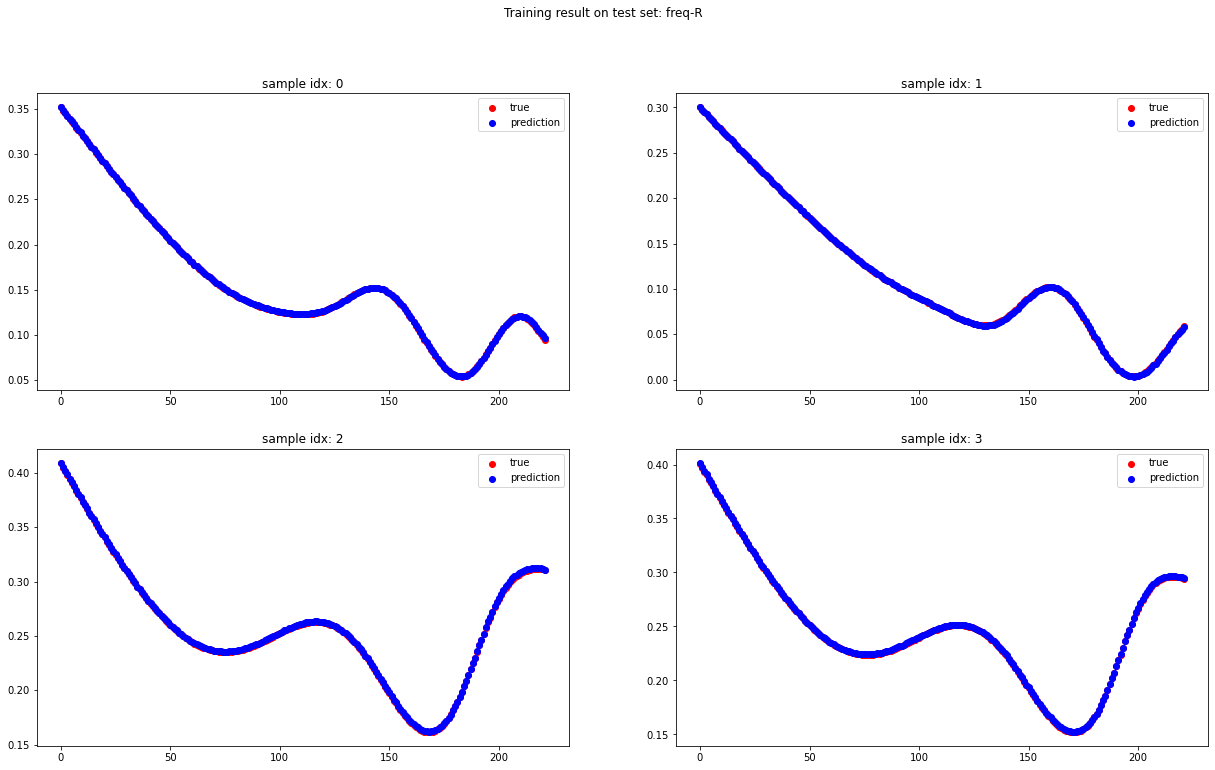

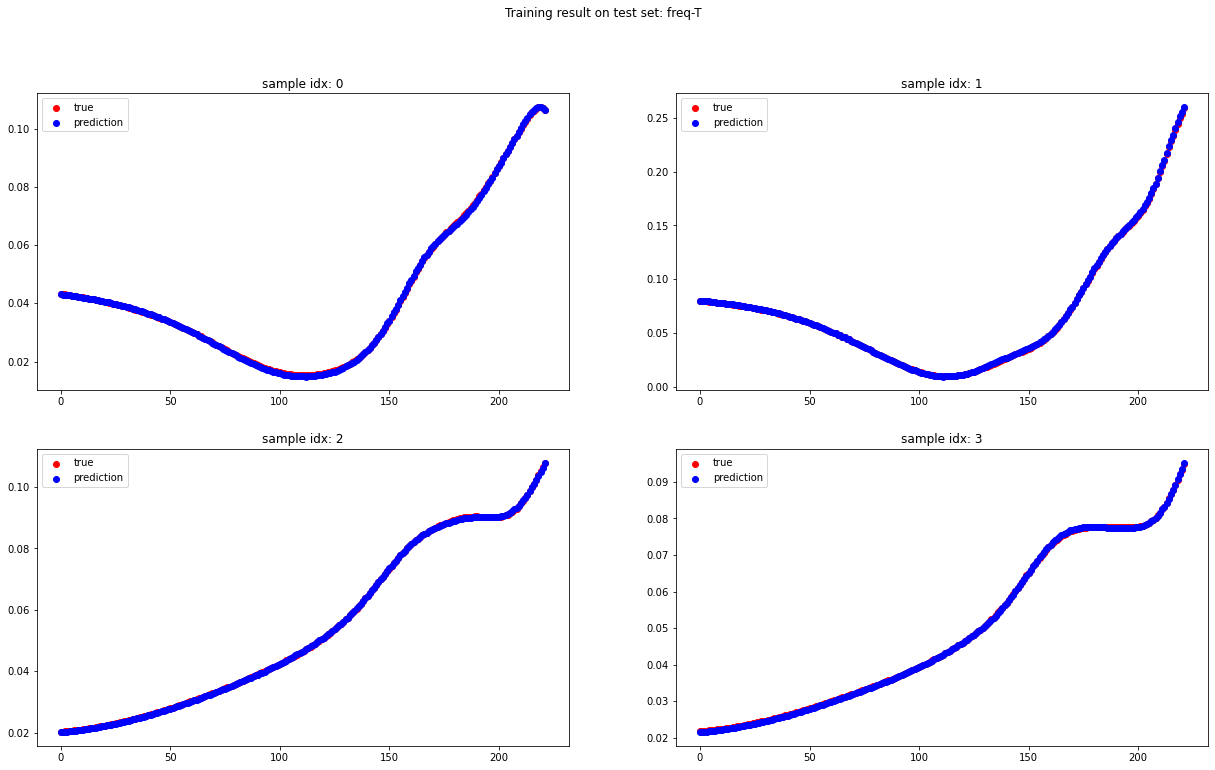

params_pick.shape: (10, 4)
params_pick: [[145. 122. 160.  75.]
 [145. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 123. 160.  75.]
 [146. 121. 160.  75.]
 [146. 123. 160.  75.]
 [145. 120. 160.  75.]
 [144. 122. 160.  75.]
 [146. 120. 160.  75.]
 [144. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


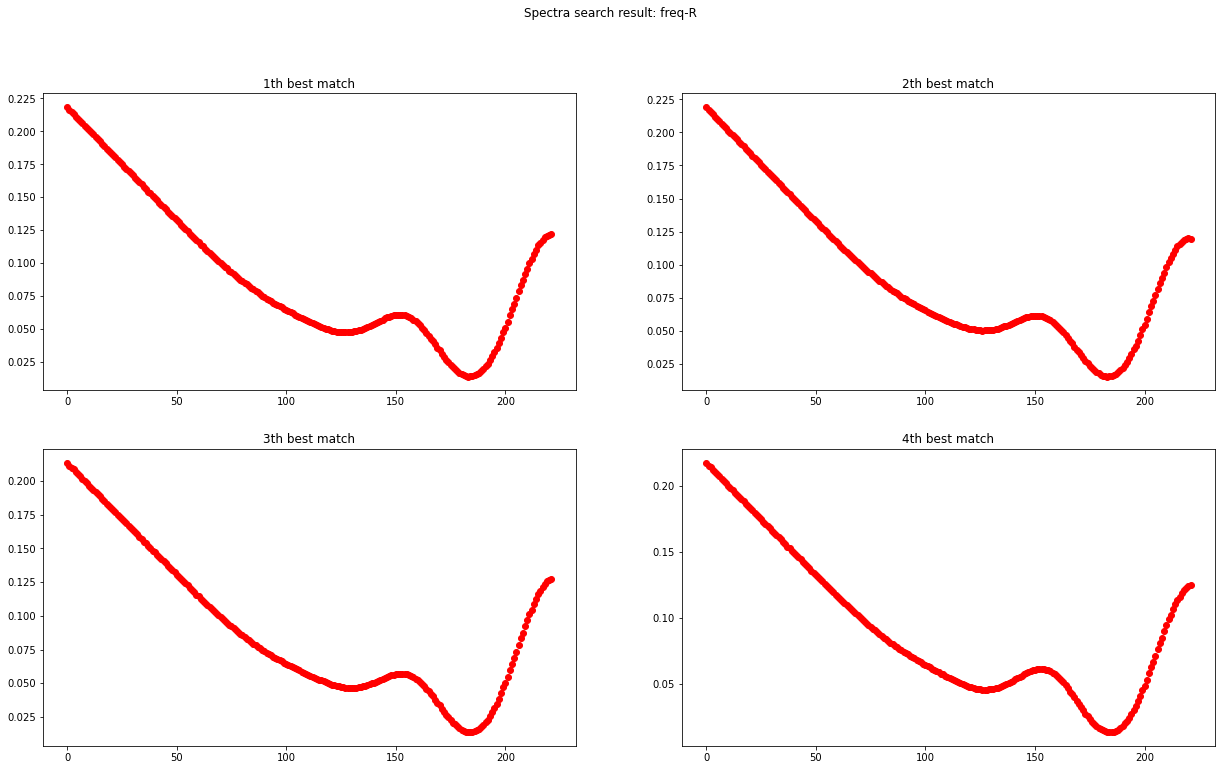

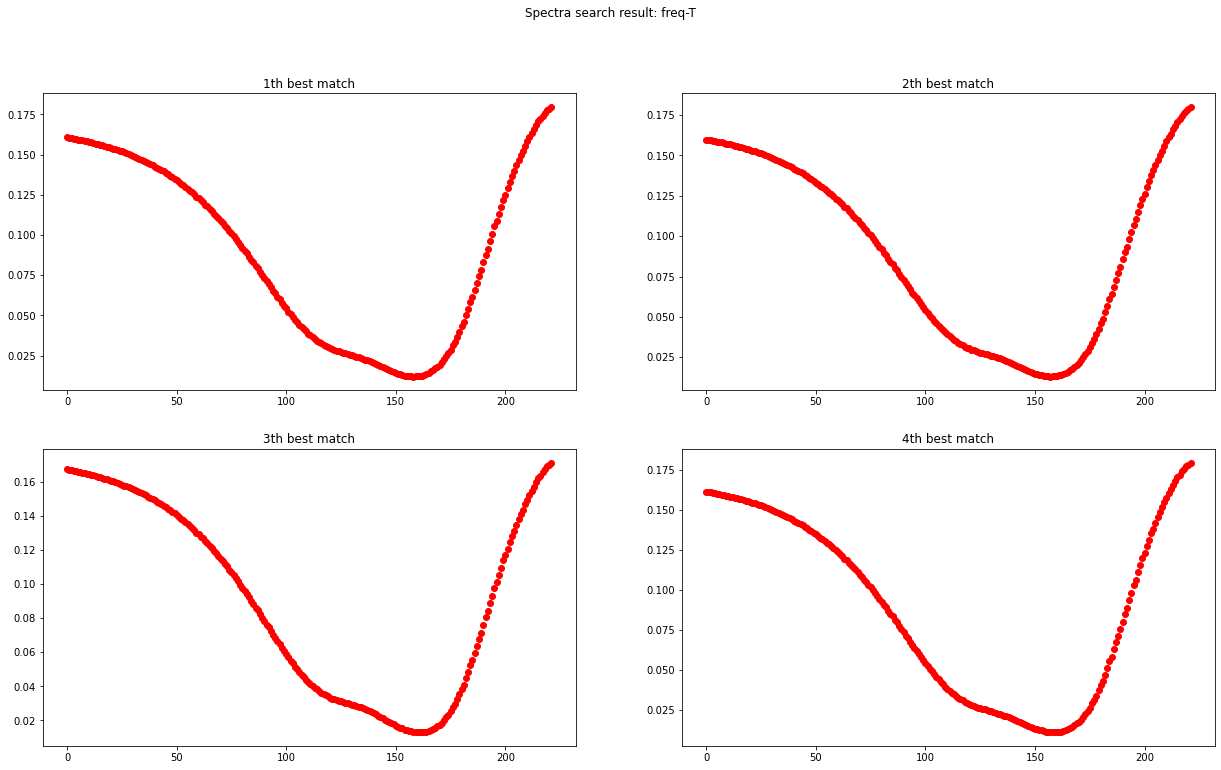

*** Reruning RCWA on picked params
params_dict.shape: (410, 4)
R_dict.shape: (410, 222)
T_dict.shape: (410, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
------------

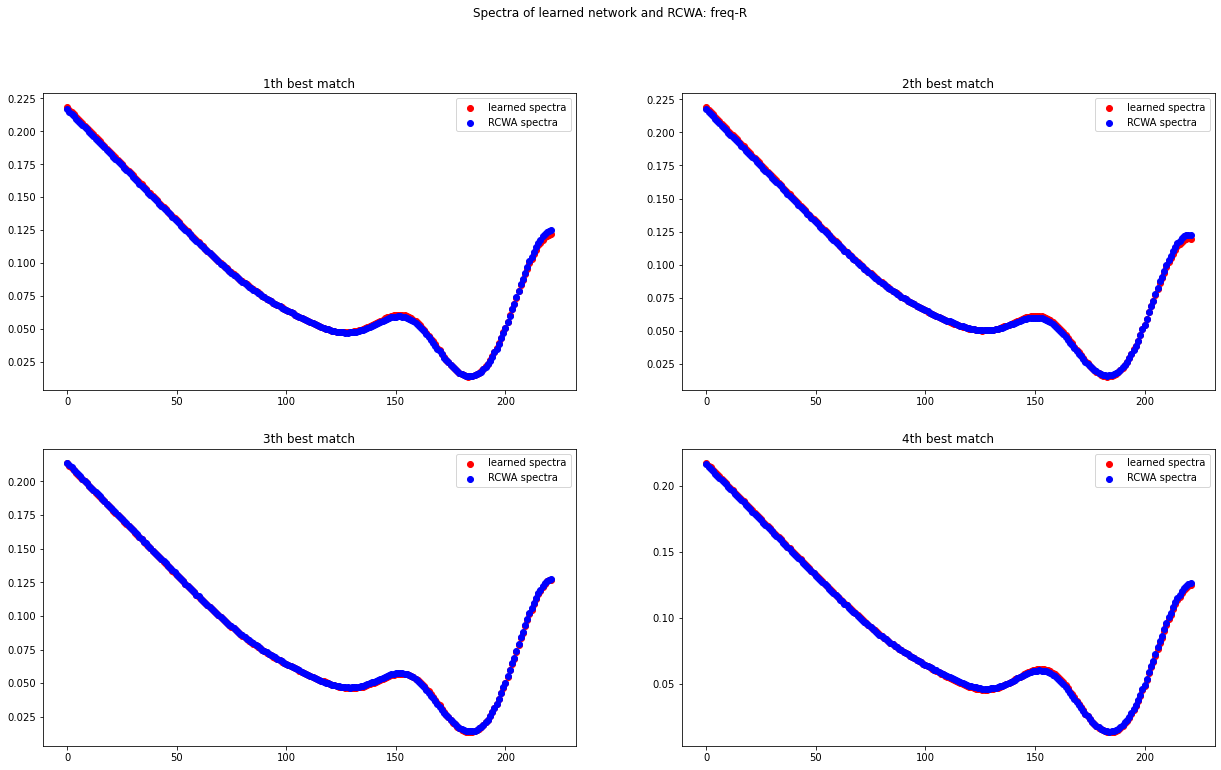

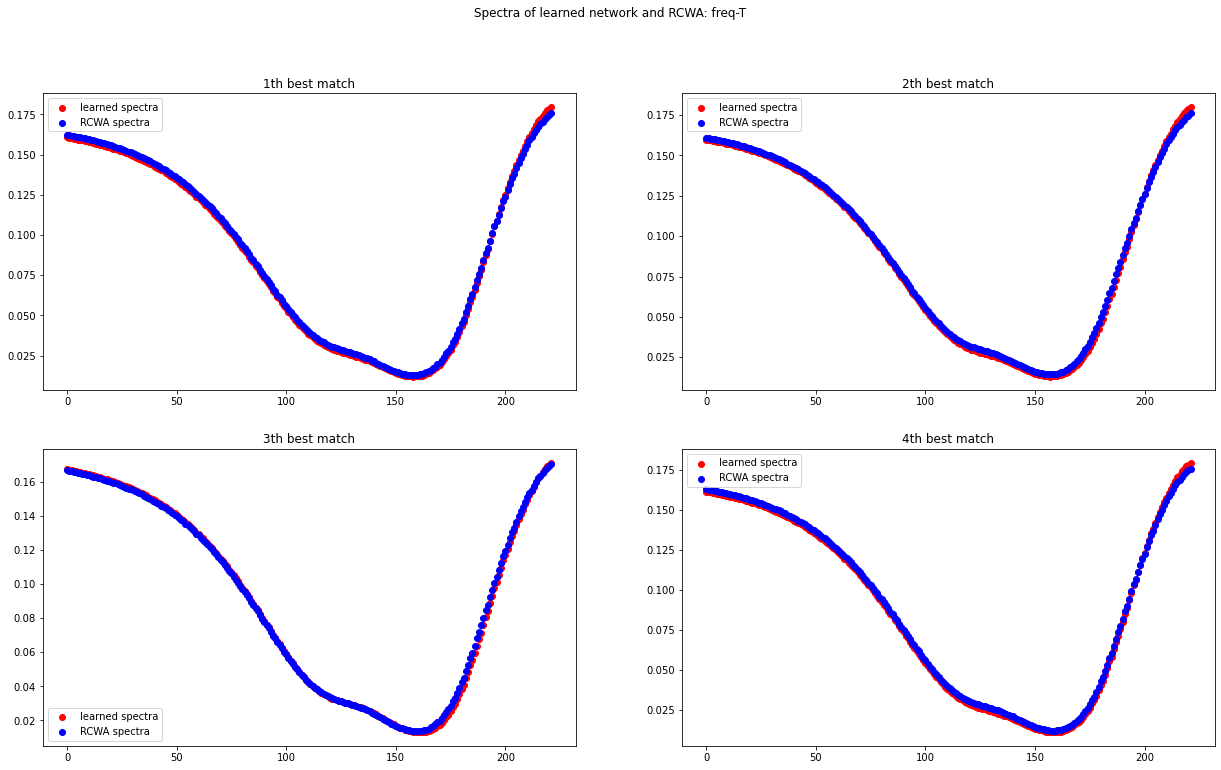

** Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 600
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [83. 88.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 93. 146.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [116.  57.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [134. 144.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [134.  68.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [141. 118.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [123.  52.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [86. 88.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [98. 92.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [132.  67.]
Calculation Prog

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [137.  89.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [95. 51.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [66. 69.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 81. 144.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [122.  66.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [92. 96.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [146.  87.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 60. 102.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 59. 139.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [104. 122.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [94. 51.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [145.  69.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00018398021960213857
### TEST LOSS  0.0003055428727141892
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 6.269667197443596e-05
### TEST LOSS  2.676686886439307e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.718422095758494e-05
### TEST LOSS  3.7968294539799295e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.8500988312980554e-05
### TEST LOSS  2.6904871952461286e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.3602944934661234e-05
### TEST LOSS  1.8870443555998565e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 4.118885630494636e-05
### TEST LOSS  2.4641241705264998e-05
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.8836706482261433e-06
### TEST LOSS  1.8851967019549597e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.7304850173853006e-06
### TEST LOSS  1.0823327064220696e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.6227947971477382e-06
### TEST LOSS  2.358697896751336e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.094864186688028e-06
### TEST LOSS  1.8062487975435538e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.6847361532749498e-06
### TEST LOSS  1.7922440444332703e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.5190732928023938e-06
### TEST LOSS  1.1533392125784303e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.680111847070293e-07
### TEST LOSS  7.924390325165909e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.1589226649041015e-06
### TEST LOSS  8.875732709788685e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.1494919762592796e-06
### TEST LOSS  9.300785437618389e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 9.884782355840115e-07
### TEST LOSS  6.601548029215742e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.0866662036571976e-06
### TEST LOSS  7.50518305873508e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.1659536961635317e-06
### TEST LOSS  1.2561825239269335e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.162161583532186e-07
### TEST LOSS  5.920380456498403e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.934906709294865e-07
### TEST LOSS  9.275455441739824e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 8.720643938175954e-07
### TEST LOSS  1.0590787143074622e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 1.0096188454866705e-06
### TEST LOSS  7.791209605380168e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.781535367082445e-07
### TEST LOSS  7.145317858380117e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 8.40898401458882e-07
### TEST LOSS  7.375211655218866e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 7.306851259751094e-07
### TEST LOSS  6.422357014596653e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 9.718156370652764e-07
### TEST LOSS  1.0743541325710894e-06
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.3897733533478155e-06
### TEST LOSS  9.263224253825481e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 8.488987732846453e-07
### TEST LOSS  9.699821311591627e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 7.582501718535658e-07
### TEST LOSS  6.370067858875295e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 7.423929650703561e-07
### TEST LOSS  9.11703441235861e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.932477231951338e-07
### TEST LOSS  6.440938528208385e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 7.018394602316865e-07
### TEST LOSS  5.061619390289707e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 7.886598572900046e-07
### TEST LOSS  1.6025685075267877e-06
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 8.704887479874893e-07
### TEST LOSS  8.800366736573374e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.056750886074269e-07
### TEST LOSS  5.846751997119604e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.406726017734362e-07
### TEST LOSS  4.4638552923162126e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 7.412761560724827e-07
### TEST LOSS  1.1055926986753345e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 6.399074009403686e-07
### TEST LOSS  5.43525591941337e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 7.133016026728001e-07
### TEST LOSS  8.966666326968051e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 9.497652519740996e-07
### TEST LOSS  7.991801377708422e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.953606459267272e-07
### TEST LOSS  3.9563459747821776e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 6.754909904908383e-07
### TEST LOSS  9.030450579909181e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.79452125902454e-07
### TEST LOSS  5.960827896463646e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.803213515065409e-07
### TEST LOSS  4.465374337946236e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.873821205426566e-07
### TEST LOSS  5.666437440747055e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 6.507819388327599e-07
### TEST LOSS  5.600179109579686e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 6.937935315202518e-07
### TEST LOSS  4.0442478166369256e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 5.936127325275227e-07
### TEST LOSS  8.331044290975519e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.370857377684501e-07
### TEST LOSS  6.96549382913266e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 5.568318866977506e-07
### TEST LOSS  5.706833058462103e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 7.780809114876774e-07
### TEST LOSS  1.0078647834335343e-06
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 7.473879470154543e-07
### TEST LOSS  4.84829914487111e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 6.652849231632748e-07
### TEST LOSS  5.301200474150392e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 5.574608655874632e-07
### TEST LOSS  6.020687363969854e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.525788340321469e-07
### TEST LOSS  6.125902005907038e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.911508756047586e-07
### TEST LOSS  4.508602336904409e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.073484732124693e-07
### TEST LOSS  5.173245180382461e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 5.594784367583354e-07
### TEST LOSS  3.6445174424039175e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 6.625625949752134e-07
### TEST LOSS  8.014504828679492e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 7.021292569338774e-07
### TEST LOSS  5.539860568306823e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.888181179770375e-07
### TEST LOSS  4.2776467365810174e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.089603917696194e-07
### TEST LOSS  5.119333745066493e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.572277472547626e-07
### TEST LOSS  5.828077323460295e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.990791559163673e-07
### TEST LOSS  5.141146933359172e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.3783970212984966e-07
### TEST LOSS  4.2684110389422534e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 5.818351061629794e-07
### TEST LOSS  3.509825287690344e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 5.453108433310187e-07
### TEST LOSS  3.362790816178555e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 5.185123248926023e-07
### TEST LOSS  3.88774705268386e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 5.896540821363298e-07
### TEST LOSS  3.675936126354726e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 5.134765856714315e-07
### TEST LOSS  5.444932185127982e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 5.26105874622355e-07
### TEST LOSS  8.698114963105278e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 5.22834237675814e-07
### TEST LOSS  6.531607570852632e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 7.892759872992391e-07
### TEST LOSS  8.073059171288655e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.4927925844244027e-07
### TEST LOSS  4.431192084868801e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 5.284351546563925e-07
### TEST LOSS  4.673864692803262e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.836235359680548e-07
### TEST LOSS  5.336728558328711e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.910871843518313e-07
### TEST LOSS  3.9785436140644174e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.915458691219972e-07
### TEST LOSS  4.0067623609098115e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.5289119221673483e-07
### TEST LOSS  4.0446432257744567e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.752715753021126e-07
### TEST LOSS  3.5085589110571567e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.3097550239679094e-07
### TEST LOSS  4.4583585968717267e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.961118243151929e-07
### TEST LOSS  5.898745788120626e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.878545204907898e-07
### TEST LOSS  8.106564008711656e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 5.095939972754592e-07
### TEST LOSS  2.783746361324625e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.0157704800591887e-07
### TEST LOSS  3.4688022449497817e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.824624639037211e-07
### TEST LOSS  3.166275127518424e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.4314555646944124e-07
### TEST LOSS  4.007388270110823e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.105162626307409e-07
### TEST LOSS  3.216347247795663e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.5073668740513996e-07
### TEST LOSS  3.848666539043835e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.546861787346756e-07
### TEST LOSS  6.313754915431168e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.2944299264509787e-07
### TEST LOSS  4.0378334789339635e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.2858585095710094e-07
### TEST LOSS  5.19513700207123e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 5.214402127743748e-07
### TEST LOSS  1.0232989716819752e-06
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.166424230452511e-07
### TEST LOSS  3.2453013116335365e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.38159984751015e-07
### TEST LOSS  2.972227801162969e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 4.409131343289611e-07
### TEST LOSS  2.945623281094514e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 7.090750501959065e-07
### TEST LOSS  4.720668805981e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 6.824093102745602e-07
### TEST LOSS  6.742731670783542e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 6.329918245858342e-07
### TEST LOSS  4.968950817227677e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 6.455243670266953e-07
### TEST LOSS  9.530086483917128e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 7.197963561189624e-07
### TEST LOSS  7.700985141430768e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 7.115584018417091e-07
### TEST LOSS  5.066884006686855e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 5.493276433199413e-07
### TEST LOSS  3.6132086241498956e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 5.600925484946136e-07
### TEST LOSS  4.963607377956375e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 5.2863781796475e-07
### TEST LOSS  4.858527170704797e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 6.549908321318298e-07
### TEST LOSS  9.56366894418655e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 7.457067485816537e-07
### TEST LOSS  5.007071371841853e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 5.604637709074231e-07
### TEST LOSS  9.520972778571174e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 4.6106807856105546e-07
### TEST LOSS  5.003832054879038e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 5.219523529476077e-07
### TEST LOSS  5.290486879200923e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 5.552169145772723e-07
### TEST LOSS  5.135376094737391e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 5.209187878444747e-07
### TEST LOSS  5.380400883344313e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 6.734963296987454e-07
### TEST LOSS  4.395145967666597e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 5.742600415222417e-07
### TEST LOSS  6.392827079556204e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 4.863150335350971e-07
### TEST LOSS  3.423059303663144e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 5.067843968002232e-07
### TEST LOSS  3.9634046326379274e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 4.478507289462641e-07
### TEST LOSS  4.840265211846095e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.3664997836145856e-07
### TEST LOSS  5.869387867581585e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 4.292536708779456e-07
### TEST LOSS  4.792924244156893e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.5901776503617004e-07
### TEST LOSS  4.480671849351994e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 5.018124122457835e-07
### TEST LOSS  4.2366172200066404e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.9556045493327475e-07
### TEST LOSS  3.6913195660619954e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 4.228076500467637e-07
### TEST LOSS  4.3224402348742944e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 4.47249518344961e-07
### TEST LOSS  4.117792305654196e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 4.0789579900391006e-07
### TEST LOSS  3.733496340727369e-07
----------------------------------------------------------------------
*** EPOCH 1066 || AVG LOSS 4.2843576771052955e-07
### TEST LOSS  5.809813438241285e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 4.4329375500732716e-07
### TEST LOSS  3.083386938366554e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 4.2119251643176387e-07
### TEST LOSS  4.4048478760790505e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.2975752052143434e-07
### TEST LOSS  4.669083277046108e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.8410909267483364e-07
### TEST LOSS  3.920437134436522e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 4.281329273888209e-07
### TEST LOSS  3.0951572840523215e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 4.5021543038833063e-07
### TEST LOSS  4.7607376687766293e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.810762128016639e-07
### TEST LOSS  3.702240086845955e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 4.102062361729016e-07
### TEST LOSS  2.4917582190179627e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 4.6005485941099287e-07
### TEST LOSS  2.948064169080074e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 4.4360404035141223e-07
### TEST LOSS  2.9164161850935165e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 5.132581608672619e-07
### TEST LOSS  3.0752796457515313e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 4.076194189887398e-07
### TEST LOSS  2.942398932898666e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.650915262672546e-07
### TEST LOSS  4.919318522903874e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 4.122424546260106e-07
### TEST LOSS  4.99107421268895e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 4.697995961559324e-07
### TEST LOSS  3.6537731299783144e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.8036640219137517e-07
### TEST LOSS  6.514208431932881e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.576669098611281e-07
### TEST LOSS  3.1881581068975924e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 4.292323983060934e-07
### TEST LOSS  4.527547648396851e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.368999101856692e-07
### TEST LOSS  3.5797214081867423e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 4.1924550783297337e-07
### TEST LOSS  2.512625469661442e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.3746001552851606e-07
### TEST LOSS  2.7997895162772897e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.7121261576326484e-07
### TEST LOSS  4.821116306175099e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.796783730199612e-07
### TEST LOSS  4.674641300223609e-07
----------------------------------------------------------------------
*** EPOCH 1275 || AVG LOSS 3.61223824286346e-07
### TEST LOSS  2.7998106115016225e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.8509150040037337e-07
### TEST LOSS  3.0284960593639374e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.633084981717142e-07
### TEST LOSS  5.54289733322043e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 4.333351078678049e-07
### TEST LOSS  2.811577657111128e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.8244901607124385e-07
### TEST LOSS  3.22213592893503e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.9641786611236775e-07
### TEST LOSS  3.825224628902409e-07
----------------------------------------------------------------------
*** EPOCH 1327 || AVG LOSS 3.4016256523254166e-07
### TEST LOSS  2.9236970375576573e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.530453073056587e-07
### TEST LOSS  2.633076074213629e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.8841435497261044e-07
### TEST LOSS  3.556717445007962e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.789846864007037e-07
### TEST LOSS  3.32158685346763e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.759927046272556e-07
### TEST LOSS  4.7298521129353804e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.779955411549925e-07
### TEST LOSS  4.5333525299105935e-07
----------------------------------------------------------------------
*** EPOCH 1379 || AVG LOSS 3.80867053018837e-07
### TEST LOSS  4.668693646989494e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 4.2706121019383164e-07
### TEST LOSS  2.2895730467098474e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.1387674415720804e-07
### TEST LOSS  4.1886595012227997e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.608055652234062e-07
### TEST LOSS  4.047999734919156e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.749235507832793e-07
### TEST LOSS  3.0643856361065343e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.2408265475088647e-07
### TEST LOSS  4.030416423322297e-07
----------------------------------------------------------------------
*** EPOCH 1431 || AVG LOSS 3.5256907434444427e-07
### TEST LOSS  3.9677096058059965e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.7173623827158055e-07
### TEST LOSS  2.6337339736275885e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 4.1684095802925943e-07
### TEST LOSS  3.2157686291611753e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 4.078948943260959e-07
### TEST LOSS  3.80294646144345e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.369960973387265e-07
### TEST LOSS  3.3970027225728296e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.9218355376272975e-07
### TEST LOSS  4.2397386184549964e-07
----------------------------------------------------------------------
*** EPOCH 1483 || AVG LOSS 3.6135225865763233e-07
### TEST LOSS  3.102580371382323e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.403996607668584e-07
### TEST LOSS  2.897850840276482e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.7447447001663176e-07
### TEST LOSS  5.453929740421396e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.621814265860242e-07
### TEST LOSS  2.383630241335292e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.545721038022975e-07
### TEST LOSS  5.370546602989634e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.471218505464909e-07
### TEST LOSS  6.773393895148022e-07
----------------------------------------------------------------------
*** EPOCH 1535 || AVG LOSS 3.2028801300043597e-07
### TEST LOSS  3.5078158412539375e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.039948564046805e-07
### TEST LOSS  3.0798124031308464e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.1875024882666023e-07
### TEST LOSS  3.7111202446895834e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.538336948061271e-07
### TEST LOSS  2.8924294149924714e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.992012541627806e-07
### TEST LOSS  3.4897844771977463e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.026713843764147e-07
### TEST LOSS  2.521806881835194e-07
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 3.262671938190446e-07
### TEST LOSS  5.527784941882096e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.156335576252426e-07
### TEST LOSS  3.5737026375196973e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.303964047537041e-07
### TEST LOSS  3.256881926619018e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.7582224300318026e-07
### TEST LOSS  2.564958773771448e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.443538785911452e-07
### TEST LOSS  3.6061594086176126e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.3293825769812693e-07
### TEST LOSS  3.241142015516137e-07
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 3.5184987276911293e-07
### TEST LOSS  3.639859092648597e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.0907896080734077e-07
### TEST LOSS  2.963547368987444e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.323255718730896e-07
### TEST LOSS  2.572545806995347e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.127274176447277e-07
### TEST LOSS  2.815834644959775e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.196000404533568e-07
### TEST LOSS  2.7403028626496155e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.0804262720470393e-07
### TEST LOSS  3.461218606541176e-07
----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 3.0005977218176366e-07
### TEST LOSS  2.2863948995816625e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.4758994137481145e-07
### TEST LOSS  2.718293296134612e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.7867828759298165e-07
### TEST LOSS  2.5431166584945055e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.10477735515254e-07
### TEST LOSS  2.4058683026042775e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.8836668117075227e-07
### TEST LOSS  3.630149447215242e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.110784090676333e-07
### TEST LOSS  2.3811232097159518e-07
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 3.1895830797286826e-07
### TEST LOSS  3.2140989484711707e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.0351078838937914e-07
### TEST LOSS  6.484238560410126e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.9329541686801877e-07
### TEST LOSS  2.99454544321836e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.247335550534321e-07
### TEST LOSS  3.4898307098450863e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.648737345545271e-07
### TEST LOSS  2.6635712578758506e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.6930383088199887e-07
### TEST LOSS  4.7434534483020093e-07
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 3.0642689231659876e-07
### TEST LOSS  2.2167982333737908e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.3362368865160384e-07
### TEST LOSS  2.957610673901298e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.165750679260763e-07
### TEST LOSS  3.3697558087118927e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.2010340328033257e-07
### TEST LOSS  2.277909171905574e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.222380567002858e-07
### TEST LOSS  2.2963655826262968e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.218326580700648e-07
### TEST LOSS  3.8408028520583076e-07
----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 3.0149887983554893e-07
### TEST LOSS  3.03646796990304e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.9015495105255697e-07
### TEST LOSS  2.784746521279481e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.5516427816517647e-07
### TEST LOSS  2.1083204791870634e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.12638792886825e-07
### TEST LOSS  2.5139136362718597e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.303340762942734e-07
### TEST LOSS  2.447541349839513e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 2.9372121052399317e-07
### TEST LOSS  3.1925682877600695e-07
----------------------------------------------------------------------
*** EPOCH 1899 || AVG LOSS 3.4722157463621767e-07
### TEST LOSS  3.8177707198075143e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.431047663167893e-07
### TEST LOSS  2.7415489493402373e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.275050481832409e-07
### TEST LOSS  3.4459163897635233e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.766754449723408e-07
### TEST LOSS  3.32270088973827e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 2.9100384146829583e-07
### TEST LOSS  2.3844269965896575e-07
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 2.8211016554517226e-07
### TEST LOSS  2.3696455602678017e-07
----------------------------------------------------------------------
*** EPOCH 1952 || AVG LOSS 2.695379212565759e-07
### TEST LOSS  2.0289332288333148e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.292690503512811e-07
### TEST LOSS  4.0326791703490824e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.8627969403061113e-07
### TEST LOSS  2.9218047359336197e-07
** loss_train 2.8627969403061113e-07
** loss_test 2.9218047359336197e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


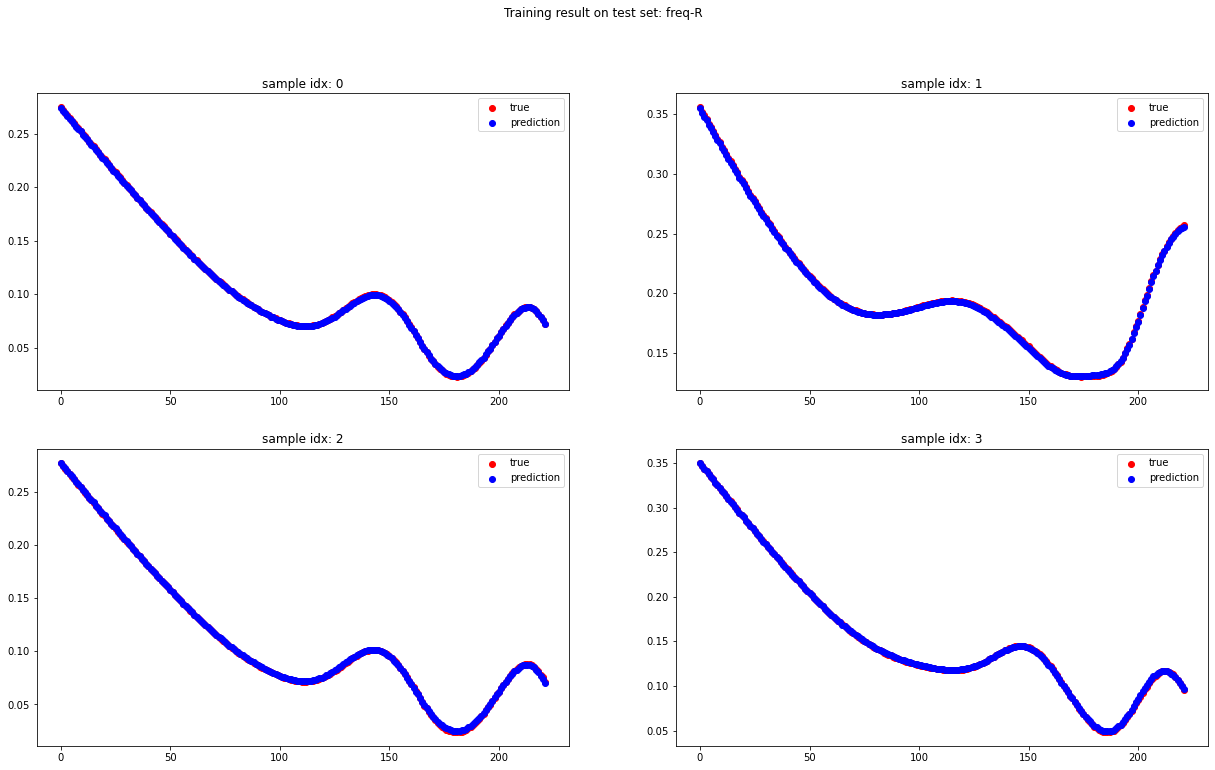

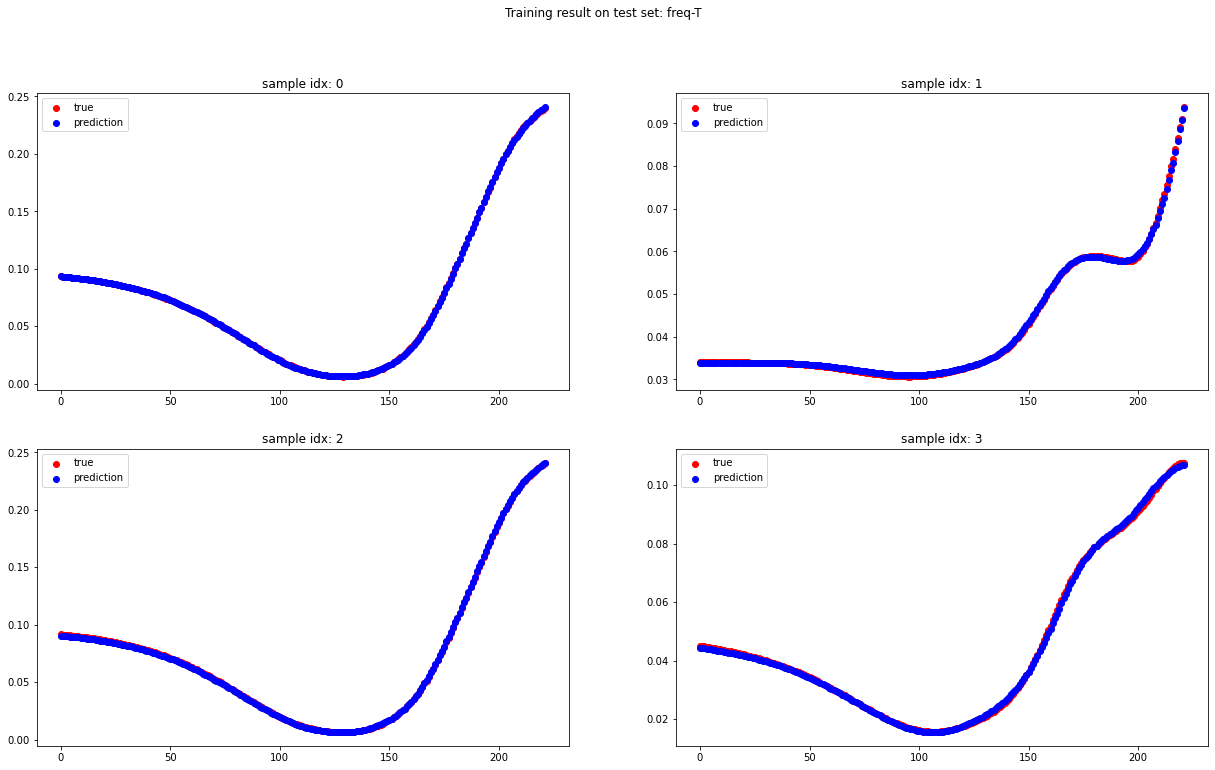

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [145. 122. 160.  75.]
 [147. 121. 160.  75.]
 [147. 122. 160.  75.]
 [146. 123. 160.  75.]
 [145. 123. 160.  75.]
 [147. 120. 160.  75.]
 [145. 121. 160.  75.]
 [146. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


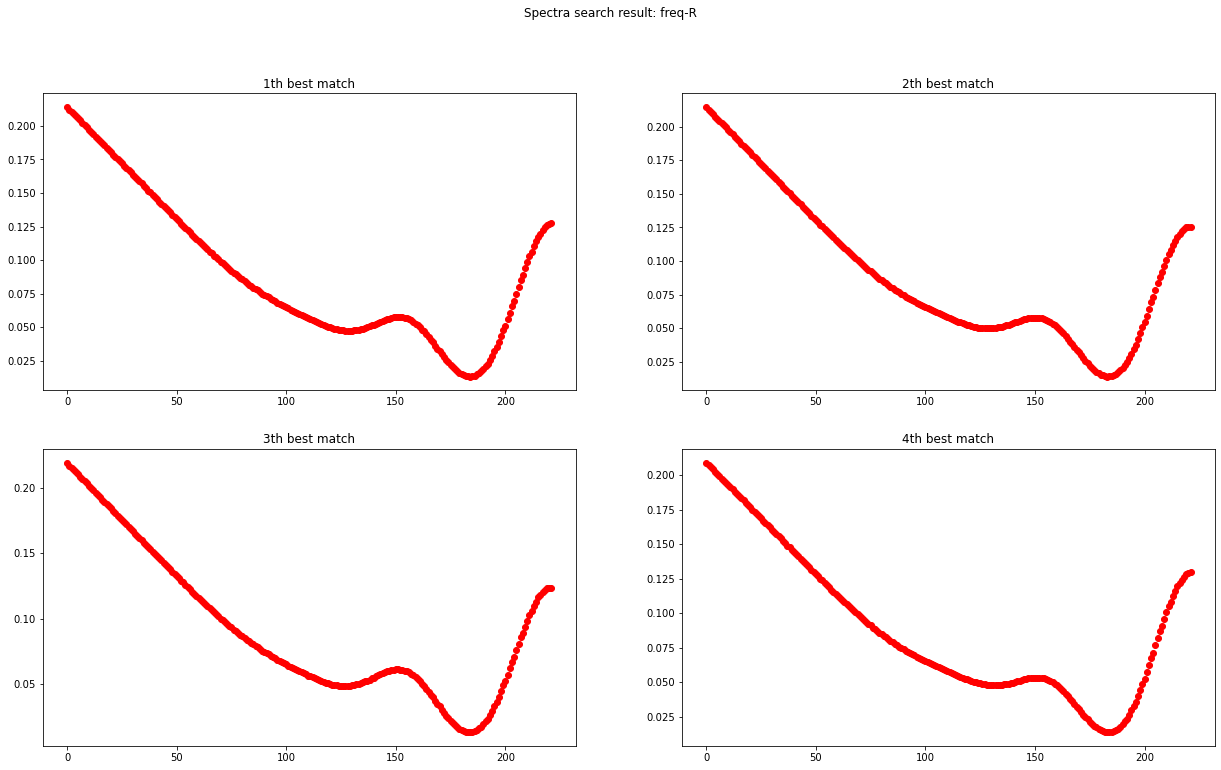

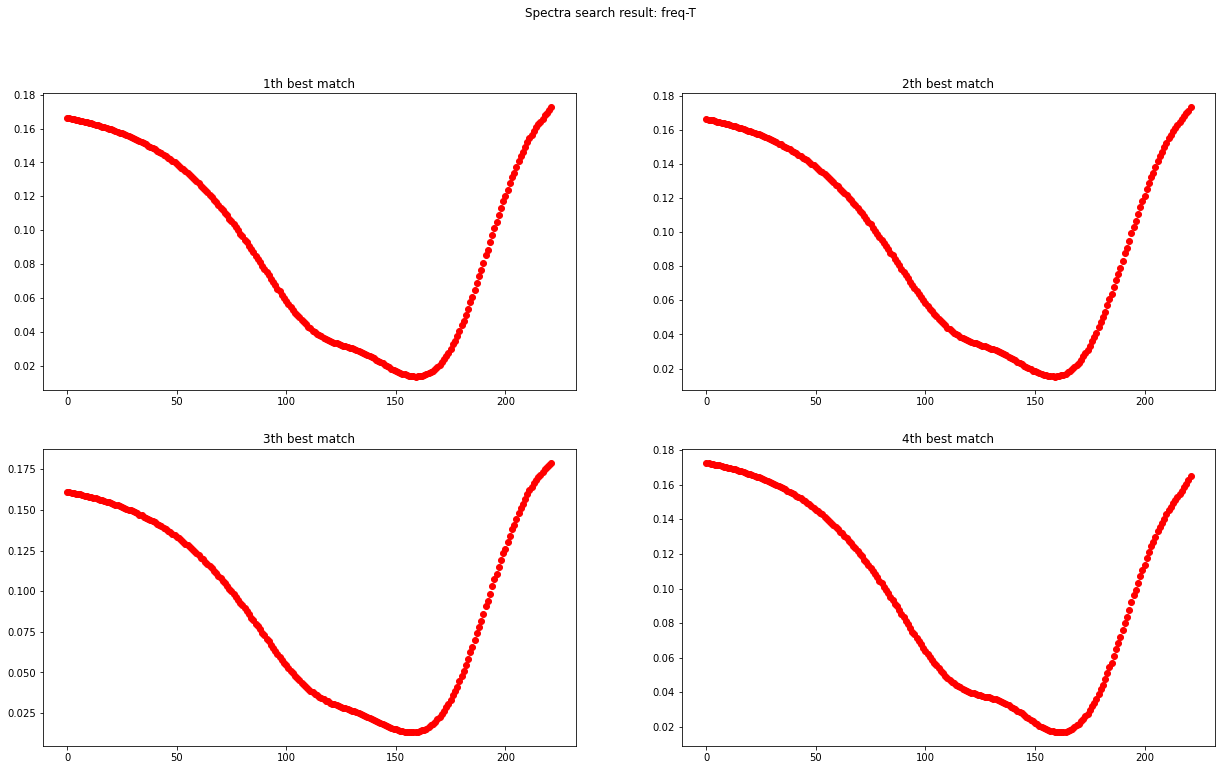

*** Reruning RCWA on picked params
params_dict.shape: (613, 4)
R_dict.shape: (613, 222)
T_dict.shape: (613, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [147. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.]

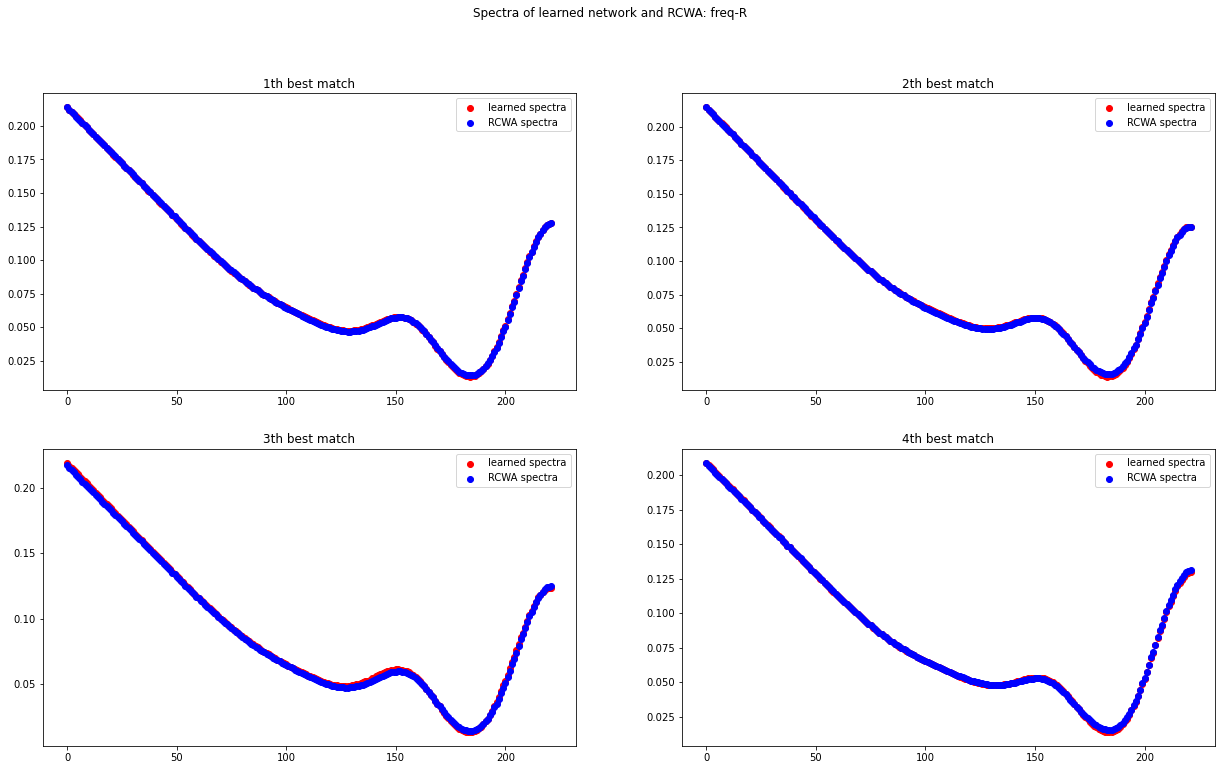

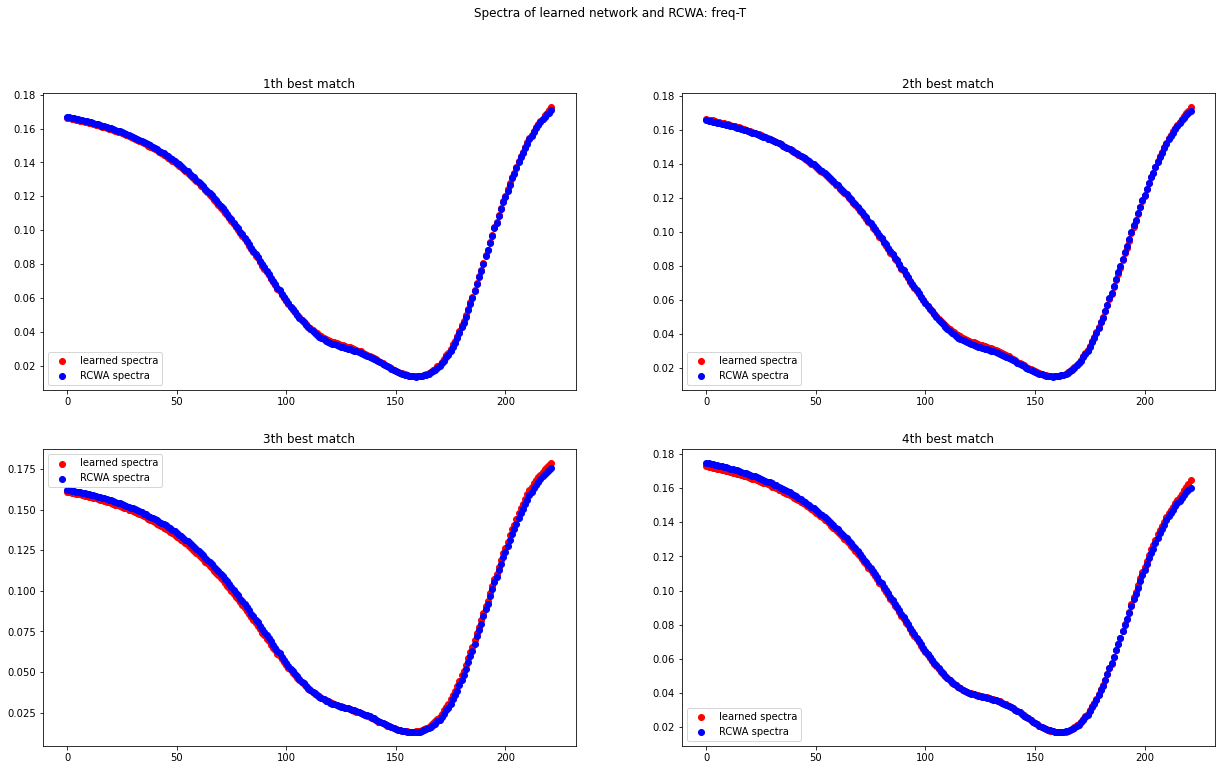

** Model saved.
**************************** ROUND 4 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 800
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [125.  58.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [101.  80.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [133. 132.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [147. 128.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 96. 149.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [110.  90.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [79. 97.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [108.  85.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [139.  91.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [65. 77.]
Calculation Pr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 51. 113.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [117.  65.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 88. 149.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 69. 147.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [118. 102.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [109. 148.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [125.  93.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 66. 106.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [66. 95.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [129. 102.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [86. 56.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [150. 115.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00010273929571326334
### TEST LOSS  0.00020149660182748144
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 4.0146168285417616e-05
### TEST LOSS  1.9570571263708796e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.059450994186364e-05
### TEST LOSS  1.3809635637092773e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.8862469779037384e-05
### TEST LOSS  4.14786128809889e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.471093186883877e-05
### TEST LOSS  2.9840706398924038e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 1.5105578823124688e-05
### TEST LOSS  1.1948360603734423e-05
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 2.8619502369764403e-06
### TEST LOSS  1.516516922113927e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.8171287849888529e-06
### TEST LOSS  1.2708233659471564e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.6730060338865372e-06
### TEST LOSS  1.2160743807498875e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.233725335616498e-06
### TEST LOSS  1.675998201259669e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.372423245715737e-06
### TEST LOSS  1.7085883522819738e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.2245121578580154e-06
### TEST LOSS  7.527692863125898e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 9.394706753695914e-07
### TEST LOSS  6.167173438598184e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 8.237654959053487e-07
### TEST LOSS  1.1443364608491418e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.1476663462239855e-06
### TEST LOSS  1.0461638358568355e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 9.831581676689184e-07
### TEST LOSS  9.076575887926689e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 7.344112076612674e-07
### TEST LOSS  8.54667111601278e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 8.530286898889017e-07
### TEST LOSS  1.4127860102538155e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 9.115747729726565e-07
### TEST LOSS  7.186986058134911e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.616208948224567e-07
### TEST LOSS  4.944400870954269e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.761281925677821e-07
### TEST LOSS  6.587722604460092e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.839439151828941e-07
### TEST LOSS  9.164078278445231e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.791544674511485e-07
### TEST LOSS  5.710867156949462e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 6.227744706333027e-07
### TEST LOSS  4.312476278300892e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 7.689233454044598e-07
### TEST LOSS  1.4514075227604433e-06
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 8.287603293943846e-07
### TEST LOSS  8.932171766673491e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.446612831556564e-07
### TEST LOSS  5.232097824621936e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 7.467571275432406e-07
### TEST LOSS  8.7968462499551e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 7.827661582915369e-07
### TEST LOSS  5.500511737939936e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 7.674457556916537e-07
### TEST LOSS  5.104448751088361e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.256744535892977e-07
### TEST LOSS  4.030971207195459e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.109079289995379e-07
### TEST LOSS  6.068462283792542e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 6.598367784871328e-07
### TEST LOSS  4.804369761283548e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 6.577974120958174e-07
### TEST LOSS  6.459566606054068e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.732446172996731e-07
### TEST LOSS  5.07785578918174e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 7.918230022330164e-07
### TEST LOSS  6.164210664868127e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 5.609853923260744e-07
### TEST LOSS  9.24455136441793e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 7.17183972467339e-07
### TEST LOSS  1.1762444861081651e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 6.354860688784214e-07
### TEST LOSS  3.970457811419692e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 7.383473909161608e-07
### TEST LOSS  6.346740140846426e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.113510373355723e-07
### TEST LOSS  5.101471648079799e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.706625400403453e-07
### TEST LOSS  1.3732402521782205e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 6.001610386885403e-07
### TEST LOSS  4.1246425771153855e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.413709885715434e-07
### TEST LOSS  4.170083324576505e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.921023164034977e-07
### TEST LOSS  4.4239882631321353e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.483468803291203e-07
### TEST LOSS  4.2615925366362717e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.262662500093995e-07
### TEST LOSS  1.001944511358488e-06
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 5.085556531847501e-07
### TEST LOSS  8.676309543413178e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.067503391842365e-07
### TEST LOSS  5.672738178456408e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 5.123330556955352e-07
### TEST LOSS  4.810873193150655e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.970925316616359e-07
### TEST LOSS  5.614410791091965e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.454751658273693e-07
### TEST LOSS  5.209975076544046e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 5.010340467137553e-07
### TEST LOSS  5.9313237935991e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 5.172461253000193e-07
### TEST LOSS  4.5478914027323e-07
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.224892528232772e-07
### TEST LOSS  5.18716672578042e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.7368973919326153e-07
### TEST LOSS  4.6900524589924924e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.15054569381057e-07
### TEST LOSS  4.944703372681639e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.906850010222286e-07
### TEST LOSS  1.4494502617405185e-06
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.714878918399279e-07
### TEST LOSS  4.949916885266248e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.951716099821368e-07
### TEST LOSS  3.8128556193820867e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.960630967865143e-07
### TEST LOSS  4.5743396033988876e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.305825413381982e-07
### TEST LOSS  5.218465304324127e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 6.706944085221878e-07
### TEST LOSS  4.1174192233484064e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 5.688686577087765e-07
### TEST LOSS  3.2814031906506597e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.747497653223576e-07
### TEST LOSS  4.4208041316551316e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 5.112465982204383e-07
### TEST LOSS  3.544083047775833e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.665797484326717e-07
### TEST LOSS  4.757147256858237e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.579238909618866e-07
### TEST LOSS  7.818964036232501e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.648407174823177e-07
### TEST LOSS  3.443614436567562e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.52424631394166e-07
### TEST LOSS  4.923872722883971e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 5.010873310684616e-07
### TEST LOSS  6.368934701110144e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 9.52109418195235e-07
### TEST LOSS  1.3143366572876403e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 5.185491387615926e-07
### TEST LOSS  5.790603789061303e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.523916794951788e-07
### TEST LOSS  3.459862275197641e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 5.031517524489715e-07
### TEST LOSS  4.223232323852244e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.2168162477373984e-07
### TEST LOSS  3.933559563999249e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.713680456136515e-07
### TEST LOSS  5.137741491504736e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.7292032476775605e-07
### TEST LOSS  5.417659683833639e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 5.11259728934732e-07
### TEST LOSS  4.360830014131049e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 5.355686906494128e-07
### TEST LOSS  6.789910524200119e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 7.043198390599415e-06
### TEST LOSS  3.1952840610453372e-06
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 6.101525710331401e-06
### TEST LOSS  5.455595271541824e-06
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.8442547403884076e-06
### TEST LOSS  7.601126317998327e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 8.072307901452191e-07
### TEST LOSS  8.797244722321315e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.943577213278871e-07
### TEST LOSS  2.9422495491833917e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 5.352011844816928e-07
### TEST LOSS  3.0113777308808193e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.5920439267543856e-07
### TEST LOSS  3.6233211157347495e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.2023547536906846e-07
### TEST LOSS  4.953072760827126e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.365694783503571e-07
### TEST LOSS  6.574587653555378e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.996422227732112e-07
### TEST LOSS  5.613592103751822e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.973206144758379e-07
### TEST LOSS  2.891029401060526e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.1480682041239445e-07
### TEST LOSS  6.150766864720936e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 7.58967262992627e-07
### TEST LOSS  5.210954275488197e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 5.799712309251248e-07
### TEST LOSS  4.7524905492461283e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.330289994625147e-07
### TEST LOSS  3.5952466485393114e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.9935422253556395e-07
### TEST LOSS  3.6004987672792293e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 4.0484792815043133e-07
### TEST LOSS  5.208334149150081e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 4.419340681982575e-07
### TEST LOSS  3.634126860182126e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.3299498178495097e-07
### TEST LOSS  6.586914385782924e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 4.188248414216389e-07
### TEST LOSS  4.4927571707376046e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.744086012387072e-07
### TEST LOSS  3.136125374207192e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.948332284431366e-07
### TEST LOSS  7.084532095783894e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.8113802839134794e-07
### TEST LOSS  5.091163615134064e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.381370102679583e-07
### TEST LOSS  3.3728968891940286e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.757352407696146e-07
### TEST LOSS  2.79202064727239e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.0138901870712116e-07
### TEST LOSS  3.165914558659703e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.685709553919892e-07
### TEST LOSS  5.137168154571251e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.560524776036189e-07
### TEST LOSS  3.7293067123300716e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.956712077668456e-07
### TEST LOSS  5.508025561577293e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 4.4599291067370926e-07
### TEST LOSS  4.588639583857912e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.761918569633593e-07
### TEST LOSS  1.2933916953746423e-06
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.7690540487744784e-07
### TEST LOSS  3.323181860063566e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 4.35774500489039e-07
### TEST LOSS  4.378468645427347e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 4.049388882920724e-07
### TEST LOSS  2.8236560704423635e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 4.309397669421955e-07
### TEST LOSS  8.692624741494607e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 5.18476228132947e-07
### TEST LOSS  6.222764289039636e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.968276096832923e-07
### TEST LOSS  2.7023400761549965e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.6735358823314355e-07
### TEST LOSS  4.096877598650887e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 4.407543284878912e-07
### TEST LOSS  4.5489300977881914e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.2876521257895204e-07
### TEST LOSS  3.043552479671992e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.809414867994576e-07
### TEST LOSS  4.586799728182693e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 4.6132987962632655e-07
### TEST LOSS  4.1576820090464633e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 4.5770485789020655e-07
### TEST LOSS  3.551557673138935e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 4.072085804907033e-07
### TEST LOSS  4.0465714571761663e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 4.225481787223373e-07
### TEST LOSS  4.437007727157531e-07
----------------------------------------------------------------------
*** EPOCH 1066 || AVG LOSS 3.61531144950078e-07
### TEST LOSS  3.5168548132939276e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.640283660244492e-07
### TEST LOSS  3.583825905669376e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.94234975684693e-07
### TEST LOSS  3.4018621401325316e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.247499395892973e-07
### TEST LOSS  4.084298860599726e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.8500185731038525e-07
### TEST LOSS  4.5558438207156843e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 4.098945502661877e-07
### TEST LOSS  2.929699078890735e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 4.2408193237530864e-07
### TEST LOSS  3.5762945789959605e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.766897586165996e-07
### TEST LOSS  4.1045007748152784e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 4.083593674630848e-07
### TEST LOSS  4.410102292240481e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 4.155840017006085e-07
### TEST LOSS  2.9791569981322635e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.7304275157357126e-07
### TEST LOSS  3.2049723112474265e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 4.00350060187904e-07
### TEST LOSS  3.7167965653376694e-07
----------------------------------------------------------------------
*** EPOCH 1171 || AVG LOSS 3.7891718361660055e-07
### TEST LOSS  3.0521269186086403e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.927972471595709e-07
### TEST LOSS  5.800246422419756e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 4.459596130423904e-07
### TEST LOSS  5.409049184853151e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.765266295552294e-07
### TEST LOSS  3.002784545458326e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 4.5819678483827176e-07
### TEST LOSS  5.187302605236255e-07
----------------------------------------------------------------------
*** EPOCH 1223 || AVG LOSS 3.7403899995069877e-07
### TEST LOSS  3.6496177931629364e-07
----------------------------------------------------------------------
*** EPOCH 1224 || AVG LOSS 3.2755531111483547e-07
### TEST LOSS  6.3097129536042e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.7053340748993693e-07
### TEST LOSS  5.540938730064227e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.6875041375061813e-07
### TEST LOSS  2.890616173090166e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 4.1908596143169774e-07
### TEST LOSS  3.6021934590735327e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.857038549348601e-07
### TEST LOSS  2.734873258229224e-07
----------------------------------------------------------------------
*** EPOCH 1275 || AVG LOSS 3.8180736630533116e-07
### TEST LOSS  6.380749179394721e-07
----------------------------------------------------------------------
*** EPOCH 1276 || AVG LOSS 3.879624183777963e-07
### TEST LOSS  3.4148350872934924e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.885157126415351e-07
### TEST LOSS  7.220003084285054e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.5350142956414033e-07
### TEST LOSS  3.771139489572306e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.4735250337813994e-07
### TEST LOSS  2.450223123654875e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.531329994554966e-07
### TEST LOSS  4.0786814755241113e-07
----------------------------------------------------------------------
*** EPOCH 1327 || AVG LOSS 3.3932197446961964e-07
### TEST LOSS  3.972943597811233e-07
----------------------------------------------------------------------
*** EPOCH 1328 || AVG LOSS 3.239717422331978e-07
### TEST LOSS  4.398614639929595e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.807886111628633e-07
### TEST LOSS  2.79449538472439e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.2454589879771236e-07
### TEST LOSS  2.7164723448436234e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.672144488664486e-07
### TEST LOSS  3.343153854492205e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.4146498387510607e-07
### TEST LOSS  3.5100444743344877e-07
----------------------------------------------------------------------
*** EPOCH 1379 || AVG LOSS 4.1939677219993143e-07
### TEST LOSS  3.9710162980099994e-07
----------------------------------------------------------------------
*** EPOCH 1380 || AVG LOSS 5.88075459102555e-07
### TEST LOSS  3.456575351871531e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.3139167117557376e-07
### TEST LOSS  2.9653875680916525e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.421905559086724e-07
### TEST LOSS  3.8714777990852173e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.482713381286473e-07
### TEST LOSS  2.944917838476613e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.3103785090915494e-07
### TEST LOSS  3.288485016147054e-07
----------------------------------------------------------------------
*** EPOCH 1431 || AVG LOSS 3.3381769952711694e-07
### TEST LOSS  3.078561642648007e-07
----------------------------------------------------------------------
*** EPOCH 1432 || AVG LOSS 3.6802617136011407e-07
### TEST LOSS  5.541754575233426e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.392130836266105e-07
### TEST LOSS  3.9320738191387744e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.709589758482679e-07
### TEST LOSS  3.052286020969556e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.2243736583614793e-07
### TEST LOSS  2.540702179013958e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.507002846170337e-07
### TEST LOSS  3.964622668680325e-07
----------------------------------------------------------------------
*** EPOCH 1483 || AVG LOSS 3.5335700609540055e-07
### TEST LOSS  4.3926899214360066e-07
----------------------------------------------------------------------
*** EPOCH 1484 || AVG LOSS 4.7322320066545133e-07
### TEST LOSS  3.651772596905782e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.4795011693677936e-07
### TEST LOSS  3.987817720485509e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.4356463405105233e-07
### TEST LOSS  3.213797559927419e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.022845815436881e-07
### TEST LOSS  4.0831783110206743e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.6983050650363224e-07
### TEST LOSS  3.0142381746145475e-07
----------------------------------------------------------------------
*** EPOCH 1535 || AVG LOSS 3.699328634487742e-07
### TEST LOSS  3.838991891787676e-07
----------------------------------------------------------------------
*** EPOCH 1536 || AVG LOSS 3.6076288953967863e-07
### TEST LOSS  2.993886537202191e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.2154843855103365e-07
### TEST LOSS  3.9871117962775315e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.0324100867229477e-07
### TEST LOSS  3.78272394148856e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.3398382924598736e-07
### TEST LOSS  2.677024800353441e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.500539239853495e-07
### TEST LOSS  3.6599535964872604e-07
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 3.7186737341432517e-07
### TEST LOSS  4.1833182488441406e-07
----------------------------------------------------------------------
*** EPOCH 1588 || AVG LOSS 3.338105234540478e-07
### TEST LOSS  4.980403076615403e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.307092422044633e-07
### TEST LOSS  6.491330613774456e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.5622238276467044e-07
### TEST LOSS  4.6633901717996196e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.6667933092982e-07
### TEST LOSS  4.6574892091181635e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.557005460175233e-07
### TEST LOSS  8.37105550507052e-07
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 3.203091975079175e-07
### TEST LOSS  3.269317403464811e-07
----------------------------------------------------------------------
*** EPOCH 1640 || AVG LOSS 3.677908060684132e-07
### TEST LOSS  3.262487773270095e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.3961318376185543e-07
### TEST LOSS  3.2919744323104777e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 4.4501425720877564e-07
### TEST LOSS  3.318540073848908e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.0854628389143104e-07
### TEST LOSS  2.325884231879627e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.604316961758336e-07
### TEST LOSS  9.31943034743199e-07
----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 3.89184341105242e-07
### TEST LOSS  2.941118140142862e-07
----------------------------------------------------------------------
*** EPOCH 1692 || AVG LOSS 3.542941686718315e-07
### TEST LOSS  3.4721076502819415e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.1701034541198326e-07
### TEST LOSS  3.457768305755356e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.7828541364248737e-07
### TEST LOSS  5.341764908924537e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.289245230453375e-07
### TEST LOSS  2.7980806531028673e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.410304371564976e-07
### TEST LOSS  2.66182919261837e-07
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 3.639907054253655e-07
### TEST LOSS  3.216353926897379e-07
----------------------------------------------------------------------
*** EPOCH 1744 || AVG LOSS 3.3227150251669004e-07
### TEST LOSS  2.986715787282416e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.113406161348031e-07
### TEST LOSS  3.391123897245052e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.730237427346239e-07
### TEST LOSS  2.2070207468990097e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.5345018683408114e-07
### TEST LOSS  4.2794335068189565e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.949437400319056e-07
### TEST LOSS  2.557852395076073e-07
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 2.9608677523995655e-07
### TEST LOSS  2.801115523235846e-07
----------------------------------------------------------------------
*** EPOCH 1796 || AVG LOSS 3.3086312601238177e-07
### TEST LOSS  2.482427206018656e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.2591800959380633e-07
### TEST LOSS  2.9682931549738595e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.245577074784123e-07
### TEST LOSS  2.3276149363482546e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.127337024144694e-07
### TEST LOSS  2.958161360311351e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.4641064822871214e-07
### TEST LOSS  2.58072477758257e-07
----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 3.520500751852396e-07
### TEST LOSS  4.0195459879062884e-07
----------------------------------------------------------------------
*** EPOCH 1848 || AVG LOSS 3.242776523659785e-07
### TEST LOSS  3.501787659843103e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.997899855694541e-07
### TEST LOSS  4.841013800197894e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.6383114266236305e-07
### TEST LOSS  2.8128832122812736e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.0707984146838283e-07
### TEST LOSS  6.134246130310809e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 3.1488936867107855e-07
### TEST LOSS  3.861359611316099e-07
----------------------------------------------------------------------
*** EPOCH 1899 || AVG LOSS 3.1538302334155335e-07
### TEST LOSS  2.4337278148323094e-07
----------------------------------------------------------------------
*** EPOCH 1900 || AVG LOSS 3.078346381180097e-07
### TEST LOSS  3.0549487206599224e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.7242764292001456e-07
### TEST LOSS  2.460719710957922e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.2600321310916057e-07
### TEST LOSS  3.570843437235756e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.731963142739048e-07
### TEST LOSS  3.733118466205572e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 2.7555171604021213e-07
### TEST LOSS  3.00932871510895e-07
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 3.0010627679821764e-07
### TEST LOSS  2.645945009760453e-07
----------------------------------------------------------------------
*** EPOCH 1952 || AVG LOSS 3.21090219417286e-07
### TEST LOSS  2.7049643236409793e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.6750139906782666e-07
### TEST LOSS  6.328886380894497e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.8086079095833725e-07
### TEST LOSS  4.0364187962419845e-07
** loss_train 3.8086079095833725e-07
** loss_test 4.0364187962419845e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


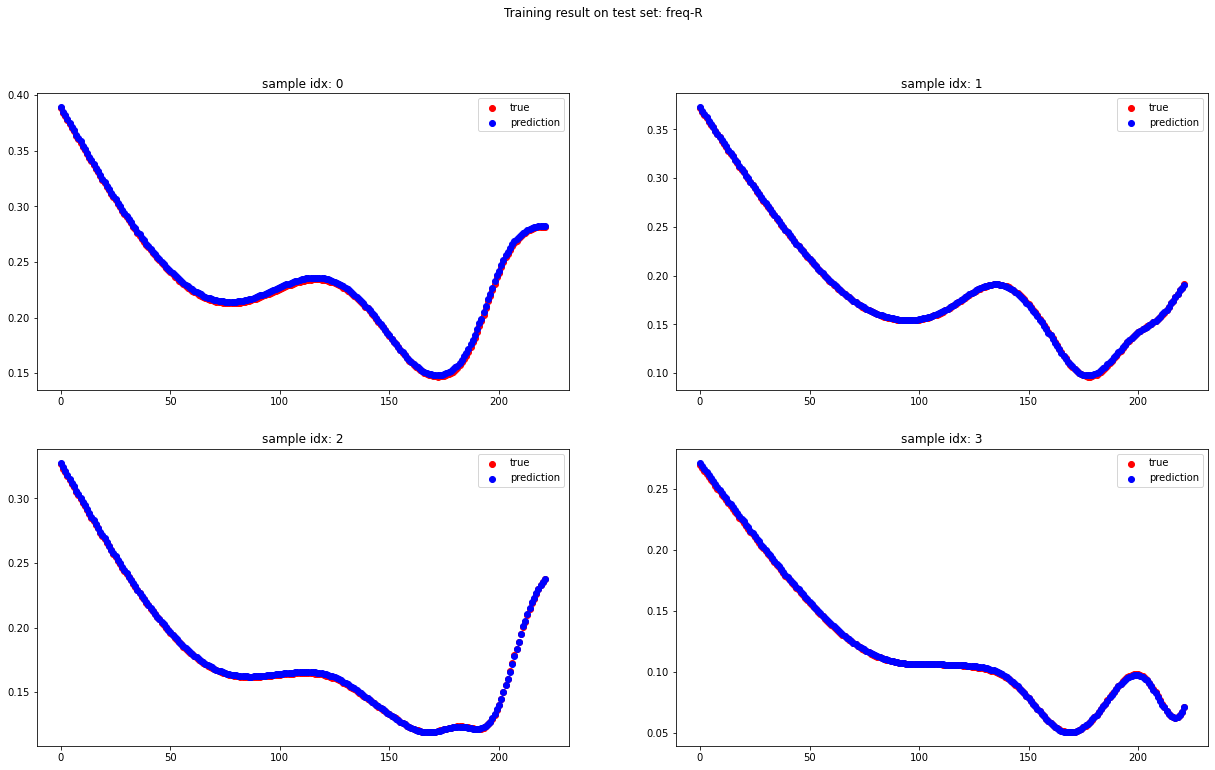

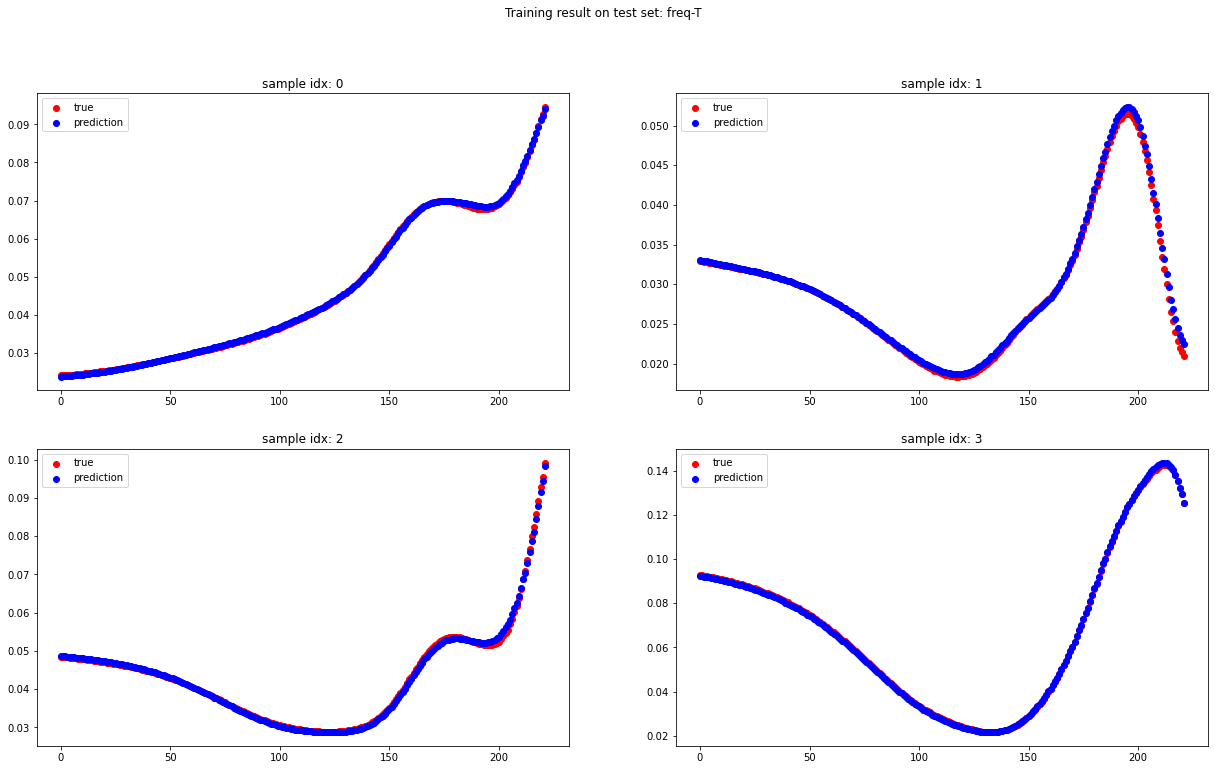

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [147. 121. 160.  75.]
 [146. 123. 160.  75.]
 [146. 120. 160.  75.]
 [147. 120. 160.  75.]
 [147. 122. 160.  75.]
 [145. 122. 160.  75.]
 [145. 123. 160.  75.]
 [146. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


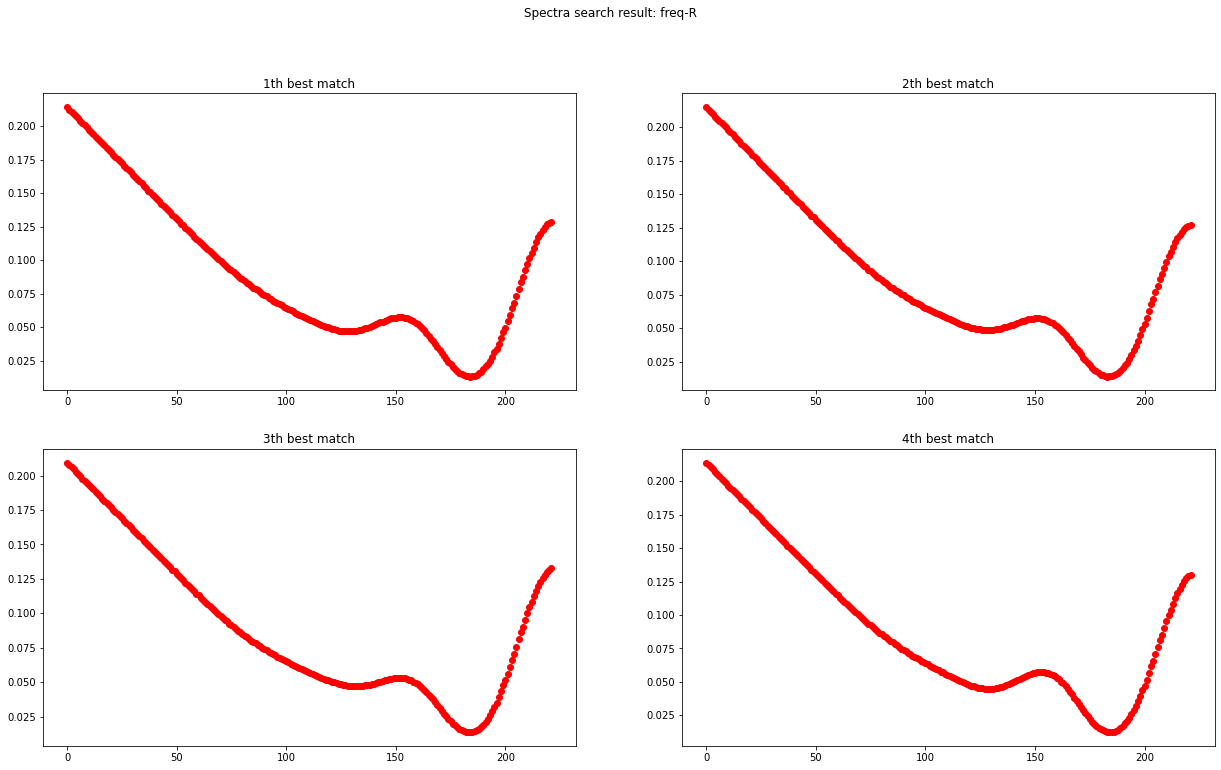

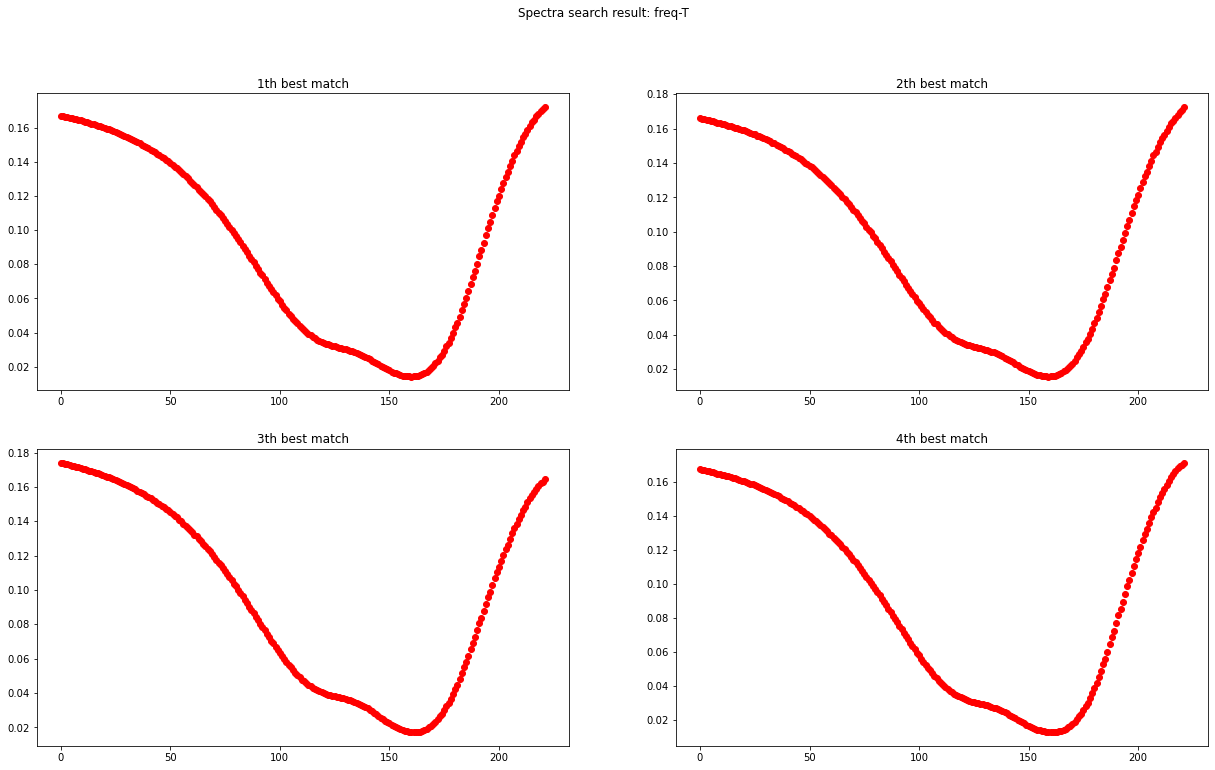

*** Reruning RCWA on picked params
params_dict.shape: (815, 4)
R_dict.shape: (815, 222)
T_dict.shape: (815, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
------------

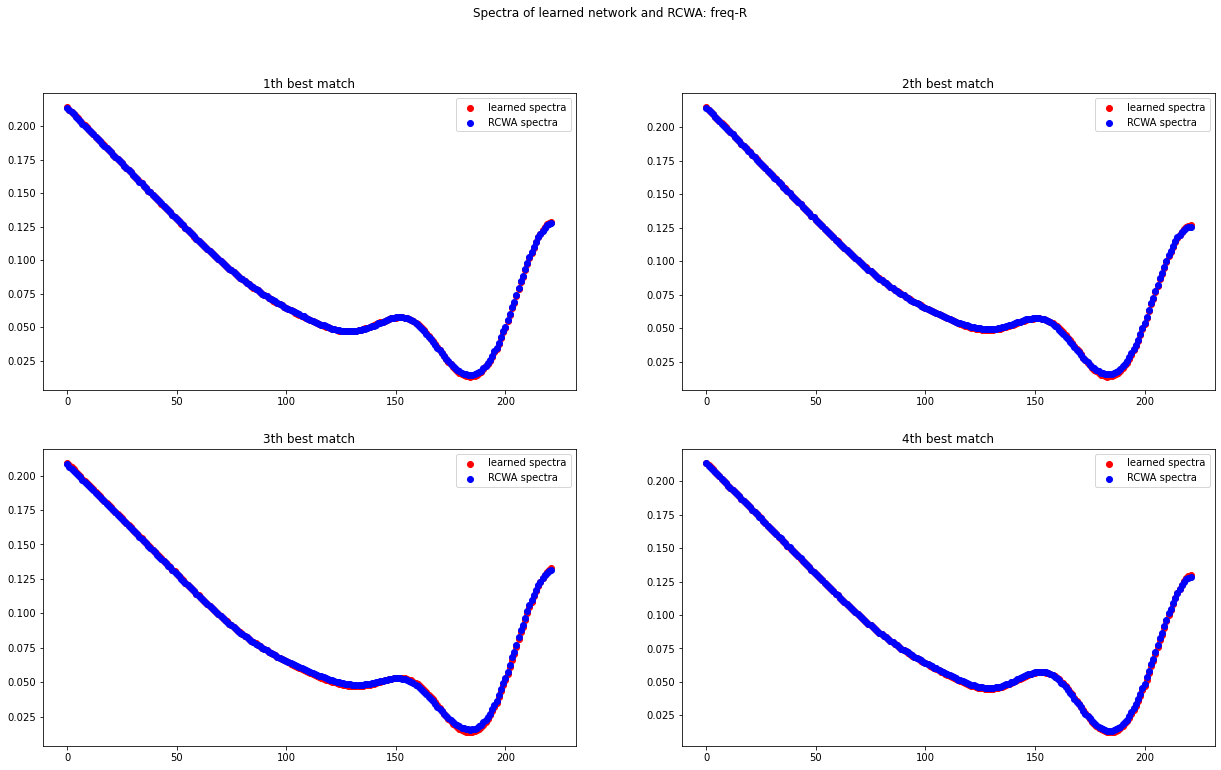

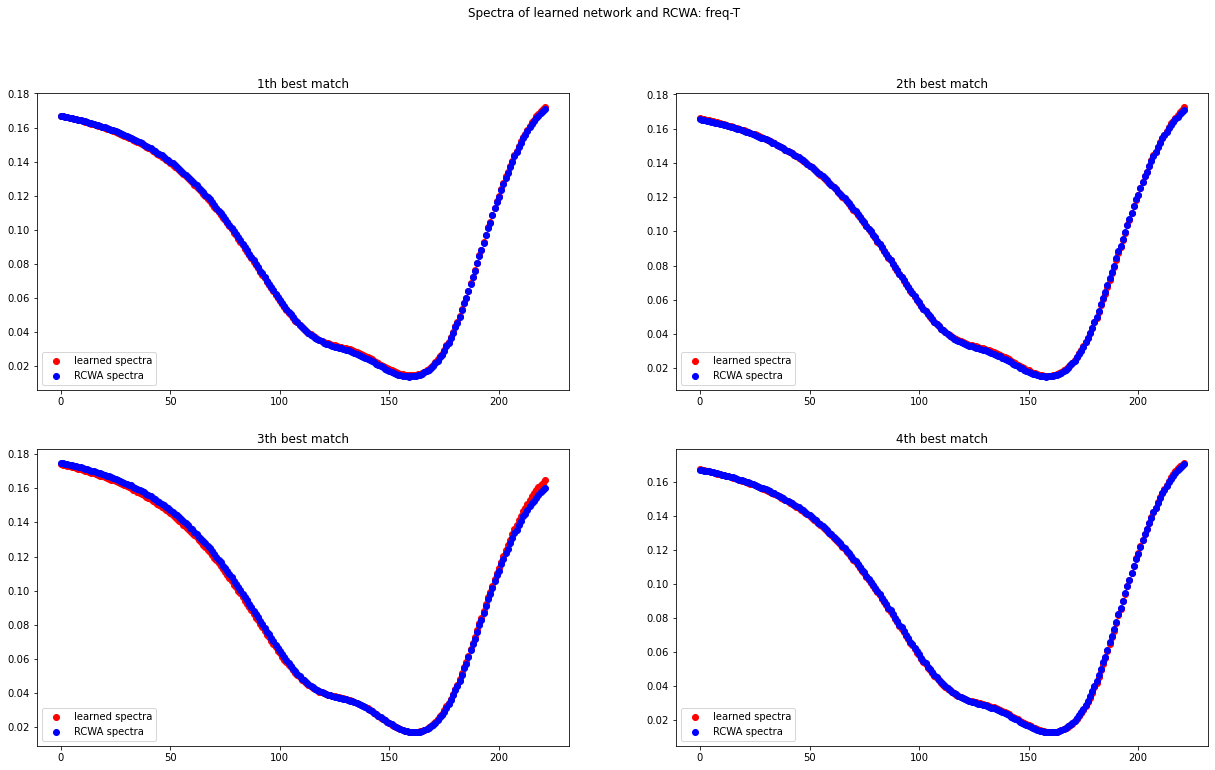

** Model saved.
**************************** ROUND 5 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1000
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [ 82. 107.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 53. 109.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 57. 109.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [91. 65.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [104.  69.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [144. 100.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [116.  74.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [124.  53.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [91. 69.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 79. 126.]
Calculation P

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [140.  59.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [130.  60.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [113. 111.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [120. 126.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [100.  87.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [127. 130.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [149.  88.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [100.  61.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 53. 115.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 97. 107.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [79. 67.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 92. 138.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 7.81101445186323e-05
### TEST LOSS  0.0001971387377125211
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 2.1482925537952724e-05
### TEST LOSS  6.164599926705705e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 6.850364441874035e-06
### TEST LOSS  6.24073002957933e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 6.949926796210093e-06
### TEST LOSS  1.866530534850123e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.1807174031986278e-05
### TEST LOSS  4.654835023150857e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 8.529756100642771e-06
### TEST LOSS  1.7089326835654598e-05
----------------------------------------------------------------------
*** 

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.9411385998182595e-06
### TEST LOSS  1.522925655687383e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.3940358431909771e-06
### TEST LOSS  1.3326468054704796e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.794957526567998e-06
### TEST LOSS  2.668697963296533e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.9765919422241042e-06
### TEST LOSS  1.038557316708951e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 3.4392451690905545e-06
### TEST LOSS  1.9023488372719537e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 6.075447474543694e-06
### TEST LOSS  1.332203188061006e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.0311046937943047e-06
### TEST LOSS  7.449628204388622e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.2508352969575753e-06
### TEST LOSS  9.576109808525266e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 7.748092315367217e-07
### TEST LOSS  5.540732729514275e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 8.191674490767298e-07
### TEST LOSS  9.92277261957497e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.0212087324177333e-06
### TEST LOSS  1.2694521084692194e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 7.705836930504973e-07
### TEST LOSS  2.043593462985882e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.633886738318551e-07
### TEST LOSS  4.3885641881994767e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.082188981011427e-07
### TEST LOSS  4.858648518772195e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 6.684460374444256e-07
### TEST LOSS  5.101905003357387e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.666673886428498e-07
### TEST LOSS  4.2188669340248454e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 7.084399210910419e-07
### TEST LOSS  1.6306790560823476e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.16997820958909e-07
### TEST LOSS  4.783955982171999e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 7.10915216949104e-07
### TEST LOSS  4.2956694793853484e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.531652862307169e-07
### TEST LOSS  6.829255691324457e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.308473033378447e-07
### TEST LOSS  4.1415235803773004e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 7.051349179008071e-07
### TEST LOSS  9.404642279757051e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 8.31714264567296e-07
### TEST LOSS  6.993486370750664e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 8.275128127053221e-07
### TEST LOSS  7.803059285530859e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.804854445405795e-07
### TEST LOSS  5.056287269174693e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.73640502388173e-07
### TEST LOSS  1.0001514662387005e-06
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 6.935511129100291e-07
### TEST LOSS  4.7117574316265137e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.766482297673292e-07
### TEST LOSS  4.680679220806875e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.9851801075107e-07
### TEST LOSS  7.838340214523972e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.863498776150777e-07
### TEST LOSS  4.981549068361347e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 7.30493933065901e-07
### TEST LOSS  4.831146365328701e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 6.355403765532231e-07
### TEST LOSS  6.836800973057204e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 8.371025562752266e-07
### TEST LOSS  4.1944826610536743e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.747699119034166e-07
### TEST LOSS  4.142104558013671e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.913819024208067e-07
### TEST LOSS  5.925534386127159e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.037457865100236e-07
### TEST LOSS  4.977872246551366e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.14373959134673e-07
### TEST LOSS  6.07582861296881e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.449970589204156e-07
### TEST LOSS  3.344923480123422e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.146272009284303e-07
### TEST LOSS  8.031752599890751e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 6.18892650145142e-07
### TEST LOSS  5.808228631091576e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.375519533572514e-07
### TEST LOSS  4.7191430970390985e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 5.644273688183432e-07
### TEST LOSS  5.972403926080005e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.752831813803482e-07
### TEST LOSS  3.9360523752899703e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 7.89724196449626e-07
### TEST LOSS  4.873627024911306e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.574237753229738e-07
### TEST LOSS  7.814310208686948e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 6.403004002422108e-07
### TEST LOSS  5.57380138843655e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 5.635550907072684e-07
### TEST LOSS  4.2020201931336485e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 5.905690754381965e-07
### TEST LOSS  4.650348159884743e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.190235464453963e-07
### TEST LOSS  4.4447811736366324e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.821608942859769e-07
### TEST LOSS  5.149131482085068e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.689562656527869e-07
### TEST LOSS  4.058860705905924e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.760023470566921e-07
### TEST LOSS  3.514635049365703e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.842050393456532e-07
### TEST LOSS  4.392186307692706e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.945812959995521e-07
### TEST LOSS  3.9193845774813477e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.232290573999876e-07
### TEST LOSS  3.773635228299099e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.5693898330867456e-07
### TEST LOSS  5.202852851956171e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 5.076605363392162e-07
### TEST LOSS  4.4389456850998005e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.6474764977588734e-07
### TEST LOSS  5.069526404592276e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.4575608868768767e-07
### TEST LOSS  4.918172786953316e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 7.514324617901025e-07
### TEST LOSS  6.627057094495588e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.280295090346442e-07
### TEST LOSS  4.10389668559219e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.6813082434482565e-07
### TEST LOSS  6.767057129763999e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 6.161182288941802e-07
### TEST LOSS  3.1192406027003015e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.546538858463123e-07
### TEST LOSS  4.3249072708325304e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.939548793494453e-07
### TEST LOSS  3.1811085534627635e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.800966923745875e-07
### TEST LOSS  4.542811041119421e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.5526223745895324e-07
### TEST LOSS  4.230810911091491e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.2791726847823954e-07
### TEST LOSS  4.319873246079927e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 5.80021467730063e-07
### TEST LOSS  3.707755733254695e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.31957976680053e-07
### TEST LOSS  5.628082078601437e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.709522213381945e-07
### TEST LOSS  3.366677844951482e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.6185849031843416e-07
### TEST LOSS  4.4235918229181455e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.3226494693726634e-07
### TEST LOSS  4.1948289701091806e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.395964966761312e-07
### TEST LOSS  4.791586320607167e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.279667262672149e-07
### TEST LOSS  3.7592373776836513e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.9661565711313076e-07
### TEST LOSS  6.158047426652047e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.625584211979117e-07
### TEST LOSS  3.1201920952147096e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.929789337284717e-07
### TEST LOSS  2.913561511756294e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.434366704337833e-07
### TEST LOSS  3.752027718443666e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.464282153548993e-07
### TEST LOSS  4.852842228804851e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.5089523200658733e-07
### TEST LOSS  4.4880252213867304e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 5.158072291493454e-07
### TEST LOSS  8.876641535001303e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.237822764459054e-07
### TEST LOSS  4.328784617276445e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.285488394408787e-07
### TEST LOSS  7.432365161245495e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.4185889987602423e-07
### TEST LOSS  3.607767496305314e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.5847258716236183e-07
### TEST LOSS  3.151339171836298e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.744048599434336e-07
### TEST LOSS  2.961902974144929e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.465427110851294e-07
### TEST LOSS  4.699451816729076e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.5378531036277534e-07
### TEST LOSS  4.4767788646519574e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 4.227108605228125e-07
### TEST LOSS  3.4524088619036777e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.8224609094683617e-07
### TEST LOSS  3.297438733322148e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 4.439830364972863e-07
### TEST LOSS  4.074382009851737e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.30862059953796e-07
### TEST LOSS  3.238142312511627e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 4.005559984214813e-07
### TEST LOSS  2.888272319978569e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.3719970319955334e-07
### TEST LOSS  5.694384393943134e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 4.790489631396611e-07
### TEST LOSS  6.266902308501206e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.965952234139536e-07
### TEST LOSS  3.127144613775575e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.030191939428107e-07
### TEST LOSS  4.129640615246899e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 4.3488852459461214e-07
### TEST LOSS  4.3278274688418603e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.172202963381721e-07
### TEST LOSS  3.9275138495516635e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.306433879399663e-07
### TEST LOSS  3.0071550346140913e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.770331582266806e-07
### TEST LOSS  1.1372768350762878e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.9443571278852117e-07
### TEST LOSS  3.9167979177060867e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.7857169407473635e-07
### TEST LOSS  2.9716766600055656e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 4.490259620375525e-07
### TEST LOSS  3.5110671205984543e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.683390304054512e-07
### TEST LOSS  3.403457848586792e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.9237391011326393e-07
### TEST LOSS  3.9496375544937713e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 4.236966514596929e-07
### TEST LOSS  4.0207392354811115e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 6.314931686688397e-07
### TEST LOSS  3.157494215126159e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 5.25299150101688e-07
### TEST LOSS  3.925289244458933e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 4.7504505509365915e-07
### TEST LOSS  4.1457725880415334e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.076966866950471e-07
### TEST LOSS  3.1184249849047774e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.746367951400487e-07
### TEST LOSS  3.6753812461635485e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.077256902732529e-07
### TEST LOSS  3.3343376533897146e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 4.3253616858862644e-07
### TEST LOSS  5.543439006790625e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.5106844584831266e-07
### TEST LOSS  4.760664921832358e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.4379930731986973e-07
### TEST LOSS  2.9804577745077646e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.799095680818709e-07
### TEST LOSS  3.114512461858491e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.69586183047943e-07
### TEST LOSS  4.850248747819327e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.9789437198578525e-07
### TEST LOSS  3.546378119760144e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.4088590102498984e-07
### TEST LOSS  2.6686142765205055e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.783962935433038e-07
### TEST LOSS  3.680399800032319e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.5382263287431217e-07
### TEST LOSS  4.1393816445634003e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.683699872636282e-07
### TEST LOSS  3.5054780293345783e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.7244178258077907e-07
### TEST LOSS  3.1085629264756184e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.645154222091662e-07
### TEST LOSS  3.166127764112995e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.715680139784183e-07
### TEST LOSS  2.7938925105293797e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.8716629195789663e-07
### TEST LOSS  3.796051487370278e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.8390079631156484e-07
### TEST LOSS  4.840096096359048e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.7826824486586476e-07
### TEST LOSS  4.671466664755523e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.74539096675619e-07
### TEST LOSS  6.913289894328045e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 4.247448488534644e-07
### TEST LOSS  4.466627350060056e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.680962792778075e-07
### TEST LOSS  2.7612475435034866e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.6038999655829683e-07
### TEST LOSS  9.936901240810889e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 4.6269989228875376e-07
### TEST LOSS  3.6674588272944674e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.436957104909766e-07
### TEST LOSS  2.8519399393189814e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.794653688800054e-07
### TEST LOSS  3.30275858573259e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.630106271526046e-07
### TEST LOSS  3.043489887962399e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.4587956242049243e-07
### TEST LOSS  5.871595855448201e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.7713424123708703e-07
### TEST LOSS  5.77586005571599e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.406497664997232e-07
### TEST LOSS  6.393813521299307e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 4.0595594861514427e-07
### TEST LOSS  3.888407993220729e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.541904330095491e-07
### TEST LOSS  2.549149106319722e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.7886787821150845e-07
### TEST LOSS  5.268995380447449e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.65122027204734e-07
### TEST LOSS  2.507572569735809e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.4285290098168277e-07
### TEST LOSS  2.7519324135028e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.4810535103702025e-07
### TEST LOSS  3.346613577074701e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 4.0485851764771043e-07
### TEST LOSS  3.205616375604829e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.5293048359896773e-07
### TEST LOSS  3.2160096642049514e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.74702482975664e-07
### TEST LOSS  3.5419923563040354e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.919641591103584e-07
### TEST LOSS  4.516799322118459e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 4.029952418953542e-07
### TEST LOSS  3.1655254228250367e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.4813950244583223e-07
### TEST LOSS  6.471805212034572e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 4.642128173450999e-07
### TEST LOSS  5.550850877019305e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 4.744261025066976e-07
### TEST LOSS  6.151113723262824e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 4.6897351558428115e-07
### TEST LOSS  6.500066130380826e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.552946428904136e-07
### TEST LOSS  2.8590272146781594e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.795547547440492e-07
### TEST LOSS  3.6216596299709636e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.5148238966264955e-07
### TEST LOSS  3.93417758459691e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.94486080224965e-07
### TEST LOSS  4.5320362005440986e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 4.0098493157358914e-07
### TEST LOSS  3.0446402566515947e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.714211677809942e-07
### TEST LOSS  3.1469846438388536e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 3.9248504917921425e-07
### TEST LOSS  2.465126016204522e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.486268993313502e-07
### TEST LOSS  4.851252318379314e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 4.1238107616692333e-07
### TEST LOSS  4.648703111342911e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.1961072232178365e-07
### TEST LOSS  3.0223280968281565e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.6229268571474905e-07
### TEST LOSS  5.139860737320608e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.38133717967537e-07
### TEST LOSS  4.30640911493659e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 3.46927648450901e-07
### TEST LOSS  4.332121079642093e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.400042333794318e-07
### TEST LOSS  2.984090447929096e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.555629206957178e-07
### TEST LOSS  3.4168550655522267e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.362599731193683e-07
### TEST LOSS  2.520261612441269e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.3761486844596787e-07
### TEST LOSS  2.79426704234235e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.371293300613587e-07
### TEST LOSS  2.911243986621533e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 3.509571668551814e-07
### TEST LOSS  2.775095017189718e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.5292574612100225e-07
### TEST LOSS  3.275018589950681e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.41989628040551e-07
### TEST LOSS  3.546589672017338e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.908542264845494e-07
### TEST LOSS  2.72151094312297e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.360143673738492e-07
### TEST LOSS  3.3682317071755584e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.45628752636884e-07
### TEST LOSS  3.1240715732868313e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 3.57806185217413e-07
### TEST LOSS  2.7061154526109024e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.4643919884480565e-07
### TEST LOSS  3.4742480086909685e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.3902944922203915e-07
### TEST LOSS  4.6885209599167864e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.2014610835418014e-07
### TEST LOSS  2.6570116252363125e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.3267587187069125e-07
### TEST LOSS  5.433749701448202e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.4372905874846536e-07
### TEST LOSS  2.338631171975673e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 3.3665137936722543e-07
### TEST LOSS  2.606513826700999e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 4.085714127874951e-07
### TEST LOSS  3.8175010672603096e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.4765875905051755e-07
### TEST LOSS  2.7996553058073915e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 4.085952963812645e-07
### TEST LOSS  2.5210764154811234e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.542702740340076e-07
### TEST LOSS  4.720489603945074e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.544204651966254e-07
### TEST LOSS  3.793514906647033e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.2941662309227124e-07
### TEST LOSS  3.53556475829464e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.9084706028269525e-07
### TEST LOSS  3.165440716657031e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.278429990807297e-07
### TEST LOSS  2.959285363128098e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.633641918021624e-07
### TEST LOSS  2.964716856013183e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.509911988324177e-07
### TEST LOSS  3.0865630170258857e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.2945040023690807e-07
### TEST LOSS  4.12393274018541e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 3.165168000514029e-07
### TEST LOSS  3.131418992552426e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 3.5064669663142925e-07
### TEST LOSS  3.1698708464015605e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.521560154595704e-07
### TEST LOSS  4.690292826126097e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.432255883843993e-07
### TEST LOSS  2.7718598119008673e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.3695603688599365e-07
### TEST LOSS  2.737168055470344e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.2205873673518683e-07
### TEST LOSS  2.333309491101924e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 3.339039671725885e-07
### TEST LOSS  4.600177779442068e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 3.595191865564118e-07
### TEST LOSS  3.120557740506532e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.479426727039936e-07
### TEST LOSS  3.517283384250428e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.680913097916516e-07
### TEST LOSS  3.0658960762745363e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.3312811636676544e-07
### TEST LOSS  3.202030294839157e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.4995698008444267e-07
### TEST LOSS  2.5524143723032464e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 3.226308293946545e-07
### TEST LOSS  4.100868655617281e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.374039427157527e-07
### TEST LOSS  3.2935542056596506e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.3631740124384636e-07
### TEST LOSS  2.652971555032006e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.717082028629193e-07
### TEST LOSS  2.6326001053197007e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.0560024967840604e-07
### TEST LOSS  3.629075346604319e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.3374358672588755e-07
### TEST LOSS  2.8888451500582356e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 3.177524041184654e-07
### TEST LOSS  2.392625901848078e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.364143355071292e-07
### TEST LOSS  3.1002677379395513e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 3.1436101346926646e-07
### TEST LOSS  2.40376668140622e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.6201467461083327e-07
### TEST LOSS  4.930015127987039e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.4554377847939577e-07
### TEST LOSS  2.96168652387981e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.2156867808552646e-07
### TEST LOSS  4.777385394542459e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 3.2901623630721135e-07
### TEST LOSS  3.1905686341815455e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 3.516938775174339e-07
### TEST LOSS  3.581289092835505e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 3.548048690404926e-07
### TEST LOSS  3.756923452632085e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.31423270658604e-07
### TEST LOSS  3.0768281173247184e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.6366853018776623e-07
### TEST LOSS  4.989296788456461e-07
** loss_train 3.6366853018776623e-07
** loss_test 4.989296788456461e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


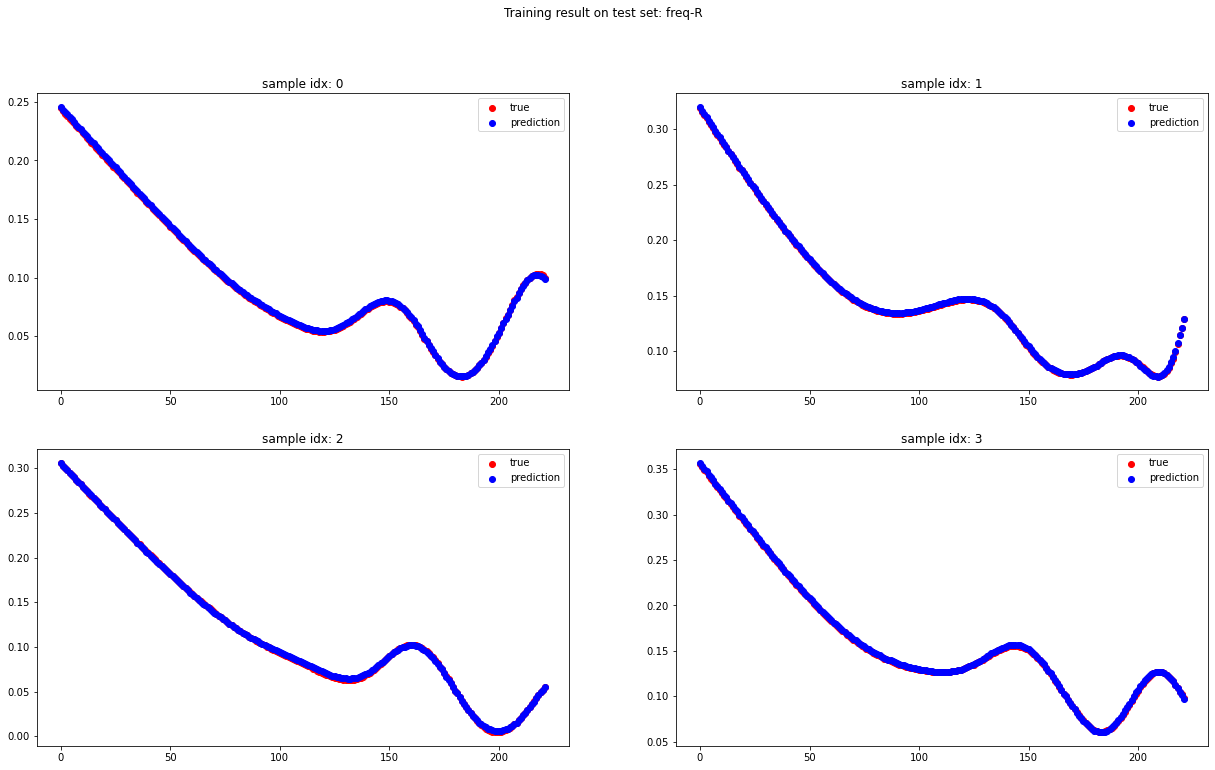

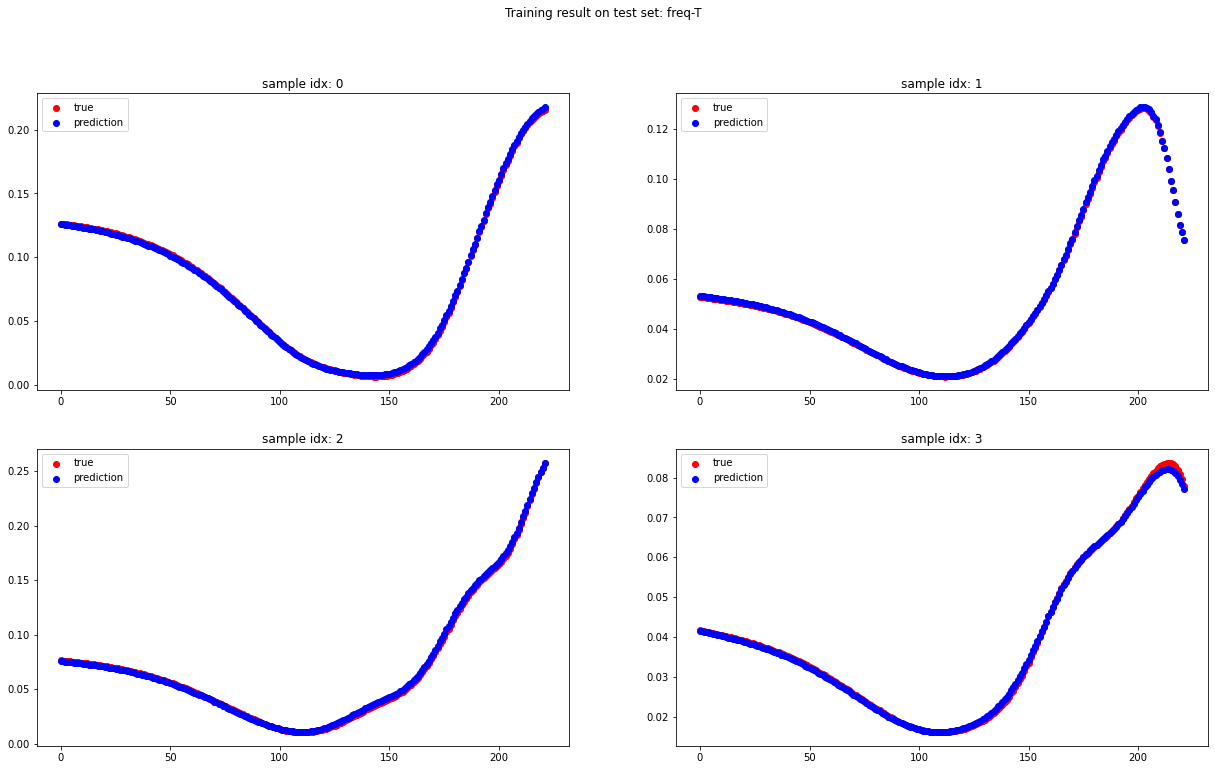

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [147. 121. 160.  75.]
 [147. 120. 160.  75.]
 [146. 122. 160.  75.]
 [147. 122. 160.  75.]
 [145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [146. 120. 160.  75.]
 [145. 123. 160.  75.]
 [146. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


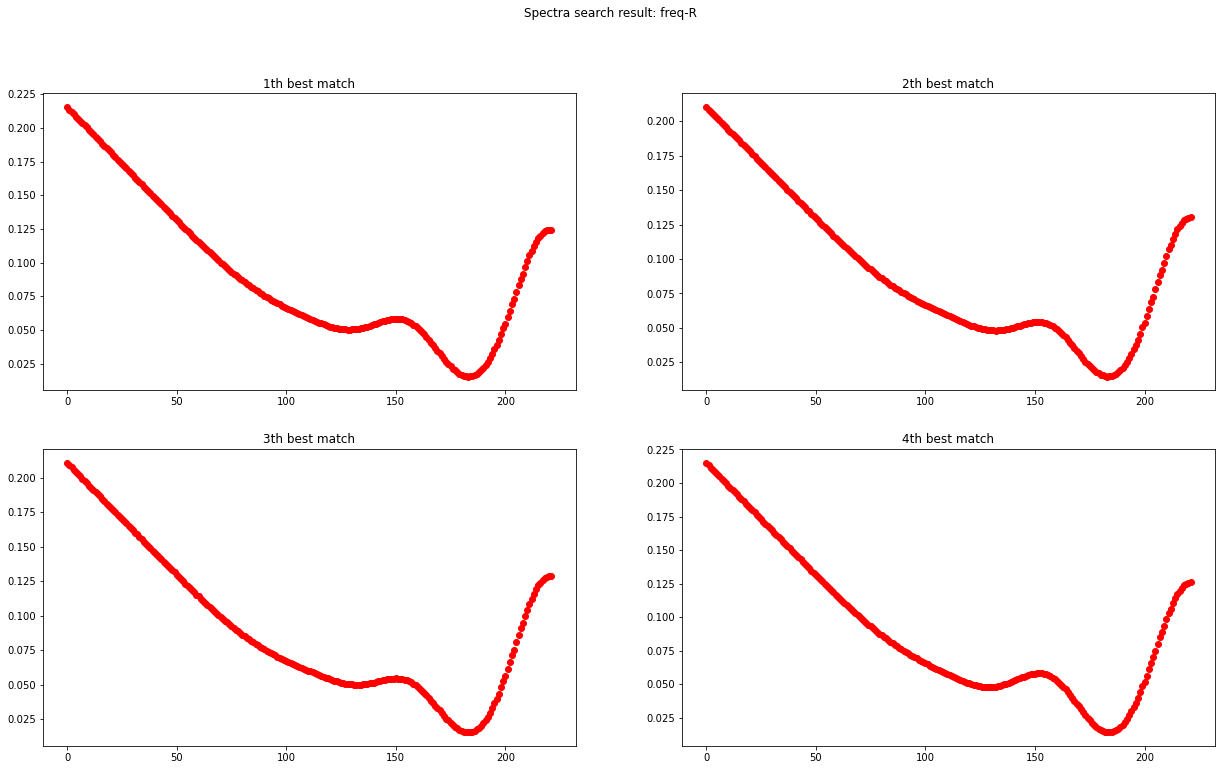

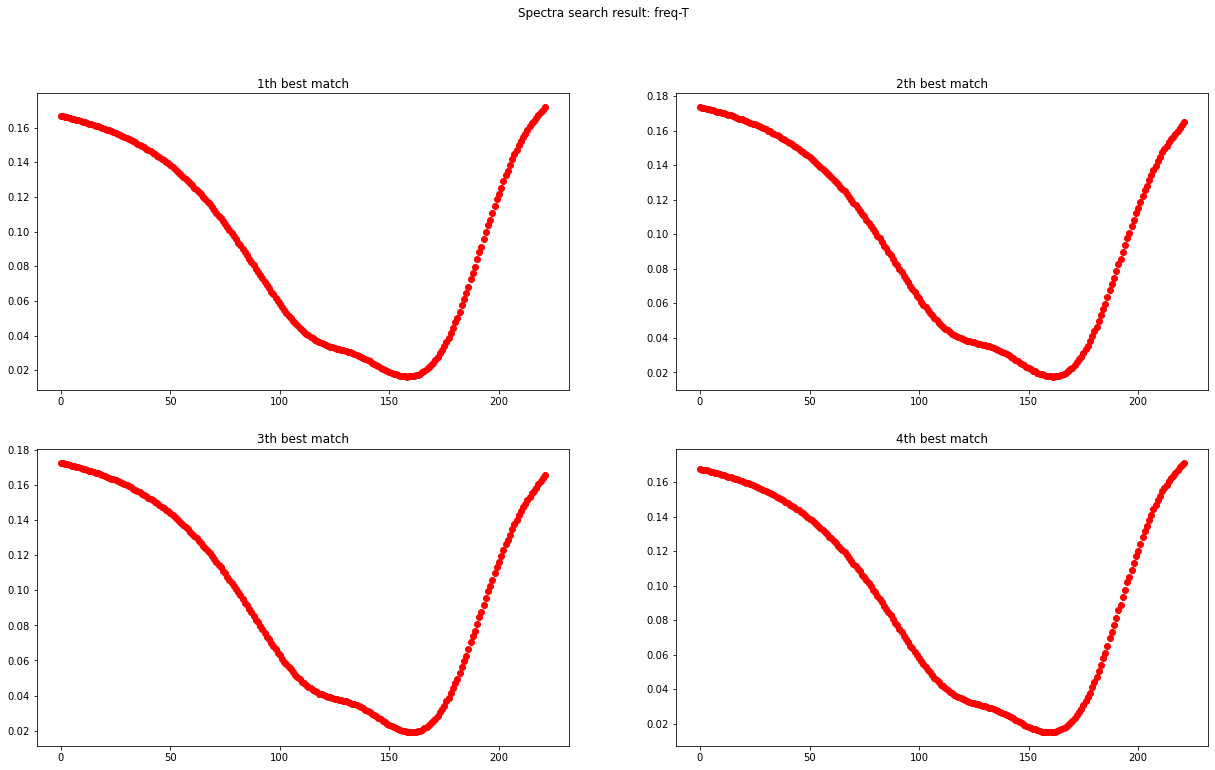

*** Reruning RCWA on picked params
params_dict.shape: (1016, 4)
R_dict.shape: (1016, 222)
T_dict.shape: (1016, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
---------

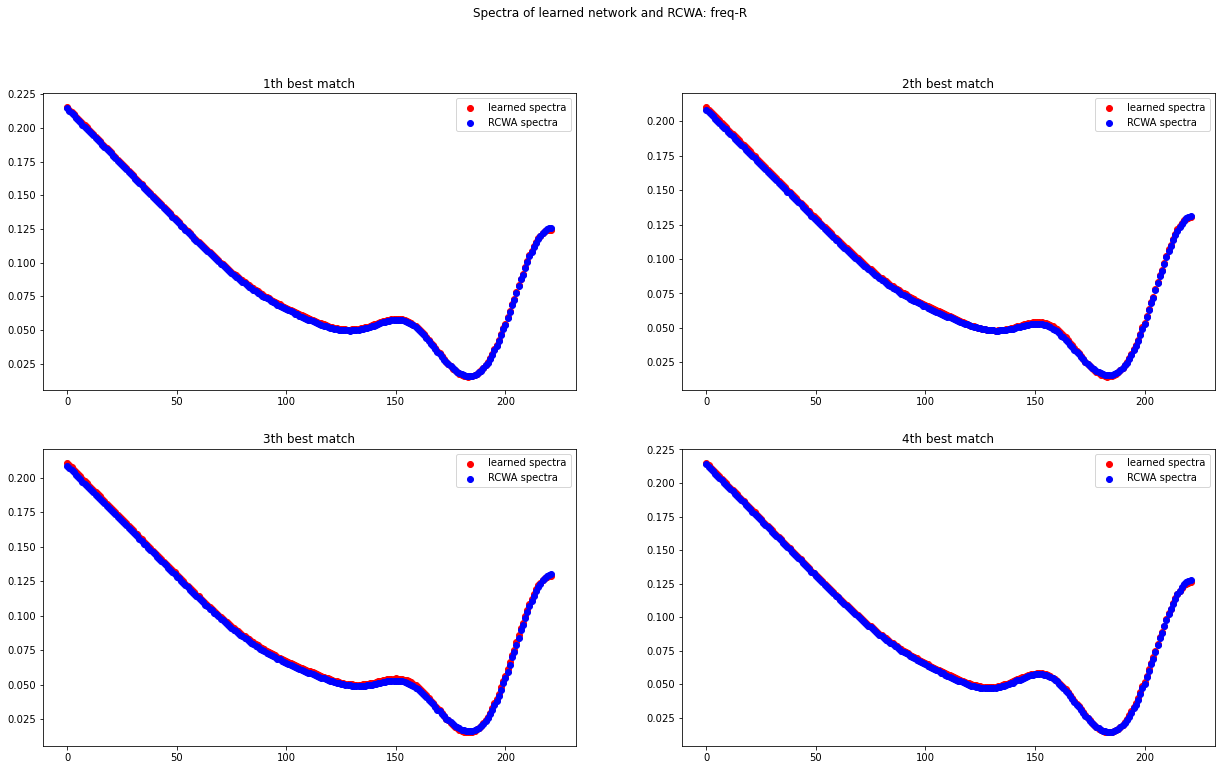

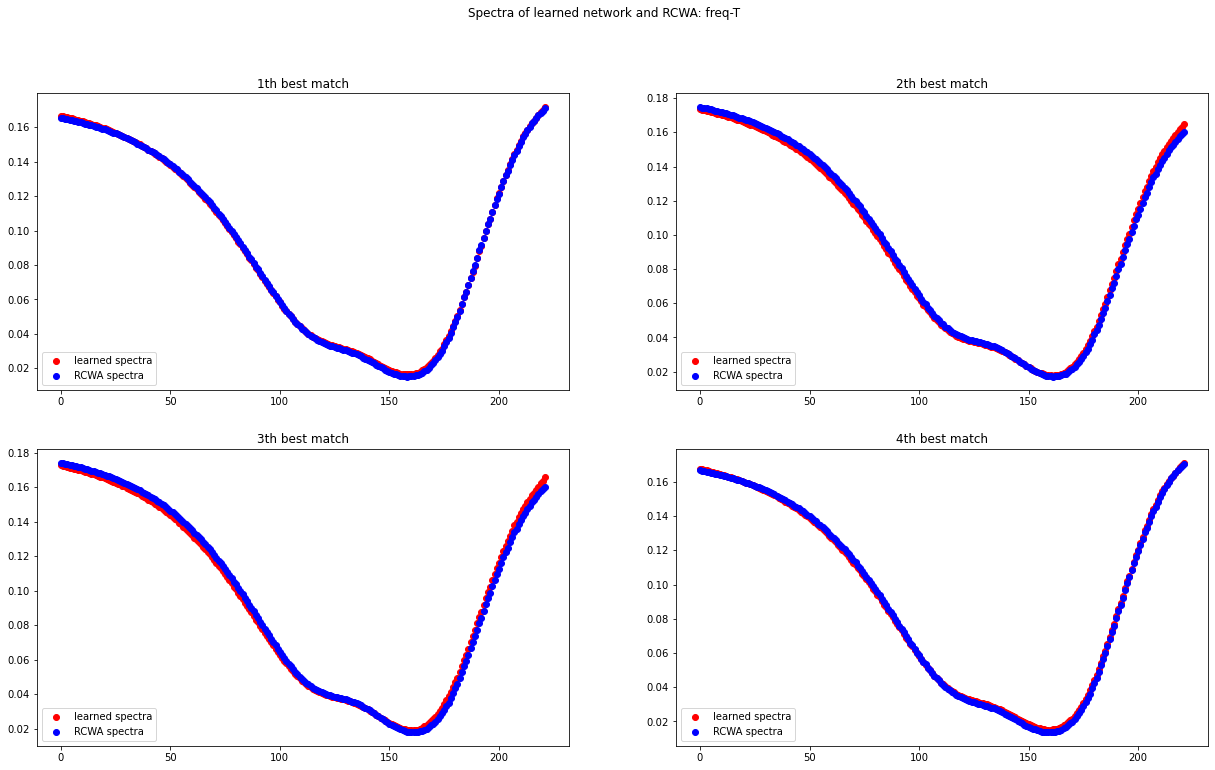

** Model saved.
**************************** ROUND 6 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [67. 93.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [86. 90.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 69. 123.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [114.  56.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 84. 117.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [110. 103.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [110.  57.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [115.  88.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [73. 91.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 73. 138.]
Calculation Pro

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [143.  72.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [121.  72.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [136.  80.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [95. 64.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [87. 61.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [138.  66.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [143.  68.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [121. 109.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 86. 118.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [126. 124.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [115.  71.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [116.  88.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 4.829049371721794e-05
### TEST LOSS  0.0001439397395491445
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 2.399170675095282e-05
### TEST LOSS  8.05359208142262e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 7.830561679161482e-06
### TEST LOSS  3.970212219428504e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.051742259787621e-05
### TEST LOSS  5.287311624771165e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 9.200113905194484e-06
### TEST LOSS  6.55803743635867e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 3.6262592776736825e-06
### TEST LOSS  7.12891464142255e-06
----------------------------------------------------------------------
*** EPO

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 2.19559709892773e-06
### TEST LOSS  1.209771925106098e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.1299046426908414e-06
### TEST LOSS  1.5462386563235163e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.1908316460385037e-06
### TEST LOSS  1.4284902773751028e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.2001424072707703e-06
### TEST LOSS  1.3430186148373953e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.1632864867057909e-06
### TEST LOSS  1.0488195951236573e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.0082064403900877e-06
### TEST LOSS  1.2718463532716366e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 9.975409730600405e-07
### TEST LOSS  5.263826084147796e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 8.217089441882782e-07
### TEST LOSS  5.557534371468541e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 8.629160836015615e-07
### TEST LOSS  8.572793856526712e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 7.813579800834229e-07
### TEST LOSS  1.3951459057655786e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 8.885783159525336e-07
### TEST LOSS  1.1210333765474288e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 9.60539985683795e-07
### TEST LOSS  7.489395462319711e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.471377299721581e-07
### TEST LOSS  6.462340549104637e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.345699211747104e-07
### TEST LOSS  1.065574098093849e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.409813196831057e-07
### TEST LOSS  5.320512078318037e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.708427378221415e-07
### TEST LOSS  5.346715773334331e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.707302411198176e-07
### TEST LOSS  6.843592801588885e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 8.899612147968602e-07
### TEST LOSS  6.704938060566848e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 1.01126115694683e-06
### TEST LOSS  5.736102019050627e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 7.936205894824392e-07
### TEST LOSS  1.4548952044100993e-06
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.390143840621458e-07
### TEST LOSS  8.490062302573481e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.130580025261641e-07
### TEST LOSS  6.202204395498888e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.238332883630922e-07
### TEST LOSS  4.840293886192942e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.578622644364372e-07
### TEST LOSS  5.274218513780701e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.725757969384422e-07
### TEST LOSS  6.730559710553684e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.771424754662784e-07
### TEST LOSS  6.166919222197167e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.878840065835315e-07
### TEST LOSS  5.390522438296507e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.433849460582488e-07
### TEST LOSS  3.9435359155959304e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.627098039677018e-07
### TEST LOSS  4.778868350917442e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.015120231831854e-07
### TEST LOSS  5.713777840002068e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 7.760304757849686e-07
### TEST LOSS  4.787857190219963e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.527102126201555e-07
### TEST LOSS  4.921396655138071e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.528068404814235e-07
### TEST LOSS  4.29356747291523e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.374946046613853e-07
### TEST LOSS  6.05323350555409e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.584915359957421e-07
### TEST LOSS  5.957715671911501e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.775437979504971e-07
### TEST LOSS  4.440612539408701e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.016604866566373e-07
### TEST LOSS  5.059890876661181e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.838775584443567e-07
### TEST LOSS  5.433398908078541e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.992271000968922e-07
### TEST LOSS  4.613485281702702e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 6.19823152228823e-07
### TEST LOSS  3.960849694648358e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.451875275053197e-07
### TEST LOSS  3.974567306386234e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 6.162073370674648e-07
### TEST LOSS  4.634652981394538e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 6.707728336271164e-07
### TEST LOSS  1.3256983240555403e-06
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 5.38480457521473e-07
### TEST LOSS  5.967317914862886e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.951209717025563e-07
### TEST LOSS  5.865600058996279e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 6.806349735229607e-07
### TEST LOSS  4.805135663193344e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 6.983419386171382e-07
### TEST LOSS  4.3211137463256614e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 6.06331179368406e-07
### TEST LOSS  7.131577698752759e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.372931700087235e-07
### TEST LOSS  8.253991299827451e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.232245678736073e-07
### TEST LOSS  5.022204858404519e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.834519810932192e-07
### TEST LOSS  7.016731460554284e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 5.080886045908765e-07
### TEST LOSS  4.0059178571836026e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 5.359210140791031e-07
### TEST LOSS  4.04171972137293e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.938998179178829e-07
### TEST LOSS  3.701274238210317e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.320609343832198e-07
### TEST LOSS  3.5123685885688854e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.7001618010966693e-07
### TEST LOSS  4.037475965409006e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 5.275252825409638e-07
### TEST LOSS  8.660877376264075e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 5.193396406788508e-07
### TEST LOSS  3.7758832939339805e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.854988428319255e-07
### TEST LOSS  5.459118044528724e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.5866098109748065e-07
### TEST LOSS  4.5822842290969373e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 5.198819232325272e-07
### TEST LOSS  4.1070038037105405e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.52351795493892e-07
### TEST LOSS  9.306531201976517e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 5.30602132275959e-07
### TEST LOSS  4.1440860027503527e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 5.962616042376467e-07
### TEST LOSS  5.301247717347401e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 5.440420307441703e-07
### TEST LOSS  3.54824933879172e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.470739544482072e-07
### TEST LOSS  5.426473500670504e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 5.140097453685636e-07
### TEST LOSS  3.3831463023640634e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.3533228068604045e-07
### TEST LOSS  3.534343685866285e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.0357262734621223e-07
### TEST LOSS  5.115744541070752e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.814174761769153e-07
### TEST LOSS  3.83296760257205e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.5996384477220433e-07
### TEST LOSS  4.5096299080190266e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.571631864032829e-07
### TEST LOSS  4.288581484009531e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 5.136849318176928e-07
### TEST LOSS  5.74199726581052e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.5417811084173347e-07
### TEST LOSS  4.0277764412621764e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.288740675513954e-07
### TEST LOSS  5.68844312296177e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 5.063123738284029e-07
### TEST LOSS  3.735050345059992e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.7021118151135964e-07
### TEST LOSS  3.142888402862809e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 4.593198943562508e-07
### TEST LOSS  3.3492814408317725e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.7245588795578424e-07
### TEST LOSS  5.255627399947116e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.550784212250155e-07
### TEST LOSS  3.8924838147775313e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 5.713701187352409e-07
### TEST LOSS  7.436034050240576e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 5.906165870713428e-07
### TEST LOSS  5.702003910022945e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.770433053765307e-07
### TEST LOSS  3.3667862137715724e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.885307638632004e-07
### TEST LOSS  5.346618697406788e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.7652409691956164e-07
### TEST LOSS  3.496629151161162e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.4468342278669583e-07
### TEST LOSS  4.784174194583102e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.188876811580163e-07
### TEST LOSS  3.8334274974103107e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.883034568070599e-07
### TEST LOSS  5.254326696204872e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.3500066381578033e-07
### TEST LOSS  3.328246154726205e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 4.177978378165174e-07
### TEST LOSS  4.30883575732979e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.985230850656052e-07
### TEST LOSS  5.88376094709828e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 4.443900248999692e-07
### TEST LOSS  3.6980381897440867e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.502846260656668e-07
### TEST LOSS  3.802186243875541e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.9588751772493916e-07
### TEST LOSS  5.792828119410842e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.154353786341621e-07
### TEST LOSS  4.059954711187351e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 5.583648434400364e-07
### TEST LOSS  3.281432543960566e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.725993404175455e-07
### TEST LOSS  3.534082916682261e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.4748646134943706e-07
### TEST LOSS  3.50641330884274e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 4.1166738640482e-07
### TEST LOSS  3.918763790503969e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.72404757928165e-07
### TEST LOSS  3.5835320172989464e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.1053945234163316e-07
### TEST LOSS  3.779776768119013e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 4.213357936026322e-07
### TEST LOSS  3.264756769125496e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 4.073017533408792e-07
### TEST LOSS  6.985703875115076e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.963248742018995e-07
### TEST LOSS  3.640093382273335e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 4.003248685139719e-07
### TEST LOSS  3.774170017499677e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 4.095314083437292e-07
### TEST LOSS  4.841423033339096e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 4.0873578265987476e-07
### TEST LOSS  3.136434582668496e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 4.018801806034607e-07
### TEST LOSS  4.2784773452492823e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.7620672490632123e-06
### TEST LOSS  4.652805898786028e-06
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.037152838924508e-06
### TEST LOSS  5.717786185262715e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.1225860629663724e-06
### TEST LOSS  4.739550389684963e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 5.441594921506976e-07
### TEST LOSS  4.2536852618013654e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 4.792810308954879e-07
### TEST LOSS  4.6467700166709216e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.6741690925481784e-07
### TEST LOSS  4.850600877009331e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.903490538181842e-07
### TEST LOSS  3.3041730142081684e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 4.413054204495855e-07
### TEST LOSS  5.997507644097924e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 4.126414267998276e-07
### TEST LOSS  3.199313919961039e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 6.055037518611547e-07
### TEST LOSS  4.328447210531926e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 4.985172007465621e-07
### TEST LOSS  4.028268926327251e-07
----------------------------------------------------------------------
*** EPOCH 1066 || AVG LOSS 3.8329862801352494e-07
### TEST LOSS  3.0901839507022385e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 4.0037139593292654e-07
### TEST LOSS  3.4379704535088723e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.916987681969649e-07
### TEST LOSS  3.475039499613154e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.055087291613783e-07
### TEST LOSS  3.5980349208683845e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.964643472809115e-07
### TEST LOSS  4.3866683085980185e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 4.319659918916585e-07
### TEST LOSS  3.9806996059926155e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 3.833547165991528e-07
### TEST LOSS  3.8038356819924957e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 4.3224754332567745e-07
### TEST LOSS  4.2755394405149775e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.999776413543543e-07
### TEST LOSS  2.8397754587356553e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 4.0550022457767434e-07
### TEST LOSS  3.5650671274349105e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.7013634774041293e-07
### TEST LOSS  4.6575836639325036e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 4.348184687419376e-07
### TEST LOSS  4.070132430595347e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 4.1991022502685383e-07
### TEST LOSS  2.9177213889397535e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.735696333340144e-07
### TEST LOSS  3.1259742251500535e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 4.239442318472915e-07
### TEST LOSS  4.0216643210694906e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 4.292977881004134e-07
### TEST LOSS  4.5623917957174046e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 4.029504358834165e-07
### TEST LOSS  3.498520331706661e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.9561909920789635e-07
### TEST LOSS  2.88347064743751e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 4.159319717800258e-07
### TEST LOSS  4.1086533839360425e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.5359073404350737e-07
### TEST LOSS  2.6314553104435214e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.7913662653229116e-07
### TEST LOSS  4.917841367715583e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.7776844380961923e-07
### TEST LOSS  3.140856882232078e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.5258681062503665e-07
### TEST LOSS  2.977931935611701e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 4.095729787234603e-07
### TEST LOSS  3.2053066531842785e-07
----------------------------------------------------------------------
*** EPOCH 1275 || AVG LOSS 3.8901197830417307e-07
### TEST LOSS  3.393040128369446e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.9616048988240964e-07
### TEST LOSS  2.274507795934571e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.381219798163452e-07
### TEST LOSS  3.880626719718647e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.6040475519823664e-07
### TEST LOSS  3.6610249133496433e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.6203808529755576e-07
### TEST LOSS  4.527551880073588e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 4.0453543220131394e-07
### TEST LOSS  2.5128503248576334e-07
----------------------------------------------------------------------
*** EPOCH 1327 || AVG LOSS 4.203909757638513e-07
### TEST LOSS  3.773638799960584e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 4.1423252399160524e-07
### TEST LOSS  4.283302988344278e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.457579084020779e-07
### TEST LOSS  2.6302791648428564e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.43941034725385e-07
### TEST LOSS  2.794548545163404e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.4739921516665126e-07
### TEST LOSS  3.443663779813101e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.490835595343356e-07
### TEST LOSS  3.503395475945581e-07
----------------------------------------------------------------------
*** EPOCH 1379 || AVG LOSS 4.1280073308946897e-07
### TEST LOSS  3.2678302848883806e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.847628369690881e-07
### TEST LOSS  3.8706181094817617e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.6200973446180267e-07
### TEST LOSS  5.551077511730303e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.5839325319623563e-07
### TEST LOSS  3.3275629757806905e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.820951119060112e-07
### TEST LOSS  4.2925008535298224e-07
----------------------------------------------------------------------
*** EPOCH 1431 || AVG LOSS 3.47283523574049e-07
### TEST LOSS  2.9687391705440154e-07
----------------------------------------------------------------------
*** EPOCH 1432 || AVG LOSS 4.6612347068375473e-07
### TEST LOSS  5.066532793307488e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.830602577536979e-07
### TEST LOSS  3.2723437707697184e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.257888713648072e-07
### TEST LOSS  3.5323126863002267e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.667164320919625e-07
### TEST LOSS  4.12501328305047e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 4.675434599032968e-07
### TEST LOSS  6.650950612967993e-07
----------------------------------------------------------------------
*** EPOCH 1483 || AVG LOSS 3.9866787774567316e-07
### TEST LOSS  2.657566050680139e-07
----------------------------------------------------------------------
*** EPOCH 1484 || AVG LOSS 3.820427643782172e-07
### TEST LOSS  5.111011679067209e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.129001178159285e-07
### TEST LOSS  2.57795748205404e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.3825645264329294e-07
### TEST LOSS  8.204955324547175e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 4.022592958404421e-07
### TEST LOSS  2.761552330020499e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.662548393309114e-07
### TEST LOSS  2.3231925341507224e-07
----------------------------------------------------------------------
*** EPOCH 1535 || AVG LOSS 3.2114623566966334e-07
### TEST LOSS  2.8061833587697845e-07
----------------------------------------------------------------------
*** EPOCH 1536 || AVG LOSS 3.400608414298271e-07
### TEST LOSS  3.056212863030952e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.827644968357191e-06
### TEST LOSS  1.7032902361633105e-06
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.0662094319744428e-06
### TEST LOSS  1.0125965527802489e-06
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.2235583430270843e-06
### TEST LOSS  1.18887370743121e-06
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 1.0282913635162317e-06
### TEST LOSS  7.469953939360291e-07
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 5.935078931370204e-07
### TEST LOSS  4.786493563971009e-07
----------------------------------------------------------------------
*** EPOCH 1588 || AVG LOSS 5.030993873026782e-07
### TEST LOSS  1.0914354030925704e-06
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.5038800470103365e-07
### TEST LOSS  3.295544104275905e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.3748850934619177e-07
### TEST LOSS  3.4325980083041134e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.7601098900867195e-07
### TEST LOSS  4.5037050237321335e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.4431709073690086e-07
### TEST LOSS  2.9396745304666183e-07
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 3.561000341001375e-07
### TEST LOSS  2.4031450054609297e-07
----------------------------------------------------------------------
*** EPOCH 1640 || AVG LOSS 3.360339019190898e-07
### TEST LOSS  2.3551867024530617e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.2233466873569464e-07
### TEST LOSS  3.582658555008796e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.0244999055758133e-07
### TEST LOSS  4.944434945425908e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.3470103289949074e-07
### TEST LOSS  3.7373421611795897e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 4.0711203799818447e-07
### TEST LOSS  4.6626874134542754e-07
----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 3.304809454895974e-07
### TEST LOSS  3.2405948976096016e-07
----------------------------------------------------------------------
*** EPOCH 1692 || AVG LOSS 3.115286285530298e-07
### TEST LOSS  3.5362744515370855e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.182375180621477e-07
### TEST LOSS  3.840727952959039e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.6823174282811047e-07
### TEST LOSS  2.3824378874653323e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.8578220482736e-07
### TEST LOSS  3.327883643717339e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.037081587198287e-07
### TEST LOSS  2.4141666996355423e-07
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 3.455039049704567e-07
### TEST LOSS  2.3022726243956035e-07
----------------------------------------------------------------------
*** EPOCH 1744 || AVG LOSS 3.401058570121999e-07
### TEST LOSS  3.8378318676121933e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.143939312414782e-07
### TEST LOSS  3.7536101002741714e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.798591565207232e-07
### TEST LOSS  2.493883531289814e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.0617285384041775e-07
### TEST LOSS  2.673110373052623e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.4202015750217643e-07
### TEST LOSS  3.1976474603981035e-07
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 3.589848225378963e-07
### TEST LOSS  3.1856300747929504e-07
----------------------------------------------------------------------
*** EPOCH 1796 || AVG LOSS 3.142911253443496e-07
### TEST LOSS  3.6773388798236636e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.446019619405642e-07
### TEST LOSS  2.973544768438943e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.268103632247943e-07
### TEST LOSS  3.0025805525863484e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.5116566922492134e-07
### TEST LOSS  2.83967696961756e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 4.22713482040038e-07
### TEST LOSS  7.112156007830587e-07
----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 3.537695799001502e-07
### TEST LOSS  2.6502454394024727e-07
----------------------------------------------------------------------
*** EPOCH 1848 || AVG LOSS 3.147461934253452e-07
### TEST LOSS  2.852110077987567e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.6043379788205005e-07
### TEST LOSS  4.372527702874625e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.157245842840458e-07
### TEST LOSS  3.0697602208344205e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.1816459113246745e-07
### TEST LOSS  2.371794375714368e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 3.134943646572926e-07
### TEST LOSS  2.5952325917918034e-07
----------------------------------------------------------------------
*** EPOCH 1899 || AVG LOSS 3.1692606513959255e-07
### TEST LOSS  3.2437331596055526e-07
----------------------------------------------------------------------
*** EPOCH 1900 || AVG LOSS 3.1656495166121344e-07
### TEST LOSS  2.714361081580642e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.3390606890707867e-07
### TEST LOSS  2.904539810641735e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.395955838284929e-07
### TEST LOSS  3.0332573667616697e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.919780010405641e-07
### TEST LOSS  3.1978526572452716e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 3.3104196630162617e-07
### TEST LOSS  2.8872636666695445e-07
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 3.070273769386252e-07
### TEST LOSS  3.0207739598608896e-07
----------------------------------------------------------------------
*** EPOCH 1952 || AVG LOSS 2.973286252435277e-07
### TEST LOSS  5.863226246244974e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.2442323756320944e-07
### TEST LOSS  2.0084446658883178e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.383705207079165e-07
### TEST LOSS  2.873221636908359e-07
** loss_train 3.383705207079165e-07
** loss_test 2.873221636908359e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


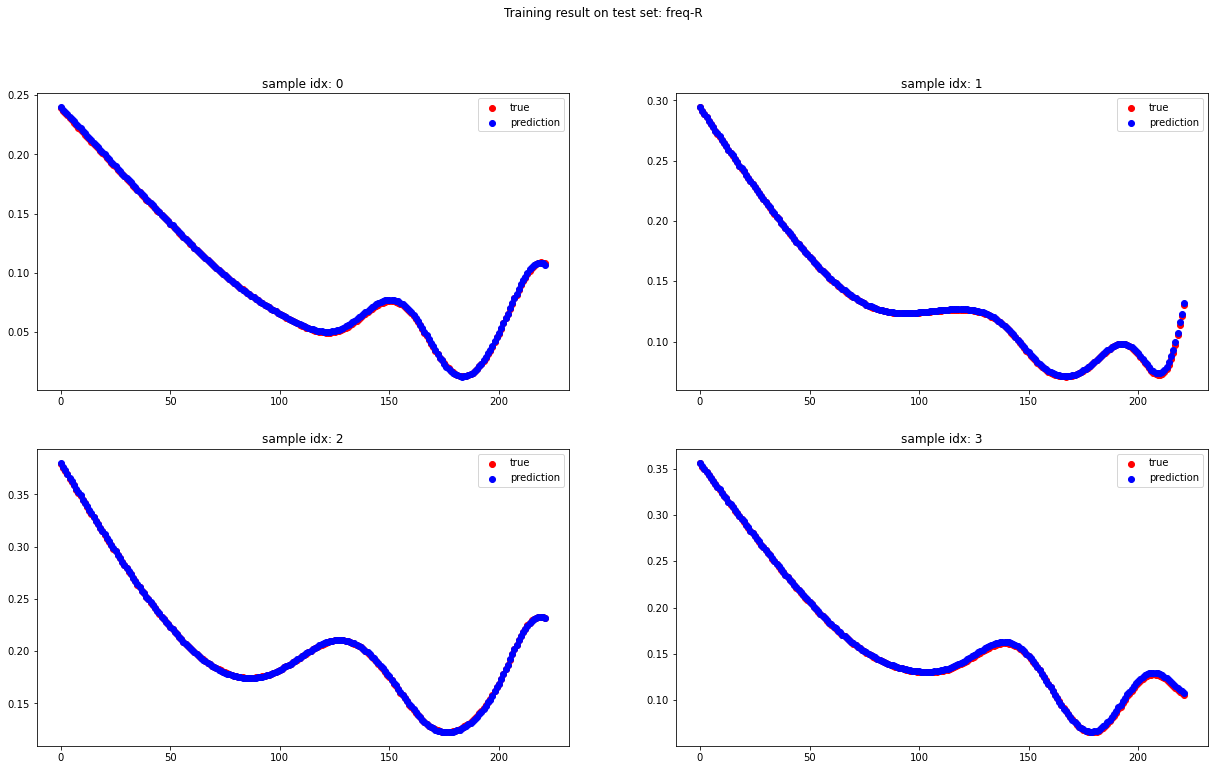

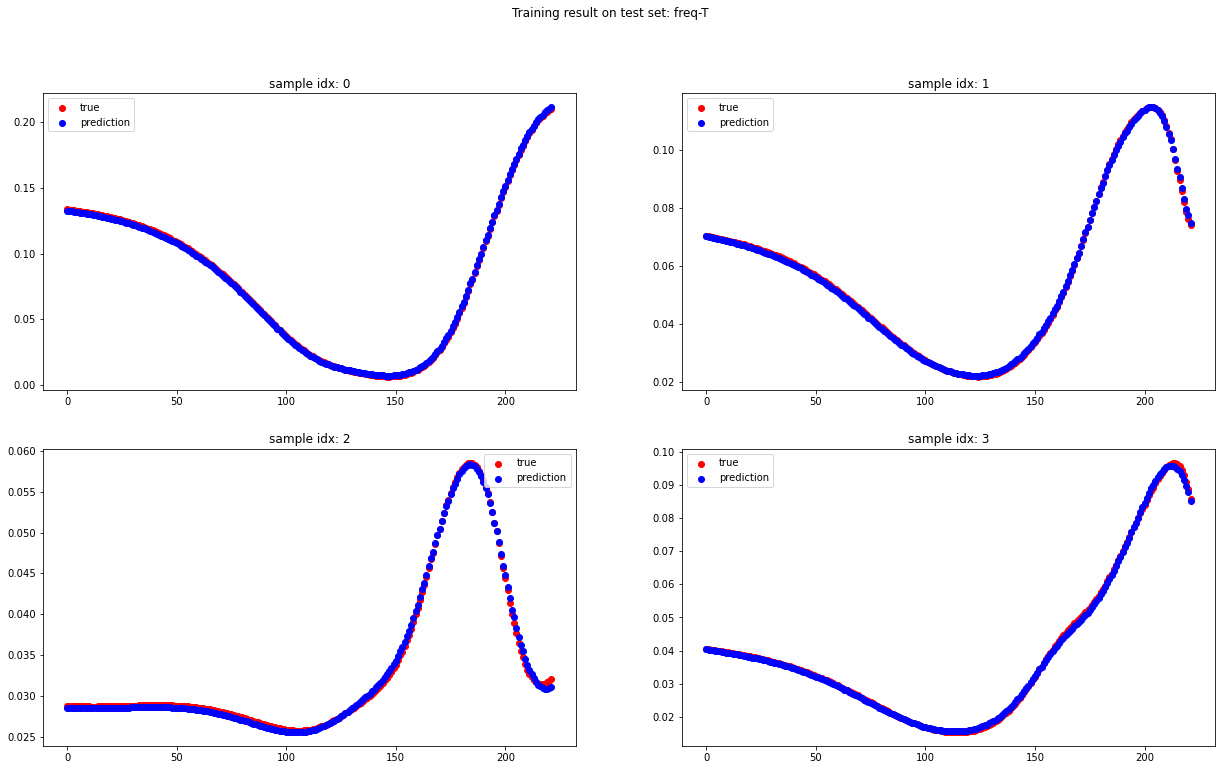

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 123. 160.  75.]
 [146. 121. 160.  75.]
 [145. 123. 160.  75.]
 [145. 122. 160.  75.]
 [145. 121. 160.  75.]
 [146. 120. 160.  75.]
 [147. 123. 160.  75.]
 [147. 122. 160.  75.]
 [147. 121. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


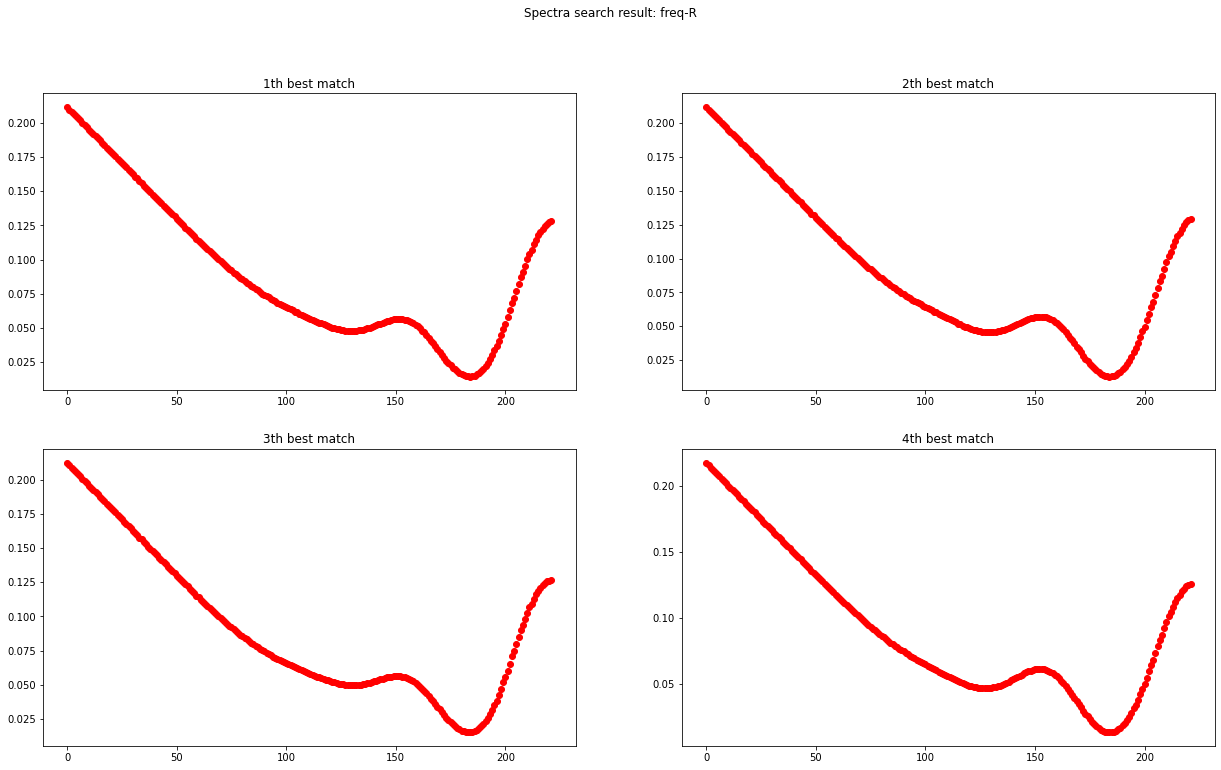

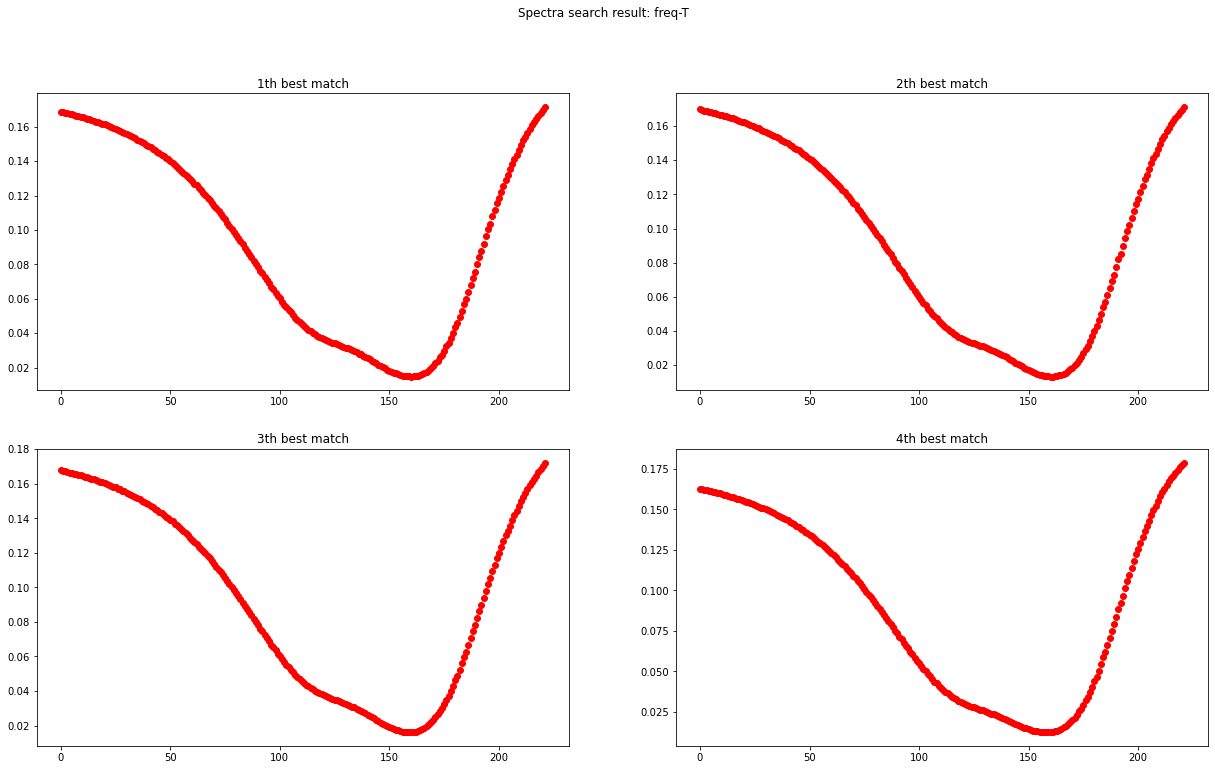

*** Reruning RCWA on picked params
params_dict.shape: (1216, 4)
R_dict.shape: (1216, 222)
T_dict.shape: (1216, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
---------

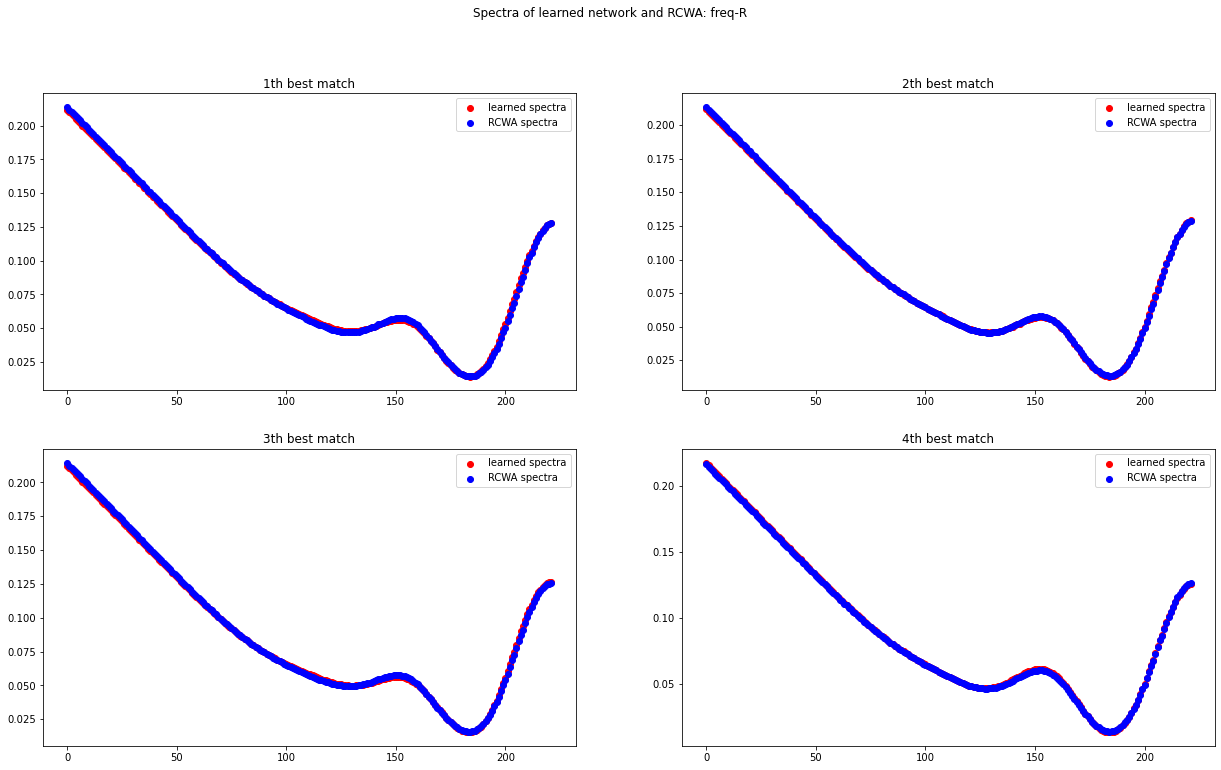

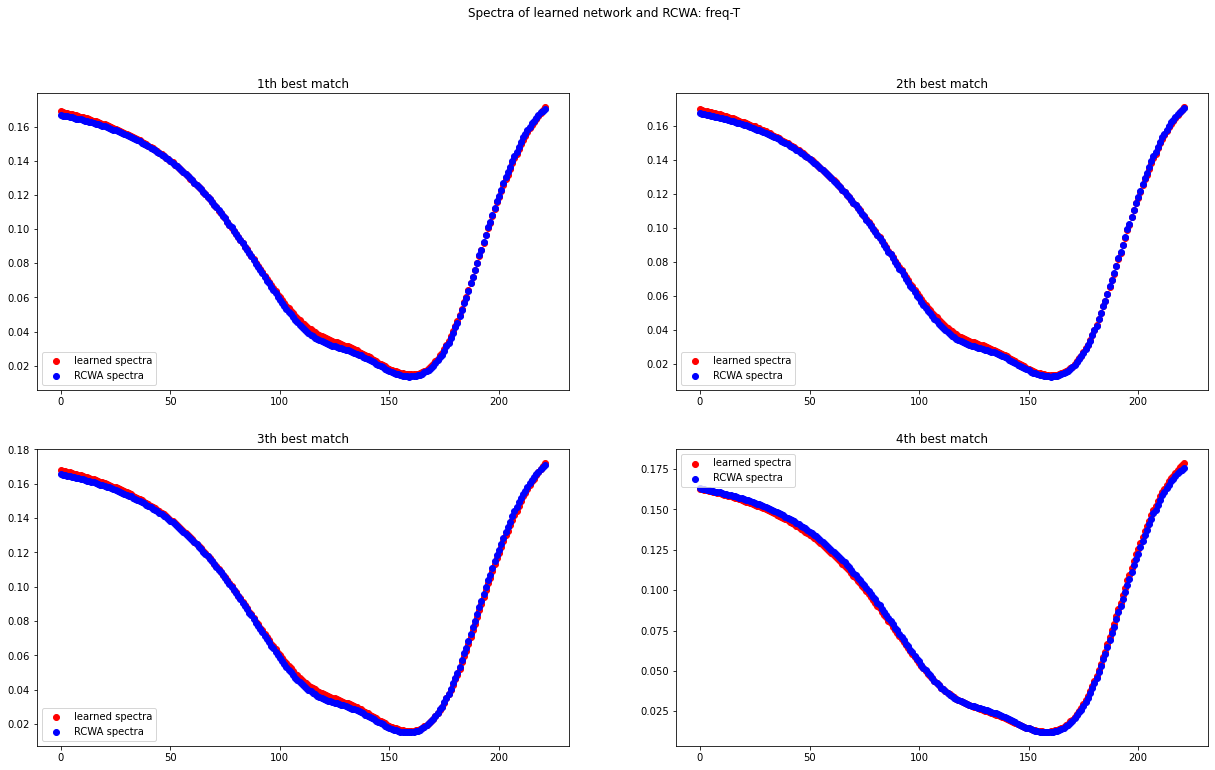

** Model saved.
**************************** ROUND 7 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1400
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [110. 127.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [149.  96.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [66. 87.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [111.  69.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [146. 106.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [87. 99.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [61. 75.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [66. 96.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [98. 69.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 99. 125.]
Calculation Progres

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [147. 130.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [54. 79.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [105. 139.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 58. 136.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 96. 108.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 52. 146.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [133. 146.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [128.  93.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [149. 136.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [112.  55.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [131. 114.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 66. 110.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 4.086491440619154e-05
### TEST LOSS  0.0001478638716269581
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 9.177199488752713e-06
### TEST LOSS  1.6721111121982673e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.217851913352888e-06
### TEST LOSS  2.892790586305306e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 6.3487497123406095e-06
### TEST LOSS  4.771530050427166e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.3946637057102862e-05
### TEST LOSS  3.4214837114632246e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 7.045146023675183e-06
### TEST LOSS  4.866604740527691e-06
----------------------------------------------------------------------
*

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.2120868660149751e-06
### TEST LOSS  2.610655769785808e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 3.35716472835352e-06
### TEST LOSS  9.122000040985189e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.528105762161098e-06
### TEST LOSS  1.230107128239152e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.798586059916626e-06
### TEST LOSS  1.0441118728398247e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.313310880800397e-06
### TEST LOSS  7.475257449000723e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 9.071982472314792e-07
### TEST LOSS  7.625033540328083e-07
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.7566034039516256e-06
### TEST LOSS  8.775620740793371e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.0688198830623362e-06
### TEST LOSS  5.746653299483611e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.2204820075924414e-06
### TEST LOSS  6.175325314540135e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 8.334372575902193e-07
### TEST LOSS  4.7645371833740763e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 7.613515657389769e-07
### TEST LOSS  6.313404102539525e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.0262834239225884e-06
### TEST LOSS  1.1458453276315017e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.831311690166948e-07
### TEST LOSS  8.521306850442753e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.052425876517841e-07
### TEST LOSS  4.559366741122259e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 9.93062307580926e-07
### TEST LOSS  2.0589496071724254e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.520021644730994e-07
### TEST LOSS  7.904613581062718e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.107053582787054e-07
### TEST LOSS  6.375536866120125e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.702659746884016e-07
### TEST LOSS  6.9026892258638e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 7.318677143659207e-07
### TEST LOSS  4.6311941401003504e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.555585172852975e-07
### TEST LOSS  5.484455814749626e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 7.530869443529907e-07
### TEST LOSS  8.683325082808385e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 7.27732116198508e-07
### TEST LOSS  7.766185664660373e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.654993813651596e-07
### TEST LOSS  4.945689724422664e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.253847345024813e-07
### TEST LOSS  5.818544185455142e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.945725996792313e-07
### TEST LOSS  4.732999550262982e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.357738609378113e-07
### TEST LOSS  9.65171388791284e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 7.571634973656062e-07
### TEST LOSS  1.1142397976403695e-06
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 6.923121281105742e-07
### TEST LOSS  5.362294824739035e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.154116713880902e-07
### TEST LOSS  7.071209931940426e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.590261461728427e-07
### TEST LOSS  7.219684722382557e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 1.7358297622647814e-06
### TEST LOSS  1.6897714167705338e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 1.6664108106009426e-06
### TEST LOSS  1.424427377504468e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 6.655671895496238e-07
### TEST LOSS  8.238879781236558e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.862966280467674e-07
### TEST LOSS  4.5711868197754896e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.580057209389874e-07
### TEST LOSS  5.247198515689888e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 6.243860945584093e-07
### TEST LOSS  6.47035537068322e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 1.1566940303962626e-06
### TEST LOSS  5.060305273797315e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.430126149783981e-07
### TEST LOSS  4.2641861015950283e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.271691836610565e-07
### TEST LOSS  4.7317110133090784e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.821915025437257e-07
### TEST LOSS  5.412843080421226e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.974678100109843e-07
### TEST LOSS  5.338974101608652e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 6.326922831359891e-07
### TEST LOSS  5.779231070267666e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.136167907008168e-07
### TEST LOSS  2.7508231199972627e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.190354528508879e-07
### TEST LOSS  5.106093396989309e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.735666493222879e-07
### TEST LOSS  4.0444237470183e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 6.875355728855733e-07
### TEST LOSS  5.993865334568743e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 6.635603920805977e-06
### TEST LOSS  8.30136559670791e-06
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.607724103153178e-06
### TEST LOSS  2.3495250512827295e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.341670747492239e-07
### TEST LOSS  3.8941946976158515e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.5949734684112644e-07
### TEST LOSS  6.511221900237533e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.676682671827288e-07
### TEST LOSS  3.579225714195838e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 9.630974172404803e-07
### TEST LOSS  3.626975432718444e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 5.07101739304667e-07
### TEST LOSS  4.777479525521564e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.6649555253602637e-06
### TEST LOSS  5.618690979955235e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 9.471588661824626e-07
### TEST LOSS  2.93032318087295e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.335326198009836e-07
### TEST LOSS  3.8599463698057496e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.50456001822427e-07
### TEST LOSS  4.0121521620180417e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.1154859448206645e-07
### TEST LOSS  3.480973356834676e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.685478892138154e-07
### TEST LOSS  4.487610490080194e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.3264864805690554e-07
### TEST LOSS  3.3696830505711906e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.473186669124678e-07
### TEST LOSS  3.9226717195684946e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 5.716765976617109e-07
### TEST LOSS  4.2389190081270167e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.821484817212657e-07
### TEST LOSS  2.573633889436554e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.352706915459034e-07
### TEST LOSS  3.229331617469391e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.9983541200478663e-07
### TEST LOSS  2.811951663840194e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.061400987317601e-07
### TEST LOSS  5.011380156102777e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.216102950773047e-07
### TEST LOSS  4.85093768144328e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.35335390014708e-07
### TEST LOSS  5.209123204704983e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.840709880201846e-07
### TEST LOSS  4.0249640097623673e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.3808134099622616e-07
### TEST LOSS  5.614780850361388e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.145432776070379e-07
### TEST LOSS  2.993927245918051e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.866562922765533e-07
### TEST LOSS  2.7173358383627355e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.0646295747594404e-07
### TEST LOSS  2.689201827686041e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.8074550292778653e-07
### TEST LOSS  6.599927302049351e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.372089391070842e-07
### TEST LOSS  3.7933953804399195e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.012488381961126e-07
### TEST LOSS  3.0209357116849456e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.048898475973926e-07
### TEST LOSS  2.660543068280028e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.9178751021598907e-07
### TEST LOSS  3.4789265480516074e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.4994453701668084e-07
### TEST LOSS  4.4314023481009907e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 5.6959233892785375e-06
### TEST LOSS  2.013982096245441e-06
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.1499824677054643e-06
### TEST LOSS  6.284593261150142e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 6.450863604255476e-07
### TEST LOSS  5.605805713767867e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.819194546915437e-07
### TEST LOSS  3.120471793687846e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 5.510734274315e-07
### TEST LOSS  4.249643016475023e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.678661217725627e-07
### TEST LOSS  2.8875122059058744e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 5.761446228724765e-07
### TEST LOSS  2.694429429471835e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.173091892109174e-07
### TEST LOSS  4.120720895819183e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.814820672611217e-07
### TEST LOSS  2.7607663936764354e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.2674642589446423e-07
### TEST LOSS  3.561912222949104e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.834526811655589e-07
### TEST LOSS  4.001835985821923e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.624442028714116e-07
### TEST LOSS  2.979285292006104e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.852081524894199e-07
### TEST LOSS  3.8036468843281246e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.4640853956499235e-07
### TEST LOSS  3.1400289754205085e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.415166019290642e-07
### TEST LOSS  3.055184517496524e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.360757684259649e-07
### TEST LOSS  2.653804461839503e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.8477501313646405e-07
### TEST LOSS  4.137638724573249e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.60641267021273e-07
### TEST LOSS  3.0889300652668017e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.7649303420142893e-07
### TEST LOSS  2.54810446036076e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.529690168946331e-07
### TEST LOSS  3.917349651125981e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.6357367725463924e-07
### TEST LOSS  3.987137517924566e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 9.033934152645275e-07
### TEST LOSS  6.550202610614261e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 4.553001134434607e-07
### TEST LOSS  2.6668913832850194e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 4.026115382263892e-07
### TEST LOSS  5.937752353640297e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.706251092872037e-07
### TEST LOSS  3.125349030080377e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.4477397319828845e-07
### TEST LOSS  4.0397957108821586e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.8337943160675944e-07
### TEST LOSS  5.484170912950503e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.7041232553087463e-07
### TEST LOSS  3.0469621815531023e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.671884190557608e-07
### TEST LOSS  5.454624853613992e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.452242736961304e-07
### TEST LOSS  2.803115774244444e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.2581688277894776e-07
### TEST LOSS  3.7296269991574344e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 6.891324121787486e-07
### TEST LOSS  5.660756879809593e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 9.461143582661131e-07
### TEST LOSS  1.8358568871173537e-06
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 1.777744017254739e-06
### TEST LOSS  8.191570011397495e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.1770455996821576e-06
### TEST LOSS  6.509527888841727e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 6.442057967781523e-07
### TEST LOSS  6.409736786591483e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.994962024402225e-07
### TEST LOSS  4.11393216381839e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.6045008888890044e-07
### TEST LOSS  3.113639686282774e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.1376192931809045e-07
### TEST LOSS  4.6379953485856357e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.440700974900933e-07
### TEST LOSS  2.582829471913845e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.1727798239344906e-07
### TEST LOSS  2.49673537279126e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.3353888836882916e-07
### TEST LOSS  2.916763034735678e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 6.987756497649806e-07
### TEST LOSS  2.697905485278666e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.8046785983323974e-07
### TEST LOSS  4.604169490107779e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 4.1905094662096433e-07
### TEST LOSS  3.8304148442979236e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.359626397728529e-07
### TEST LOSS  4.583045784494805e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 3.91200349082307e-07
### TEST LOSS  3.4026743539977194e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.324968723740694e-07
### TEST LOSS  3.4106602503863376e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.5569887962541964e-07
### TEST LOSS  3.305788231438617e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.76582448541488e-07
### TEST LOSS  4.951317474809581e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.4265462825493793e-07
### TEST LOSS  3.6487081574291963e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.147544974296019e-07
### TEST LOSS  2.83214004975269e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 3.3628834047354824e-07
### TEST LOSS  3.5959363163907587e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.4507991819968504e-07
### TEST LOSS  2.8546145552416585e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.2696576165288807e-07
### TEST LOSS  2.5903558506260277e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.488522098634864e-07
### TEST LOSS  3.1694517200652295e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 4.5864439309032234e-07
### TEST LOSS  4.848420293125276e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.655463851462823e-07
### TEST LOSS  2.427333999254312e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 3.1209202625147114e-07
### TEST LOSS  3.368771485606265e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.4233039910601193e-07
### TEST LOSS  5.125742487424841e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.369549204127306e-07
### TEST LOSS  3.464002253524127e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.294681097898433e-07
### TEST LOSS  3.964119098430853e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.2127516052733137e-07
### TEST LOSS  2.7241316386488795e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 4.483335455037921e-07
### TEST LOSS  3.9352217129362543e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.1876972987581503e-07
### TEST LOSS  4.6141387987187377e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.24330638013594e-07
### TEST LOSS  3.3775471179482835e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.238723750520478e-07
### TEST LOSS  2.8881296804622086e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.4291560067956085e-07
### TEST LOSS  2.708605438525327e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.0116233081959163e-07
### TEST LOSS  5.511905307933127e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.7013854353570457e-07
### TEST LOSS  3.466263565469903e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.3230690799460456e-07
### TEST LOSS  9.98300283651009e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.5332222616594647e-06
### TEST LOSS  6.479579752749487e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 8.335868520717834e-07
### TEST LOSS  3.870043046431833e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 4.0175231045682024e-07
### TEST LOSS  2.4230835810550905e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.3962137414990575e-07
### TEST LOSS  2.6836457193853264e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.299562209159644e-07
### TEST LOSS  3.1774126328023366e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.061275340649721e-07
### TEST LOSS  2.1545919375915384e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.135263382527041e-07
### TEST LOSS  7.145267398362359e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.272048395405339e-07
### TEST LOSS  4.706347609002974e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.097840743139711e-07
### TEST LOSS  2.8586385396196917e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.1045798240013156e-07
### TEST LOSS  4.1811123387767357e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.9580978696383145e-07
### TEST LOSS  2.67657917163433e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.1712803395375237e-07
### TEST LOSS  3.522831306668195e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.310029740763046e-07
### TEST LOSS  2.827695585562072e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.0162075115874085e-07
### TEST LOSS  6.420165822811957e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.9606799347651046e-07
### TEST LOSS  2.5940183302385444e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.0345697572288696e-07
### TEST LOSS  2.794241993342439e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.131402106428181e-07
### TEST LOSS  2.5995986971142054e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 2.887074476021212e-07
### TEST LOSS  2.280314300213087e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.8042264094175136e-07
### TEST LOSS  4.6972202095606586e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 8.882244489097754e-07
### TEST LOSS  2.9468491517677237e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.7436057582646804e-07
### TEST LOSS  3.762755085290337e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.6654053647008516e-07
### TEST LOSS  4.374366669294845e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.9664180461228075e-07
### TEST LOSS  2.9803729649880883e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.351624307867951e-07
### TEST LOSS  2.57595514535131e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.774982049264963e-07
### TEST LOSS  4.3215402844122186e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.983394074946537e-07
### TEST LOSS  4.5161545937265724e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.0796878945947374e-07
### TEST LOSS  2.603065005566598e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.0400200415670045e-07
### TEST LOSS  2.8941415308736396e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.257700999879733e-07
### TEST LOSS  4.0690703170556925e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.430418602360216e-07
### TEST LOSS  4.406623255383899e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.8661584275724297e-07
### TEST LOSS  5.02111702034695e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.298376688221083e-07
### TEST LOSS  2.3491200451530858e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.787252303017494e-07
### TEST LOSS  2.473542954300518e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.5359883833281053e-07
### TEST LOSS  4.969259550917244e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.0650779736899176e-07
### TEST LOSS  3.232971404930719e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.3570799346880977e-07
### TEST LOSS  2.938313938019829e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.011018240606234e-07
### TEST LOSS  2.388090455889886e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.3453386793042786e-07
### TEST LOSS  3.174227510333532e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.9545839409474336e-07
### TEST LOSS  2.393717095246343e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.3063719956721064e-07
### TEST LOSS  2.9803831968034833e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.8955636157742706e-07
### TEST LOSS  2.2817279831211967e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.0801069678026187e-07
### TEST LOSS  2.139472114622136e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.0146515877405023e-07
### TEST LOSS  3.0170034002387847e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.796763947441962e-07
### TEST LOSS  2.84074355957645e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.0842450358495707e-07
### TEST LOSS  2.4046921189644555e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.169867906243391e-07
### TEST LOSS  2.3965899616355685e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.906077467214528e-07
### TEST LOSS  3.7549773876125153e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.0701341708651494e-07
### TEST LOSS  2.770415712596084e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 3.460364527490307e-07
### TEST LOSS  3.6805627313573164e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.171265243042041e-07
### TEST LOSS  4.4599443847139564e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.457042170573743e-07
### TEST LOSS  1.0555693511998305e-06
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 8.032793697308551e-07
### TEST LOSS  6.054993623262238e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 4.6673634073560573e-07
### TEST LOSS  2.603269131575623e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.867795854490501e-07
### TEST LOSS  3.251882092895771e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.6262558561640503e-07
### TEST LOSS  2.3467103718840834e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.151917579837159e-07
### TEST LOSS  7.423934921358853e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.1795553621094543e-07
### TEST LOSS  2.608435352158267e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.0601786772673937e-07
### TEST LOSS  3.72478984383468e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.386588966464948e-07
### TEST LOSS  6.749033797280969e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 2.9190340356421984e-07
### TEST LOSS  3.6980398282986987e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.934231406787851e-07
### TEST LOSS  1.9597743161625658e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.8292740897281223e-07
### TEST LOSS  2.917028977962714e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.23515887075132e-07
### TEST LOSS  4.0936281273864306e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.901783828893453e-07
### TEST LOSS  3.64142061796842e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.1862461083649e-07
### TEST LOSS  3.9113302560425917e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 2.7005025795873954e-07
### TEST LOSS  2.433992437095805e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.2864880729225176e-07
### TEST LOSS  3.0218607608131526e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.734682175261785e-07
### TEST LOSS  3.0193925485119427e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.930969020096898e-07
### TEST LOSS  2.9737682570963775e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.952422021960745e-07
### TEST LOSS  3.21289731304701e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.854924408549461e-07
### TEST LOSS  4.4945317835175624e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 3.0194176227484245e-07
### TEST LOSS  3.194716849851499e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.923023268687684e-07
### TEST LOSS  3.975858892214422e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.701709830178954e-07
### TEST LOSS  2.921891351093109e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.821832259185848e-07
### TEST LOSS  2.1479882664462738e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.917181396051254e-07
### TEST LOSS  2.234359037991205e-07
** loss_train 2.917181396051254e-07
** loss_test 2.234359037991205e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


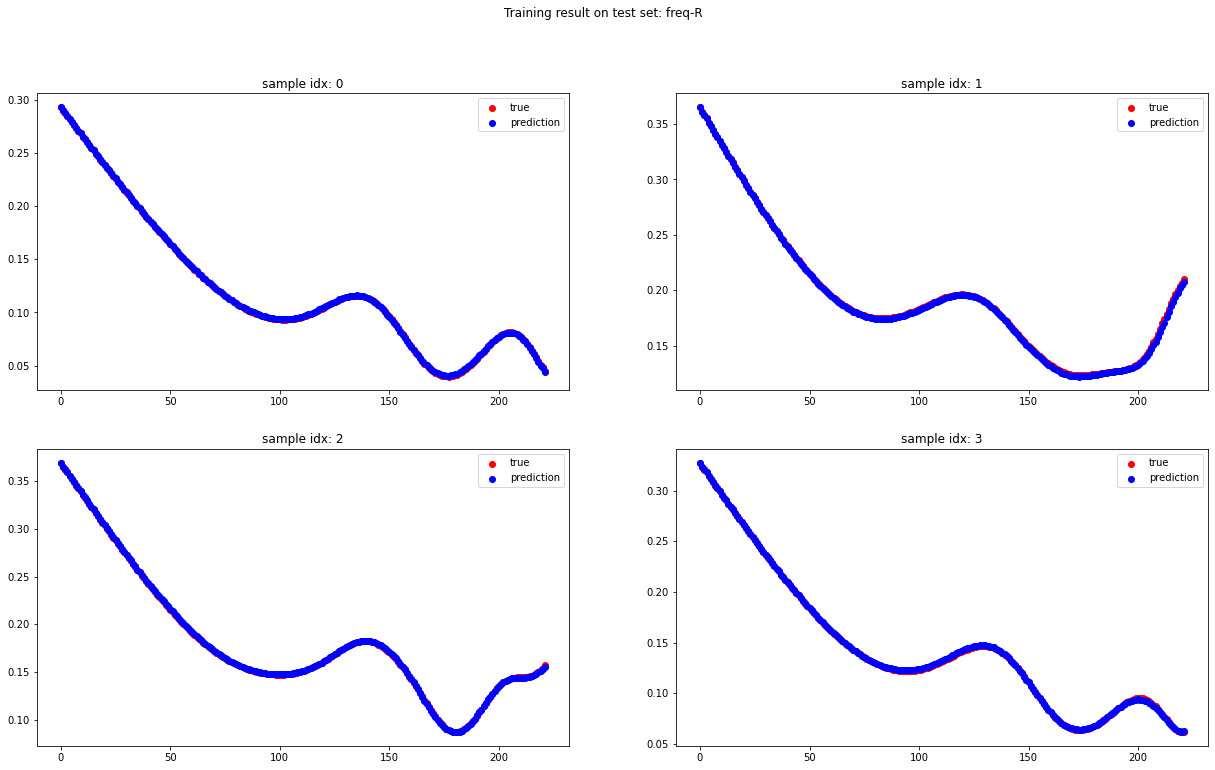

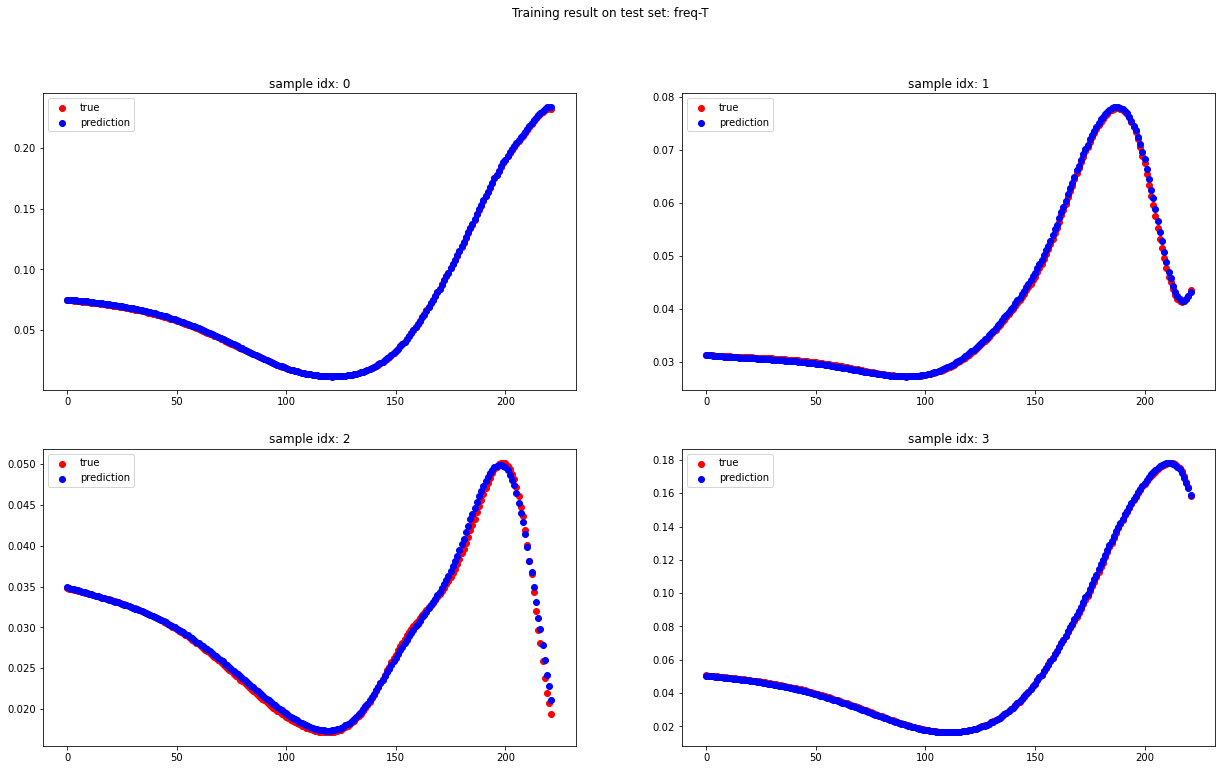

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [147. 122. 160.  75.]
 [145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [147. 121. 160.  75.]
 [145. 120. 160.  75.]
 [146. 123. 160.  75.]
 [146. 120. 160.  75.]
 [147. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


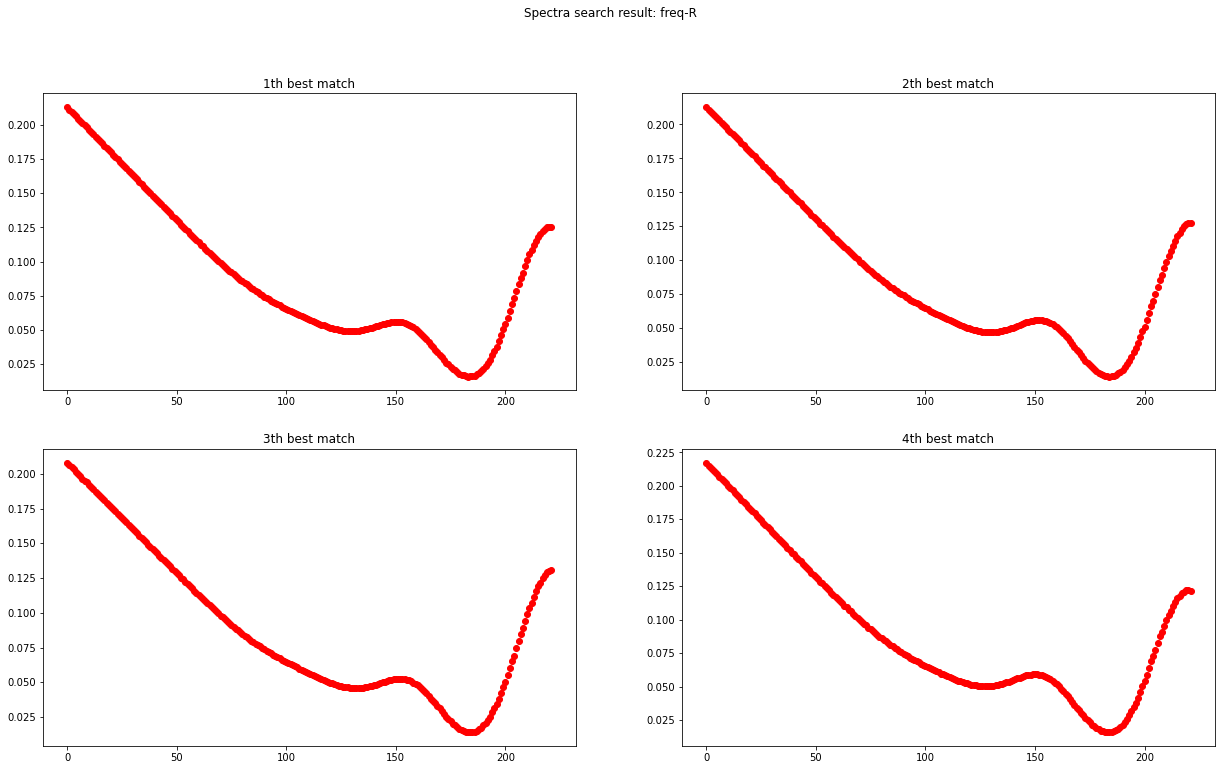

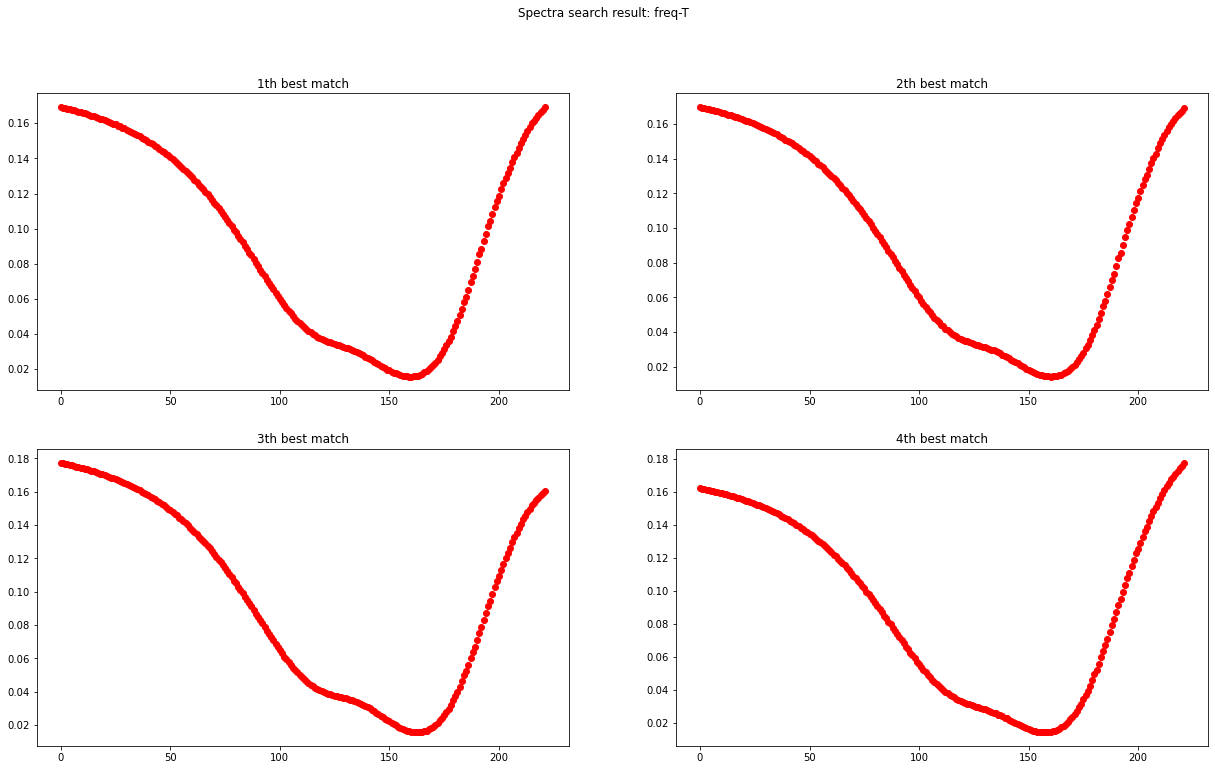

*** Reruning RCWA on picked params
params_dict.shape: (1416, 4)
R_dict.shape: (1416, 222)
T_dict.shape: (1416, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
---------

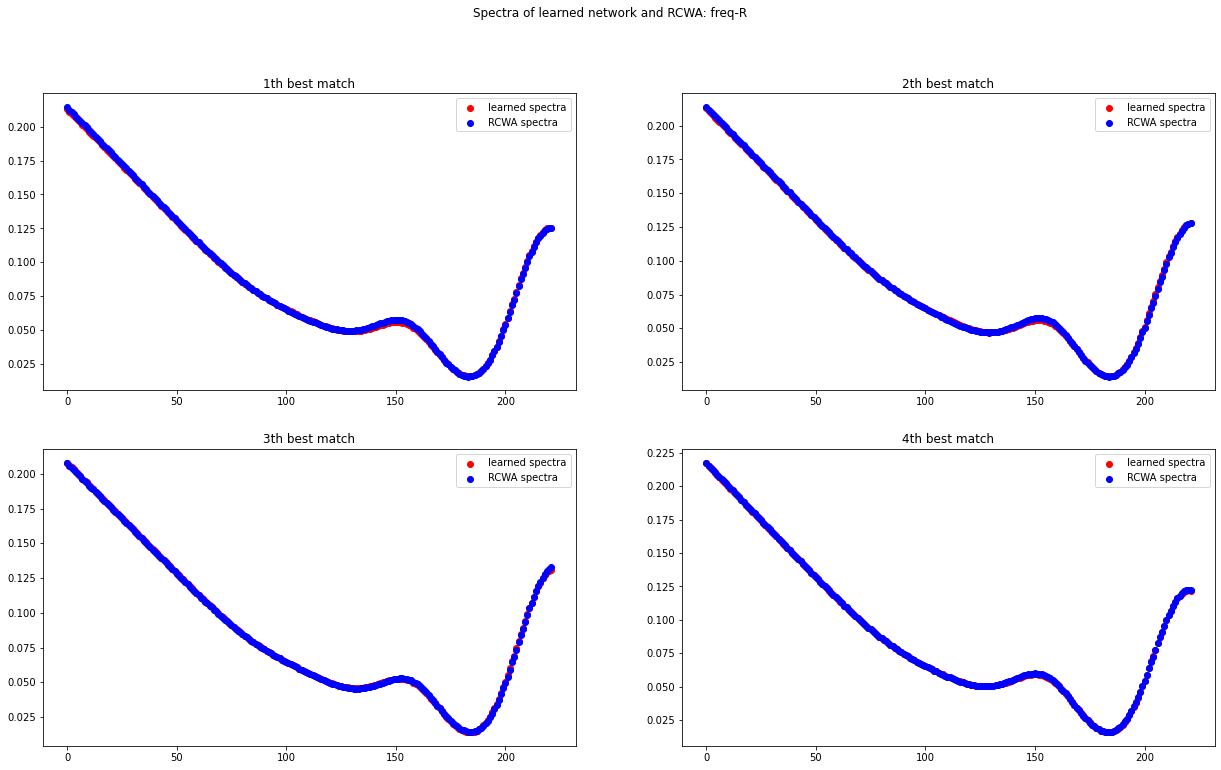

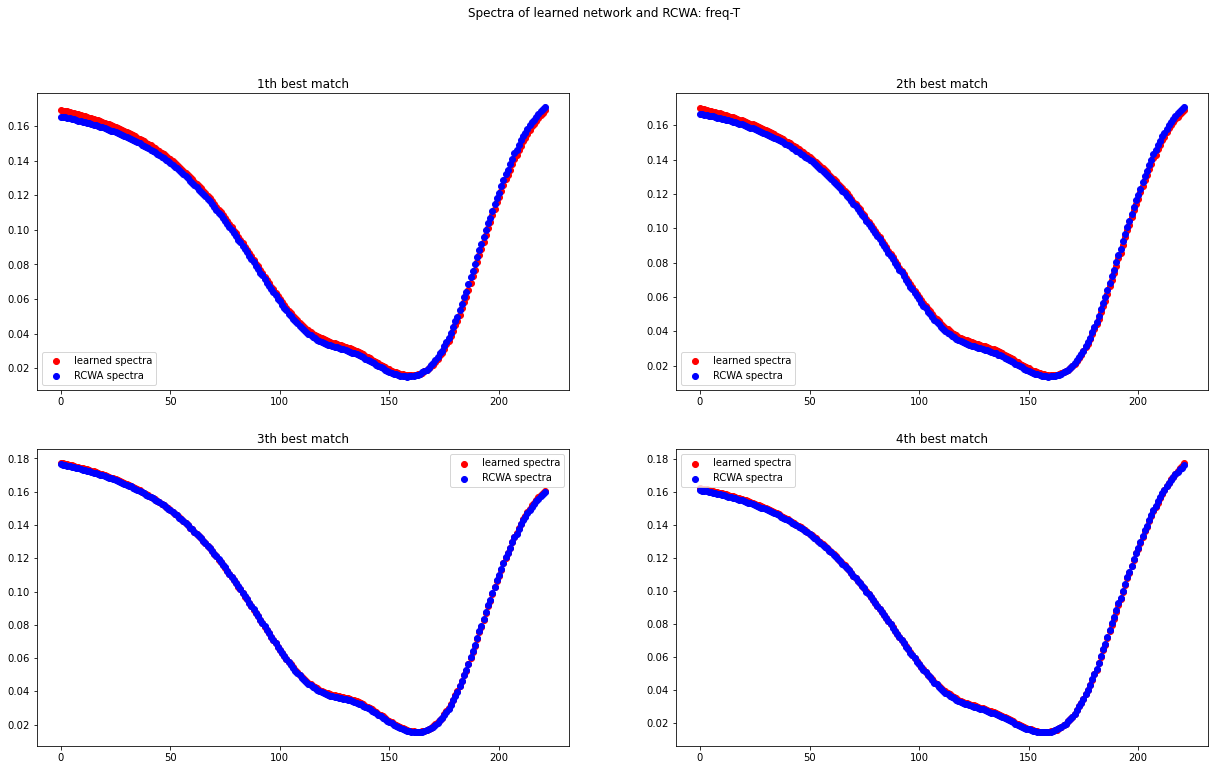

** Model saved.
**************************** ROUND 8 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1600
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [78. 67.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [115. 126.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 62. 108.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [110. 133.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 55. 148.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 89. 124.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [123.  56.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [60. 74.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 73. 104.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [95. 84.]
Calculation Pro

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [51. 78.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [68. 54.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [132. 123.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 70. 147.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [150.  69.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 80. 146.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [132. 102.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [132.  62.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [105. 123.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [142. 123.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 53. 129.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [114. 144.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.7136890391096246e-05
### TEST LOSS  0.00010114425701128009
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.1097957152941262e-05
### TEST LOSS  3.106235610061958e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.7006803332673144e-06
### TEST LOSS  2.195136782271826e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 3.7807598545924747e-06
### TEST LOSS  1.0750067493366563e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 6.1656579174496074e-06
### TEST LOSS  3.943156741570419e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.1832691078849108e-06
### TEST LOSS  1.3495467570123765e-06
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 8.347028583655103e-07
### TEST LOSS  4.2315947013094046e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 7.321607287469334e-07
### TEST LOSS  8.741450467179371e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 3.0652049551282977e-06
### TEST LOSS  8.952842141714731e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.3210741602676101e-06
### TEST LOSS  6.123397729614529e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.7219141253832503e-06
### TEST LOSS  9.337248296030035e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.738266807387312e-06
### TEST LOSS  1.476647251289857e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.1917489054491526e-06
### TEST LOSS  5.920257185228669e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.1767652653849047e-06
### TEST LOSS  8.25432810103166e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 9.439914541342631e-07
### TEST LOSS  1.456479398124581e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.165770741839438e-07
### TEST LOSS  7.28823878877923e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 7.537600839424563e-07
### TEST LOSS  5.887861990553726e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 6.216331219754955e-07
### TEST LOSS  1.206750532389833e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.4050310727053982e-06
### TEST LOSS  4.4782541053223213e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.193219357997215e-07
### TEST LOSS  3.6511230128155603e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.999865827166495e-07
### TEST LOSS  5.394018257239471e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.448575072009021e-07
### TEST LOSS  8.22588046863378e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.4722476710571365e-06
### TEST LOSS  6.125004397006251e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 2.1183541217384415e-06
### TEST LOSS  7.13241643524043e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 5.398209342688532e-07
### TEST LOSS  4.486012521454086e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.132685384763193e-07
### TEST LOSS  5.52344210073367e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.07490792109877e-07
### TEST LOSS  3.831134177308589e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 5.577735810935458e-07
### TEST LOSS  1.1270828655559246e-06
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.380178605474129e-07
### TEST LOSS  4.201200466032636e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.153007325175984e-07
### TEST LOSS  3.800793126155592e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 7.720661732846246e-07
### TEST LOSS  5.124670821032851e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.846673649749889e-07
### TEST LOSS  4.5511989673248837e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.6944692901895733e-07
### TEST LOSS  3.648232234828204e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.4616888617232675e-07
### TEST LOSS  3.0831380411674064e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.795796948342534e-07
### TEST LOSS  4.6906705009064353e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.141660811152192e-07
### TEST LOSS  2.871382716781075e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.1848098961461136e-07
### TEST LOSS  4.324917917131188e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.060961351754933e-07
### TEST LOSS  7.035130569950828e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.317405677567443e-07
### TEST LOSS  3.439896592756971e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.825927036018363e-07
### TEST LOSS  3.753050362339157e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.867073263741361e-07
### TEST LOSS  3.99890347798267e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.426584866035199e-07
### TEST LOSS  3.83494880888217e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.9805338655218845e-07
### TEST LOSS  2.875131481043051e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.672672882022333e-07
### TEST LOSS  9.570363559419093e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.412819019128378e-07
### TEST LOSS  3.2281833857913017e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.9063488188828543e-07
### TEST LOSS  3.1593763575680594e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.791409770277255e-07
### TEST LOSS  2.056406676350283e-06
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.6274097440290876e-07
### TEST LOSS  5.214468643544024e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.876008174425905e-07
### TEST LOSS  3.0496000154774566e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.0566858263701986e-07
### TEST LOSS  4.178919562984144e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.9815451650215827e-07
### TEST LOSS  2.5938699425391104e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.964324923932949e-07
### TEST LOSS  6.826841077630282e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.6680562642453794e-07
### TEST LOSS  5.150895662590452e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.102720408316607e-07
### TEST LOSS  5.925816365011846e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.8489150567588836e-07
### TEST LOSS  2.5125729408159714e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.1451990757224166e-07
### TEST LOSS  6.474783269538875e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.847582118954307e-07
### TEST LOSS  2.9685021670407724e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.58386967301383e-07
### TEST LOSS  1.187422457841573e-06
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.783957287035623e-07
### TEST LOSS  4.172930883801958e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.8177106269188245e-07
### TEST LOSS  4.376751666275898e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.115043799801654e-07
### TEST LOSS  6.296058335427309e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.801421400906335e-07
### TEST LOSS  5.143512602501232e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 5.419143560980722e-07
### TEST LOSS  3.022098749028146e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.115866538945134e-07
### TEST LOSS  3.6532193566548205e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.0699365664531586e-07
### TEST LOSS  2.572629801041633e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.055676330372293e-07
### TEST LOSS  3.393082905015869e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.3229089781604556e-07
### TEST LOSS  3.7072091885193004e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.68547995666102e-07
### TEST LOSS  2.737053700722451e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.697146274772578e-07
### TEST LOSS  3.5770613730316353e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.5438222612538264e-07
### TEST LOSS  3.348640641812987e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.3681297650310925e-07
### TEST LOSS  5.702807411485841e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.6819376106000943e-07
### TEST LOSS  4.902215048711392e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.6838426194840677e-07
### TEST LOSS  3.270301445941944e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.0937952669906074e-07
### TEST LOSS  4.050179060281304e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.743742085249302e-07
### TEST LOSS  2.2526307930093026e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.249637527586891e-07
### TEST LOSS  6.772393608874457e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.1106601844975723e-07
### TEST LOSS  9.307843100714308e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.3784878259289786e-07
### TEST LOSS  3.303422128434856e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.297781302591396e-07
### TEST LOSS  3.814427529391651e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.6285321848739115e-07
### TEST LOSS  3.2262389974372735e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.5317527991240993e-07
### TEST LOSS  6.373711975982133e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 5.576720889843845e-07
### TEST LOSS  3.188078524137457e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.273029016177432e-07
### TEST LOSS  2.9698226218973406e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.439500160906661e-07
### TEST LOSS  3.4884896275381533e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.34070505976225e-07
### TEST LOSS  2.4412250117696505e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.833484346915661e-07
### TEST LOSS  2.713512312624289e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.7964891492769936e-07
### TEST LOSS  2.7064623549695927e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.4454491017910094e-07
### TEST LOSS  2.4385115970915194e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.328529178370232e-07
### TEST LOSS  2.514750470083982e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.393608888768718e-07
### TEST LOSS  4.3367338993978893e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.6908968959692425e-07
### TEST LOSS  4.1277555477374034e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.0532045971986006e-07
### TEST LOSS  3.191582204446301e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.4069782830492554e-07
### TEST LOSS  3.373287444929929e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.321842112535833e-07
### TEST LOSS  2.63735934424858e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.865434383520938e-07
### TEST LOSS  3.7097093752436194e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.2290317597993834e-07
### TEST LOSS  3.0256845266289173e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.2267101738980843e-07
### TEST LOSS  3.641949331741519e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.3749521739290244e-07
### TEST LOSS  2.9413053503901665e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.874395081848725e-07
### TEST LOSS  2.864966166526983e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 5.928787527387236e-07
### TEST LOSS  5.843664515244503e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.955856229920229e-07
### TEST LOSS  4.540561135968346e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.917308284484555e-07
### TEST LOSS  2.788914598520857e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.153779130826706e-07
### TEST LOSS  2.854927719416385e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.3898443080770945e-07
### TEST LOSS  5.549581629793465e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.679680755763748e-07
### TEST LOSS  2.8971640790113423e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.253727892105207e-07
### TEST LOSS  3.248219915263917e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.144026790713461e-07
### TEST LOSS  4.736487137317151e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.0636791720661804e-07
### TEST LOSS  3.8869568067904464e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.016876913319866e-07
### TEST LOSS  2.8188296793037654e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.1945151483414593e-07
### TEST LOSS  2.6780630690836915e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.906146355496908e-07
### TEST LOSS  2.594466472771728e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.9576154103594376e-07
### TEST LOSS  4.1249947694647443e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.165055731013666e-07
### TEST LOSS  3.8423171844215176e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.0064135357665834e-07
### TEST LOSS  3.2696035508668803e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.8415843993999664e-07
### TEST LOSS  2.401841617446128e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.560478500985731e-07
### TEST LOSS  2.87468408188829e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.2803290834104714e-07
### TEST LOSS  2.557976651236989e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.163547229323438e-07
### TEST LOSS  3.1560506030814395e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.6120136007289363e-07
### TEST LOSS  3.484783673476007e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.345351737915614e-07
### TEST LOSS  2.1451194361551037e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.174057865784619e-07
### TEST LOSS  2.3967194392090124e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.0490653253889556e-07
### TEST LOSS  2.6875949051448816e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.432744047149328e-07
### TEST LOSS  2.436812334138949e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.3224171158807716e-07
### TEST LOSS  2.900361894357199e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.3213914675478405e-07
### TEST LOSS  4.001705704581582e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.0225268503603077e-07
### TEST LOSS  4.5378769423602233e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.8810672931145475e-07
### TEST LOSS  3.2669903760051966e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.677719598105256e-07
### TEST LOSS  2.6425974593754137e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.3650993097600335e-07
### TEST LOSS  3.1090541341427524e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.8919789558545796e-07
### TEST LOSS  3.535525798052201e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.9759919000227343e-07
### TEST LOSS  2.659044344710537e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.2629741739786943e-07
### TEST LOSS  5.039739991256434e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.0388670265280025e-07
### TEST LOSS  2.4082152864461176e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.84112766432143e-07
### TEST LOSS  2.3390772341258526e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.0009612062009694e-07
### TEST LOSS  2.8582560733051804e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.8928545195316954e-07
### TEST LOSS  2.8413225431715244e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.125507726153831e-07
### TEST LOSS  2.4076041427179007e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.88878945365434e-07
### TEST LOSS  4.789358160432281e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.205612807777314e-07
### TEST LOSS  2.8017873887620226e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.3949256742271674e-07
### TEST LOSS  3.1084689962786644e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.1972295865934087e-07
### TEST LOSS  2.3386814026101396e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.216387575921686e-07
### TEST LOSS  2.9007177341592677e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.99685212536982e-07
### TEST LOSS  3.2078523778030405e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.7748063649246644e-07
### TEST LOSS  2.6608795226460796e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.669746200223422e-07
### TEST LOSS  2.3158411247929203e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.0701018924661485e-07
### TEST LOSS  3.088537348835037e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.962736681144662e-07
### TEST LOSS  3.289259495886654e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.3706191555404884e-07
### TEST LOSS  2.5757729282815944e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.1024862773954e-07
### TEST LOSS  3.581209225463529e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.135120396446922e-07
### TEST LOSS  2.624523229854958e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.0678682437557116e-07
### TEST LOSS  3.3406528032742244e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.3794459127878263e-07
### TEST LOSS  2.5815013178961027e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.3066991385721776e-07
### TEST LOSS  2.919654005969126e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.877290882641326e-07
### TEST LOSS  5.730560867315641e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 8.517800800400544e-07
### TEST LOSS  2.725479178640929e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.2853572150992605e-07
### TEST LOSS  5.378173296340568e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.9274856543581863e-07
### TEST LOSS  3.0957351645118553e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 4.356777995928596e-07
### TEST LOSS  7.018107848940266e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.7696245183793667e-07
### TEST LOSS  2.890596064730744e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.1814017504627755e-07
### TEST LOSS  2.9582593974453175e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.363891594820867e-07
### TEST LOSS  3.211986925322208e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.9466882549566976e-07
### TEST LOSS  3.616917627624616e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.375748383072086e-07
### TEST LOSS  3.0478047345165277e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.4865374678894054e-07
### TEST LOSS  2.6828438433786533e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.860273607074859e-07
### TEST LOSS  2.3997652753848797e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.0071839709266966e-07
### TEST LOSS  2.1351393482878697e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.420399026232701e-07
### TEST LOSS  1.040530536992416e-06
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 4.0188118764383775e-07
### TEST LOSS  2.3230370693738678e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.729103251297715e-07
### TEST LOSS  3.595341553364051e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.035840960774472e-07
### TEST LOSS  4.3311326910118925e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.077796040562575e-07
### TEST LOSS  2.62389274752195e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.8058596503011125e-07
### TEST LOSS  2.9244224168204863e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.03557064085247e-07
### TEST LOSS  2.1473898807281935e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.6928435233886103e-07
### TEST LOSS  2.4021910268364383e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.8781561750790274e-07
### TEST LOSS  4.844207820061305e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.0235737590533774e-07
### TEST LOSS  2.577948491714703e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.0197362405282035e-07
### TEST LOSS  2.2925872400492153e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.3081805898893536e-07
### TEST LOSS  2.3278841254636973e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.8123566675364306e-07
### TEST LOSS  2.519151512577385e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.8007648187555747e-07
### TEST LOSS  2.0032088994999717e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 3.8884979270625843e-07
### TEST LOSS  3.751871335092953e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.2014403497315766e-07
### TEST LOSS  3.07441946271562e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 8.585518286319261e-07
### TEST LOSS  4.115135491626158e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.261602710336042e-07
### TEST LOSS  2.4997130883737856e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.99975542217279e-07
### TEST LOSS  2.576448222176471e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.8088093369738055e-07
### TEST LOSS  2.1615746644461828e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.814215807855902e-07
### TEST LOSS  2.4042203487321484e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.0365910186125334e-07
### TEST LOSS  2.2541058442016038e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.831479244447266e-07
### TEST LOSS  5.554993206165667e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.093911149754103e-07
### TEST LOSS  2.1646377490469604e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.816186556775513e-07
### TEST LOSS  2.43689505907696e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.934974793333822e-07
### TEST LOSS  2.1779188645136097e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.785575909669547e-07
### TEST LOSS  3.1028035844353025e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.0234452005339916e-07
### TEST LOSS  2.1033876329568102e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.958900967842126e-07
### TEST LOSS  2.3543664617875493e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.0092652268498556e-07
### TEST LOSS  3.72985169268721e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.7329318515456614e-07
### TEST LOSS  2.8570591936727396e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.1330640408722133e-07
### TEST LOSS  3.173483401989567e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.00340851466796e-07
### TEST LOSS  1.4811057885329622e-06
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.965870299760255e-07
### TEST LOSS  2.5905046996399506e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.7804317172530625e-07
### TEST LOSS  3.691967969861783e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.12050484142512e-07
### TEST LOSS  3.7367512343659354e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.1444531064517276e-07
### TEST LOSS  2.9528569929955967e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.853746683413206e-07
### TEST LOSS  3.015646612425371e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.8360583032793764e-07
### TEST LOSS  2.3011893309406636e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 3.1813919317835724e-07
### TEST LOSS  2.7825746921431954e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.97884399758086e-07
### TEST LOSS  2.455342690647437e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.822968063054265e-07
### TEST LOSS  1.6521029699845258e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.813368150123008e-07
### TEST LOSS  2.367588631813078e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.838353472700561e-07
### TEST LOSS  2.5919320142027874e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.7378725755644593e-07
### TEST LOSS  2.144786481750316e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.8677653958419923e-07
### TEST LOSS  7.480464413826363e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.268104967579788e-07
### TEST LOSS  2.3572946320863744e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.787829230621597e-07
### TEST LOSS  2.4518841890142085e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.14534413818901e-07
### TEST LOSS  2.6631959274917943e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.4301203080344675e-07
### TEST LOSS  4.849691705999248e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 3.289991089483468e-07
### TEST LOSS  2.5379568195186647e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.664801958940366e-07
### TEST LOSS  2.9068592155567785e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.7216293345011524e-07
### TEST LOSS  3.4578700021844117e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.9384589623981937e-07
### TEST LOSS  2.0377508273365189e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.848326519888644e-07
### TEST LOSS  5.74329264206123e-06
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.8954858082806965e-07
### TEST LOSS  2.3601325220094319e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.687054893102392e-07
### TEST LOSS  2.384317288791256e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.669096872831567e-07
### TEST LOSS  2.706251501412756e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.8161689038075364e-07
### TEST LOSS  3.296065518298974e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.09801798856757e-07
### TEST LOSS  4.3907032913163374e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.8591580097936387e-07
### TEST LOSS  2.5894632157038206e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.6995341182667334e-07
### TEST LOSS  2.602413070225869e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.905196395164289e-07
### TEST LOSS  1.9216003662355283e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.823805004492641e-07
### TEST LOSS  1.7465357456577144e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.720608610928821e-07
### TEST LOSS  2.3425205715928618e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.9594496109265338e-06
### TEST LOSS  2.9035093322230904e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 4.796147921926064e-07
### TEST LOSS  2.766591560288134e-07
** loss_train 4.796147921926064e-07
** loss_test 2.766591560288134e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


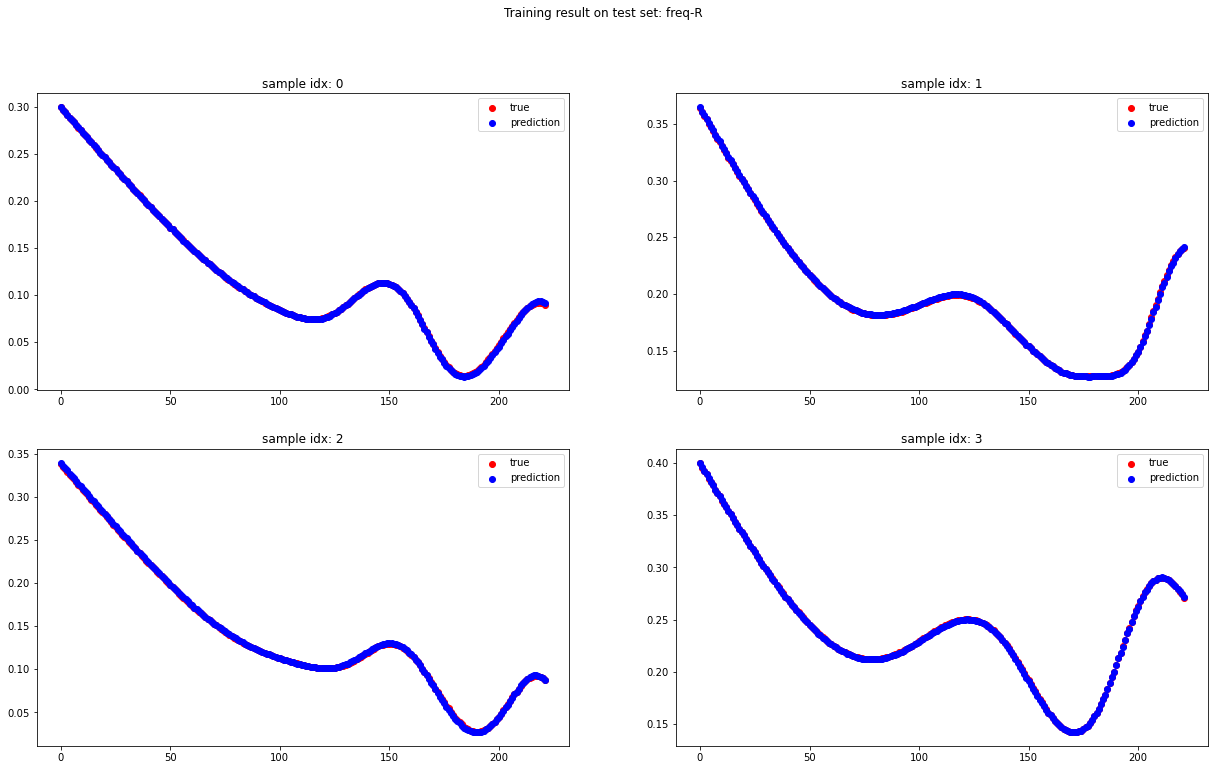

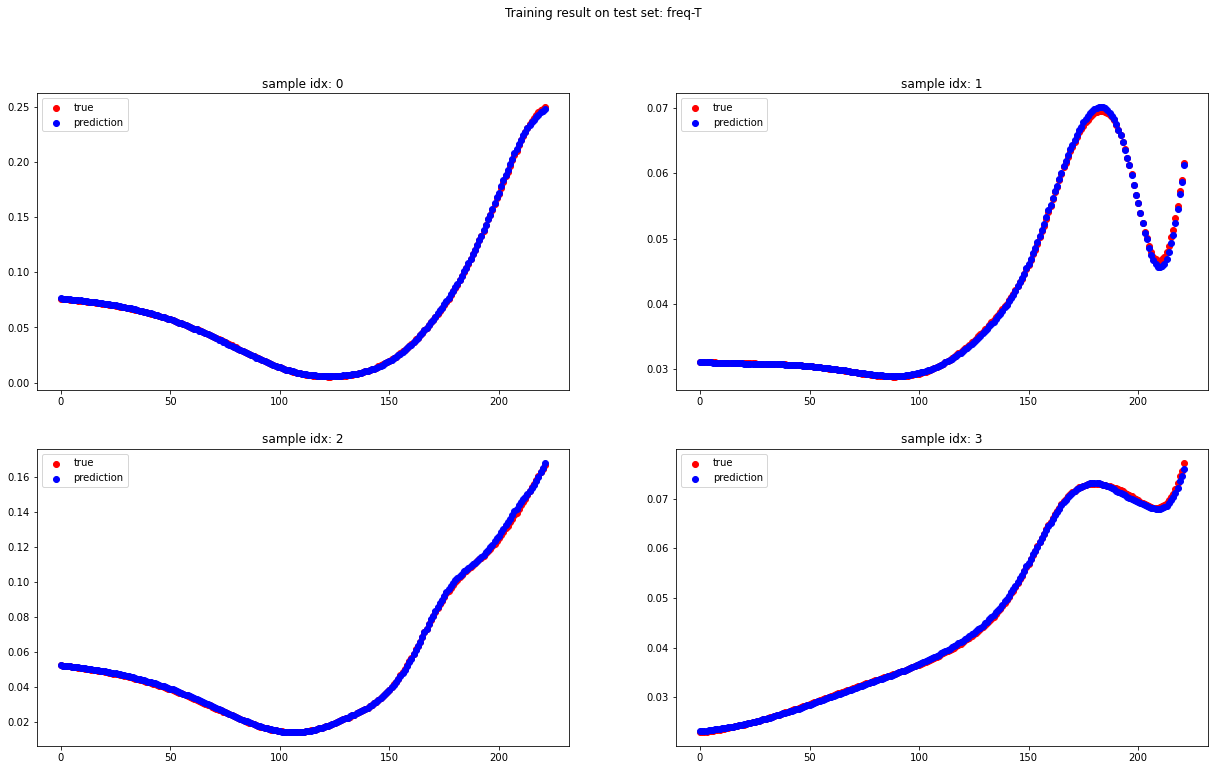

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [145. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 120. 160.  75.]
 [146. 120. 160.  75.]
 [145. 122. 160.  75.]
 [146. 123. 160.  75.]
 [147. 122. 160.  75.]
 [146. 119. 160.  75.]
 [145. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


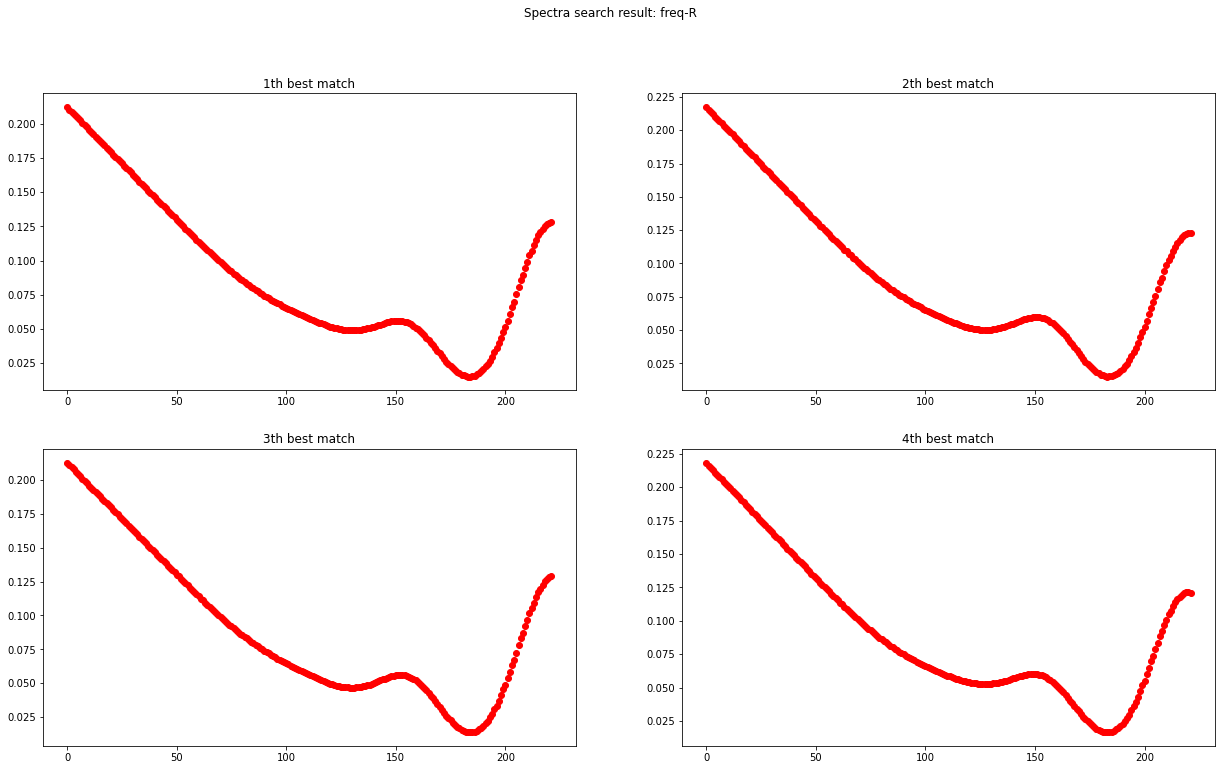

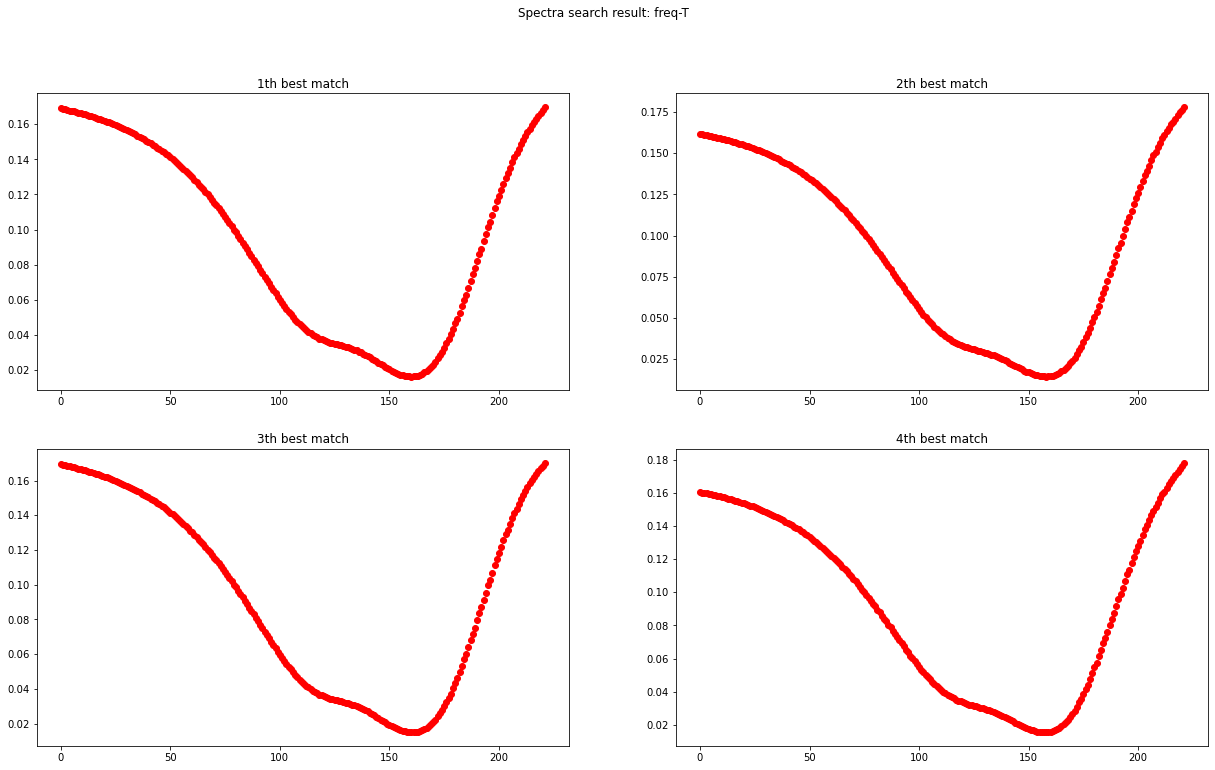

*** Reruning RCWA on picked params
params_dict.shape: (1616, 4)
R_dict.shape: (1616, 222)
T_dict.shape: (1616, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
---------

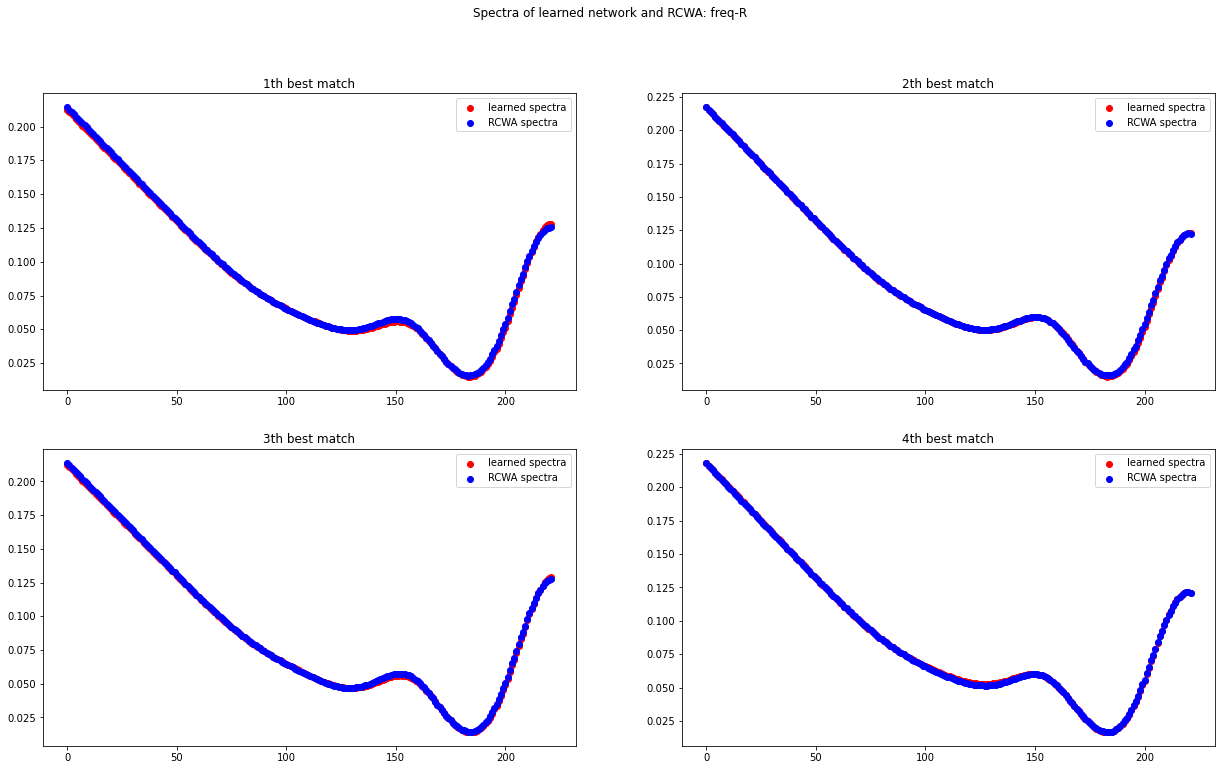

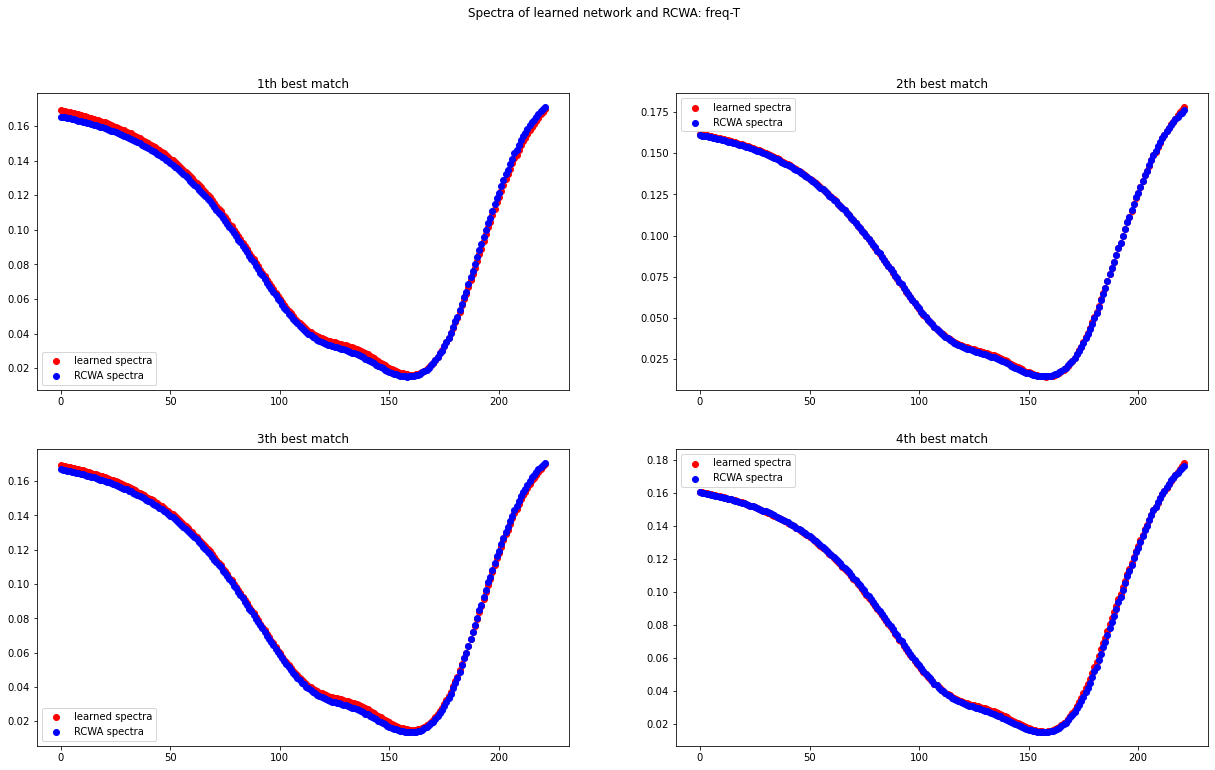

** Model saved.
**************************** ROUND 9 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1800
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [55. 58.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [139. 137.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [142. 139.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [148. 137.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [138.  53.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 67. 119.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [108. 141.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [134. 147.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [143. 130.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [115. 125.]
Calculation

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 64. 110.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [107.  59.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [101.  55.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [108.  67.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 80. 130.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [127. 136.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 67. 104.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [107.  70.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [75. 97.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 83. 141.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [144. 129.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [112.  64.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.042685881808893e-05
### TEST LOSS  9.179476155959828e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 8.444727697138888e-06
### TEST LOSS  3.4204767029290517e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.162664077666831e-06
### TEST LOSS  4.571049253677807e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.218254836085104e-06
### TEST LOSS  4.039574706540508e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.9733321296434824e-06
### TEST LOSS  2.554156948362005e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 9.589153784001307e-06
### TEST LOSS  2.8781359341573313e-05
----------------------------------------------------------------------
**

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.471689908364561e-06
### TEST LOSS  1.2110376196182592e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.1835623431642893e-06
### TEST LOSS  7.486977374861049e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.105088863392704e-06
### TEST LOSS  8.551522396542337e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 9.114599694884065e-07
### TEST LOSS  5.633221315259073e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 8.080456104053724e-07
### TEST LOSS  5.578274750759091e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 7.343951492128692e-07
### TEST LOSS  5.192725883194658e-07
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 7.290389240684666e-07
### TEST LOSS  9.86630254828924e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.1046252080622782e-06
### TEST LOSS  1.1604864661657537e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 7.778823460134908e-07
### TEST LOSS  7.841763426262737e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 7.365233003062441e-07
### TEST LOSS  7.867959505313559e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 9.958766681962395e-07
### TEST LOSS  7.145781142770391e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 6.603595638112994e-07
### TEST LOSS  5.034530595872234e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 5.930068564157724e-07
### TEST LOSS  6.069285855456083e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 5.972310413563757e-07
### TEST LOSS  6.410446570936512e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 8.493479859734205e-07
### TEST LOSS  1.0596063559744465e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.90444501509238e-07
### TEST LOSS  6.892094532944341e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.898126971127832e-07
### TEST LOSS  6.818718479398403e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.3851102042592186e-06
### TEST LOSS  6.337090854702654e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 9.259858543408939e-07
### TEST LOSS  8.405032295505171e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.5414007894499883e-06
### TEST LOSS  6.419379387891779e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.5310736292385564e-06
### TEST LOSS  5.297995221132657e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 7.327166346549064e-07
### TEST LOSS  1.037760941673898e-06
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.944812065828248e-07
### TEST LOSS  4.3478947915260776e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.759432602836512e-07
### TEST LOSS  6.108376053530433e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.239705224586228e-07
### TEST LOSS  2.377780386150671e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.197935248584745e-07
### TEST LOSS  4.614594902081821e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.183965875231226e-07
### TEST LOSS  5.838758359762627e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.413066909850292e-07
### TEST LOSS  5.726597557306242e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.651205913377668e-07
### TEST LOSS  6.969299001277115e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 1.0664104969630255e-06
### TEST LOSS  5.20884372934705e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.902420660337883e-07
### TEST LOSS  4.1167682609368594e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.402623790414415e-07
### TEST LOSS  6.32894663491849e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.6512808742152047e-07
### TEST LOSS  4.896297390907286e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.4859200945879254e-07
### TEST LOSS  5.787728769990752e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.55140786343517e-07
### TEST LOSS  4.3521873117747924e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.520136762960666e-07
### TEST LOSS  3.5189745675426013e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.539642597794429e-07
### TEST LOSS  6.330416995212916e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.125465930946562e-07
### TEST LOSS  7.255500467753908e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.4415344111333375e-07
### TEST LOSS  1.0266221790044693e-06
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 7.436511031144733e-07
### TEST LOSS  3.919154157419716e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.682195818756952e-07
### TEST LOSS  4.537352201286585e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.5424587115563657e-07
### TEST LOSS  5.317743835399192e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.2140960089690587e-06
### TEST LOSS  1.278819057562133e-06
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 7.078212141406779e-07
### TEST LOSS  4.839733441662652e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.033653319625526e-07
### TEST LOSS  3.4680026896307093e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.705053468770062e-07
### TEST LOSS  3.4259753815772624e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.60544937593473e-07
### TEST LOSS  5.822160218300539e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 6.859590115047985e-07
### TEST LOSS  5.471956314893221e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.6135294744607967e-07
### TEST LOSS  4.0865256620590014e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.935626043728942e-07
### TEST LOSS  4.0887153073964767e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 7.916363170540959e-07
### TEST LOSS  6.051806735740684e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 7.0964218854799e-07
### TEST LOSS  3.8926756718427457e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.06331202849582e-06
### TEST LOSS  1.7172485934645887e-06
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 1.128664255622722e-06
### TEST LOSS  5.928127877639243e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.1509092201784545e-07
### TEST LOSS  3.8459216124532825e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.265563331904174e-07
### TEST LOSS  3.0449332181585004e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.255769364548535e-07
### TEST LOSS  4.36709924584917e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.1458650370332055e-07
### TEST LOSS  2.9329725150630647e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.36503034839417e-07
### TEST LOSS  6.406987638372273e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.283512161151748e-07
### TEST LOSS  2.980523519184957e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.2190855575836077e-07
### TEST LOSS  3.181400929692986e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.205308390818156e-07
### TEST LOSS  5.452692543409891e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.801018405072101e-07
### TEST LOSS  3.8289027981119473e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.8951662119954575e-07
### TEST LOSS  3.6449343994078206e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.136329953554865e-07
### TEST LOSS  4.913794521565217e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.7239144666381365e-07
### TEST LOSS  5.600040832700028e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.9884519899718245e-07
### TEST LOSS  6.021380064188028e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 1.1629361663661402e-06
### TEST LOSS  5.274864855032824e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 6.673011550242494e-07
### TEST LOSS  3.6634612485984153e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.374235126351304e-07
### TEST LOSS  3.563082728945759e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.772855883453651e-07
### TEST LOSS  2.762369125211653e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.27912342480457e-07
### TEST LOSS  2.835796558892306e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.9696044723314117e-07
### TEST LOSS  3.2844984490212585e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.0100371841865645e-07
### TEST LOSS  2.3593082371715153e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.5292568212676026e-07
### TEST LOSS  2.964391404281775e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.920265379342425e-07
### TEST LOSS  8.022475181287856e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.0029509818258664e-07
### TEST LOSS  2.7800984033395554e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.456126645318136e-07
### TEST LOSS  2.508543117427406e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 5.106308565001112e-07
### TEST LOSS  2.995935759557782e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.682139230044691e-07
### TEST LOSS  3.0897723911914873e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 7.179732118641387e-07
### TEST LOSS  4.205061899214073e-06
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 1.3455418650032414e-06
### TEST LOSS  6.026123394854544e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 1.304071073136015e-06
### TEST LOSS  6.997180687701782e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 5.09610771359803e-07
### TEST LOSS  5.592776285875853e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 6.567957652237055e-07
### TEST LOSS  6.556350626851781e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 5.556229569059212e-07
### TEST LOSS  4.223807208189909e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.655326503329251e-07
### TEST LOSS  3.293057941559878e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 5.14894088462133e-07
### TEST LOSS  4.0050375631566296e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.592860523562693e-07
### TEST LOSS  3.0914726989050435e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 4.7342929336243365e-07
### TEST LOSS  6.152592370064532e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.7025626511027415e-07
### TEST LOSS  2.3475959612487376e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.488081218626525e-07
### TEST LOSS  2.8608576117137464e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.5805765947848224e-07
### TEST LOSS  3.386902773383082e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.7382560818915385e-07
### TEST LOSS  5.625501884238744e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.781892807847637e-07
### TEST LOSS  5.871264879378604e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.662713630387455e-07
### TEST LOSS  3.5078426839795105e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.82239653347543e-07
### TEST LOSS  2.665878400665423e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.749332657262035e-07
### TEST LOSS  2.990234306749968e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.781205301400803e-07
### TEST LOSS  3.6378705414319014e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 6.363694725802165e-07
### TEST LOSS  6.071718427459995e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.681807125924327e-07
### TEST LOSS  3.275780631771273e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.5338558960083965e-07
### TEST LOSS  2.659303953999336e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 5.977219324451413e-07
### TEST LOSS  3.858960482190283e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.092953068491356e-06
### TEST LOSS  3.794086772493891e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 5.082704511691657e-07
### TEST LOSS  4.433183720367298e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 4.721102431718786e-07
### TEST LOSS  3.391576791921546e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.786417255607293e-07
### TEST LOSS  4.024753192450387e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 4.7291128644507317e-07
### TEST LOSS  3.9915158612092015e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 7.64138240989038e-07
### TEST LOSS  9.216129249715003e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 4.438882747573005e-07
### TEST LOSS  3.3753817913546095e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 5.310221310534442e-07
### TEST LOSS  2.7671587411583056e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.278861530949819e-07
### TEST LOSS  3.7535447935018357e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.551416595490606e-07
### TEST LOSS  3.0074551257594404e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.823978312972937e-07
### TEST LOSS  3.426667776525223e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.574288201837719e-07
### TEST LOSS  2.298279779493155e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.426352989125784e-07
### TEST LOSS  5.519696018112612e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 4.1424027008475487e-07
### TEST LOSS  3.416539995113352e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.2477355413007556e-07
### TEST LOSS  3.0023287546622735e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.516999861474801e-07
### TEST LOSS  2.867152262440329e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.3771627539912354e-07
### TEST LOSS  3.059372436045696e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.4704887220410933e-07
### TEST LOSS  2.767640789140084e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.164616134239869e-07
### TEST LOSS  2.272711062308493e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.502655924927625e-07
### TEST LOSS  2.688524381887368e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.544642587706272e-07
### TEST LOSS  2.9651880490072707e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.939804448391568e-07
### TEST LOSS  3.7601797994621275e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.7292788786144924e-07
### TEST LOSS  4.3534910997988375e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.578523925579841e-07
### TEST LOSS  3.162887649237005e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.1592337619339933e-07
### TEST LOSS  3.12041655724392e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.442073301782342e-07
### TEST LOSS  2.7450780835267697e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.6954045489423494e-07
### TEST LOSS  2.7033987045662665e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.298869235340223e-07
### TEST LOSS  2.836362156173251e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.293267313332472e-07
### TEST LOSS  2.6629743019755015e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.245669092047068e-07
### TEST LOSS  2.666053546818148e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.3931222249903057e-07
### TEST LOSS  6.051468548978139e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.395182413336152e-07
### TEST LOSS  2.3146276256974723e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.1829680925533745e-07
### TEST LOSS  2.5046468694940645e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.2683658828050157e-07
### TEST LOSS  3.9408545273157936e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 6.826479851016229e-07
### TEST LOSS  3.9852488532266797e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.268334987252233e-07
### TEST LOSS  4.477122093636286e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.502870982973071e-07
### TEST LOSS  2.656730968224279e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.393617459875505e-07
### TEST LOSS  3.325160441313023e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.2463035153954915e-07
### TEST LOSS  2.921342262088392e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.502076488063703e-07
### TEST LOSS  3.244665149564012e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.357079086679309e-07
### TEST LOSS  2.4901791193685686e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 4.3490281781780974e-07
### TEST LOSS  4.4120214734330485e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.756843195073461e-07
### TEST LOSS  2.849380551752903e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.333200375917518e-07
### TEST LOSS  2.2704161987500507e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.1178965868979467e-07
### TEST LOSS  2.867930111994644e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.6133585805724835e-07
### TEST LOSS  4.4638420077986937e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.3196249639920617e-07
### TEST LOSS  3.736789964208314e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.2195478754104557e-07
### TEST LOSS  2.832595179648302e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.594357041514229e-07
### TEST LOSS  2.6262661905278676e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 4.066690276833324e-07
### TEST LOSS  3.3819750963512316e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.6583796242754355e-07
### TEST LOSS  4.243135191683433e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.31029470026007e-07
### TEST LOSS  2.477376760360265e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.511054146324947e-07
### TEST LOSS  2.8216859801785984e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.045764040463281e-07
### TEST LOSS  3.2356675521643615e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.8946098049647476e-07
### TEST LOSS  2.9339842384430356e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.2935525360815946e-07
### TEST LOSS  4.862016398705977e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.0357173096875713e-07
### TEST LOSS  2.3263568283271997e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.371035981795482e-07
### TEST LOSS  2.745700961078775e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.2392690373189084e-07
### TEST LOSS  3.164962439288704e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 1.148982083319557e-06
### TEST LOSS  4.197944073675225e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 4.364761496766789e-07
### TEST LOSS  2.7107224685483677e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.6531276599700077e-07
### TEST LOSS  5.030973482091751e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.7047274288326547e-07
### TEST LOSS  2.70215974435612e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.4368260213647594e-07
### TEST LOSS  2.6325464514482315e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.0790042179083977e-07
### TEST LOSS  2.5479975239182683e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 3.4255419957792316e-07
### TEST LOSS  2.7332003564121504e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.223762972738421e-07
### TEST LOSS  2.734313340026886e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.9309336933951926e-07
### TEST LOSS  2.8617841225982206e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.35219737637418e-07
### TEST LOSS  2.55988528284366e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.310596987837755e-07
### TEST LOSS  3.3345724324994484e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.243615115739513e-07
### TEST LOSS  2.52699376485705e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.9432888779249806e-07
### TEST LOSS  2.7694657839455666e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.0828600509735794e-07
### TEST LOSS  2.2271222614259992e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.278810938706695e-07
### TEST LOSS  6.120977607898331e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.0898538789890674e-07
### TEST LOSS  3.788576782005327e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.936892659653899e-07
### TEST LOSS  2.7110866927547183e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.2795680591964547e-07
### TEST LOSS  5.046347500528672e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 3.166625033558369e-07
### TEST LOSS  2.3688807689099862e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.438992236779212e-07
### TEST LOSS  2.875005322864497e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.620752994078676e-07
### TEST LOSS  4.6518123516155657e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.107389268287698e-07
### TEST LOSS  2.2758525243783945e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.030913062692283e-07
### TEST LOSS  4.146639235437356e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.31297416495957e-07
### TEST LOSS  2.951206231163842e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 3.1712022576692157e-07
### TEST LOSS  1.995082967638424e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.22220321993743e-07
### TEST LOSS  5.696071525562729e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.213057051117592e-07
### TEST LOSS  2.921877448140246e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.122601106595211e-07
### TEST LOSS  4.898702509645201e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.142690317956307e-07
### TEST LOSS  2.1366098539803917e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.6030085316417105e-06
### TEST LOSS  1.2615654314787307e-06
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.737868949866336e-07
### TEST LOSS  2.768243076742591e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.8967655748286033e-07
### TEST LOSS  2.44863009078876e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.1980582638979625e-07
### TEST LOSS  2.4454298326232945e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.987510777864423e-07
### TEST LOSS  2.201630519704378e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.9759780990722285e-07
### TEST LOSS  3.6046856061383786e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.325002452688371e-07
### TEST LOSS  3.9218331351178303e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 3.160360202060354e-07
### TEST LOSS  3.168700157242778e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.9680804592362937e-07
### TEST LOSS  2.8202165988541647e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.01817474346322e-07
### TEST LOSS  2.3458644422876036e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.84552071971373e-07
### TEST LOSS  2.206200309518425e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.2291370235921276e-07
### TEST LOSS  2.620843817853542e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.125740585356122e-07
### TEST LOSS  4.603980614690415e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.9185484986192656e-07
### TEST LOSS  3.5386189899276764e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.9951069236212727e-07
### TEST LOSS  2.3631792266264205e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.055592284341281e-07
### TEST LOSS  4.2612397153250104e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.1957475886320217e-07
### TEST LOSS  2.78660230627018e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.943214651275462e-07
### TEST LOSS  2.6421243833114945e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.986678940036174e-07
### TEST LOSS  5.97356133808986e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 3.121170342031595e-07
### TEST LOSS  2.0392149611712673e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.130319514098466e-07
### TEST LOSS  2.216562470030786e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.4510424040531026e-07
### TEST LOSS  3.357599580424533e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.440003066145102e-07
### TEST LOSS  3.770839003680993e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.010871939027974e-07
### TEST LOSS  2.9099955314551255e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 6.256627126521863e-07
### TEST LOSS  1.00817871489872e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 3.081256289721384e-07
### TEST LOSS  2.6579328644200155e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.1095373811653974e-07
### TEST LOSS  2.625178070645604e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.881559315840813e-07
### TEST LOSS  2.9953891048198447e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.122731965750821e-07
### TEST LOSS  2.2690107504819968e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.2941985505235357e-07
### TEST LOSS  3.0963016894458163e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.2577569176418644e-07
### TEST LOSS  2.4313002955767403e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 3.1973857114151213e-07
### TEST LOSS  3.061596008482984e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 3.674277749511469e-07
### TEST LOSS  2.6887952828844764e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.8279334216069825e-07
### TEST LOSS  3.0713864505203137e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.9886482786838856e-07
### TEST LOSS  2.625040509571961e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.842356798480081e-07
### TEST LOSS  2.2191319030921646e-07
** loss_train 2.842356798480081e-07
** loss_test 2.2191319030921646e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


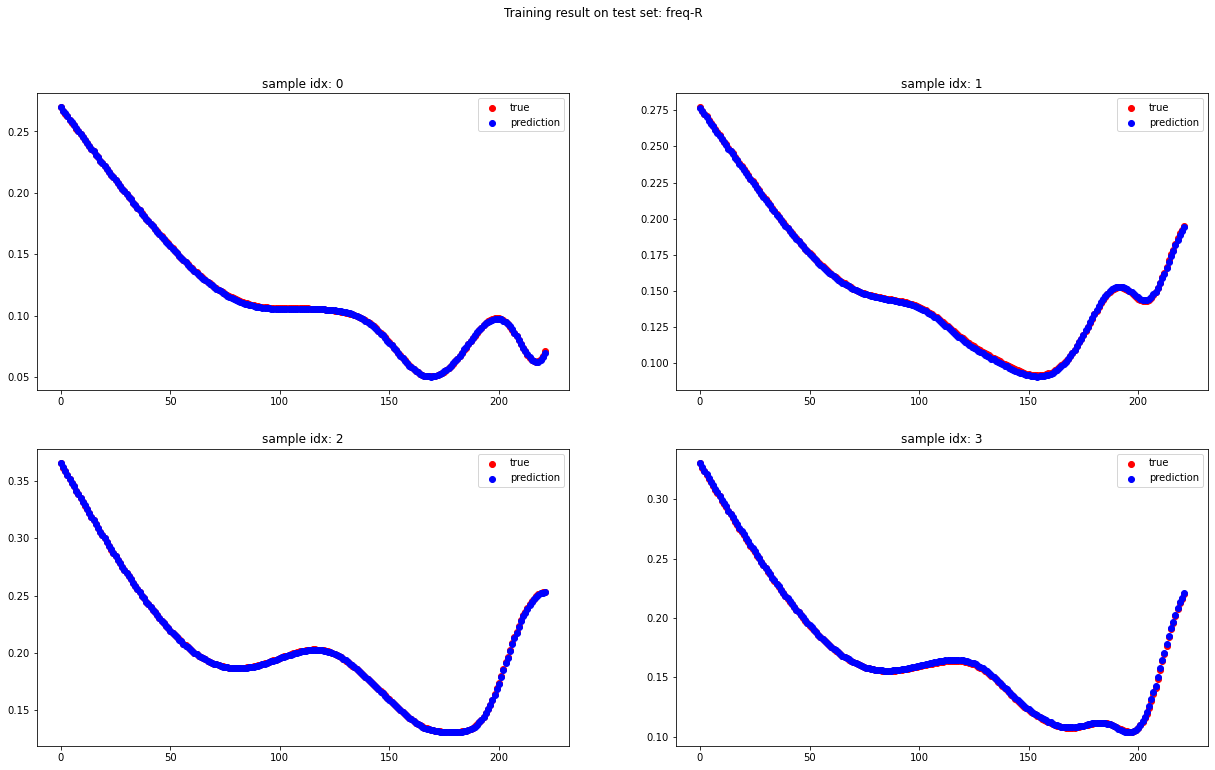

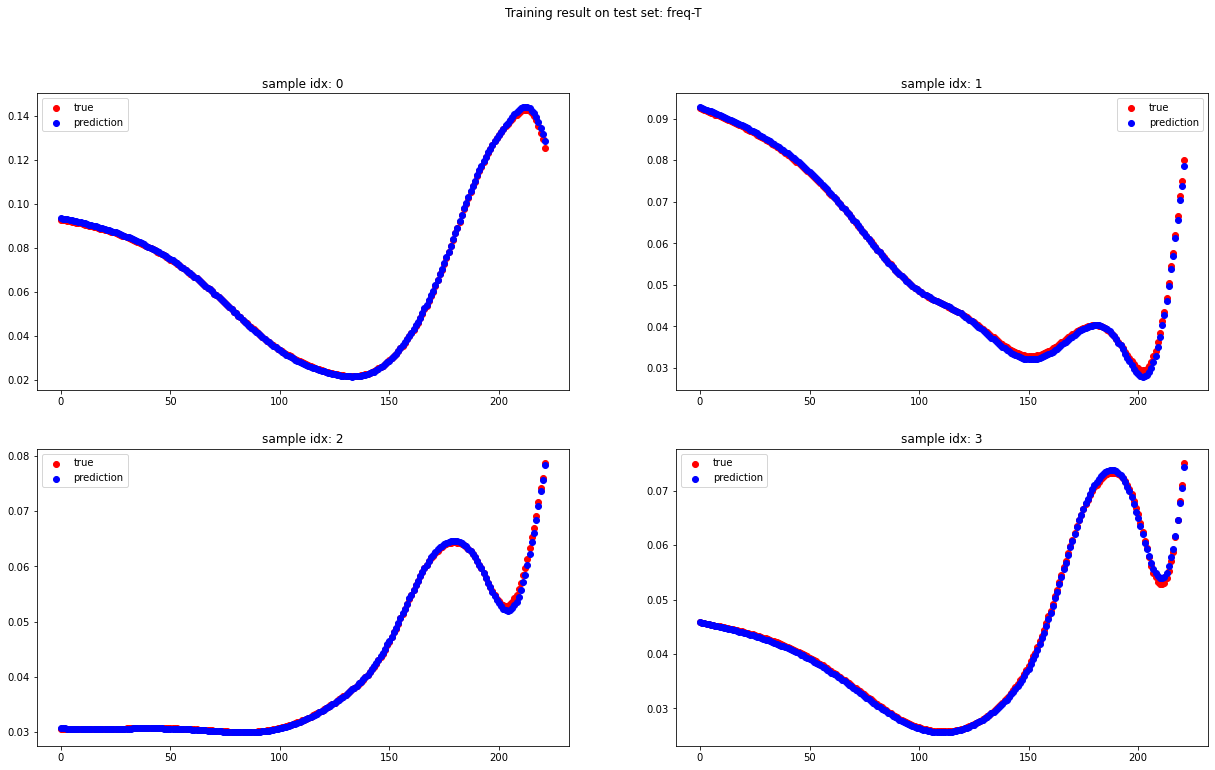

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [145. 120. 160.  75.]
 [146. 123. 160.  75.]
 [146. 120. 160.  75.]
 [145. 123. 160.  75.]
 [147. 122. 160.  75.]
 [146. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


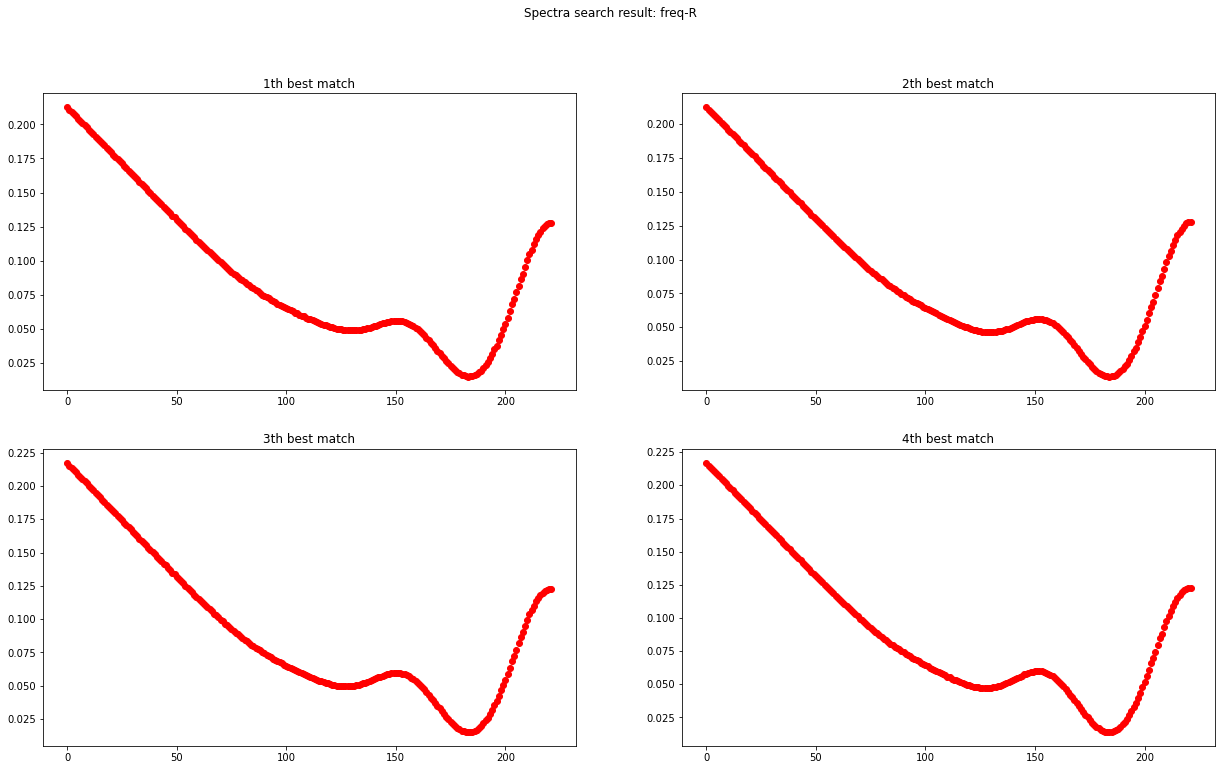

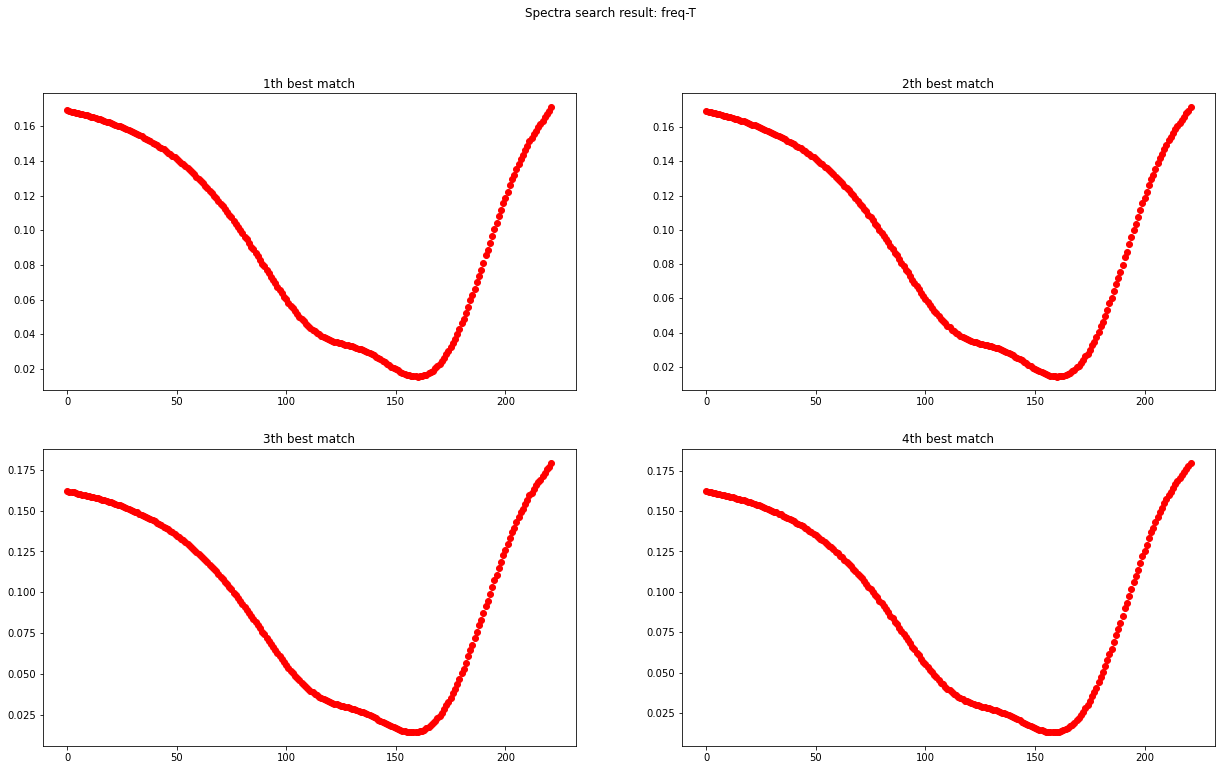

*** Reruning RCWA on picked params
params_dict.shape: (1817, 4)
R_dict.shape: (1817, 222)
T_dict.shape: (1817, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
---------

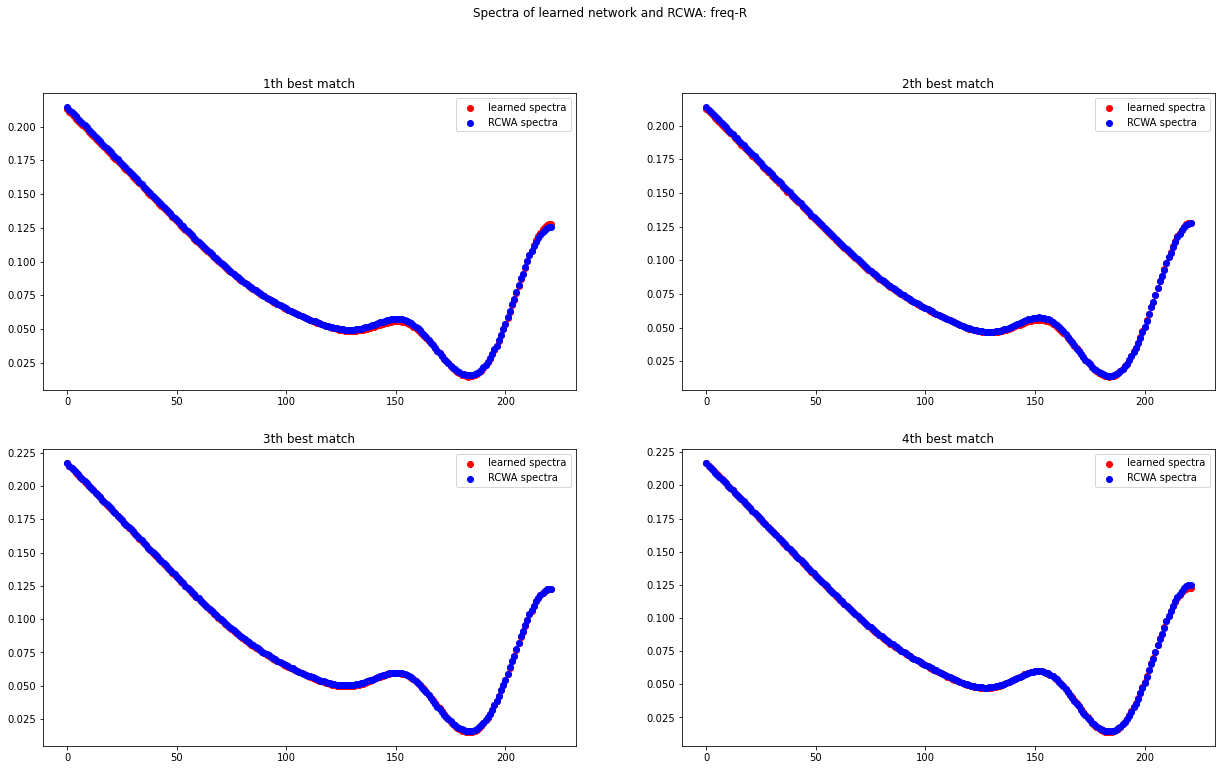

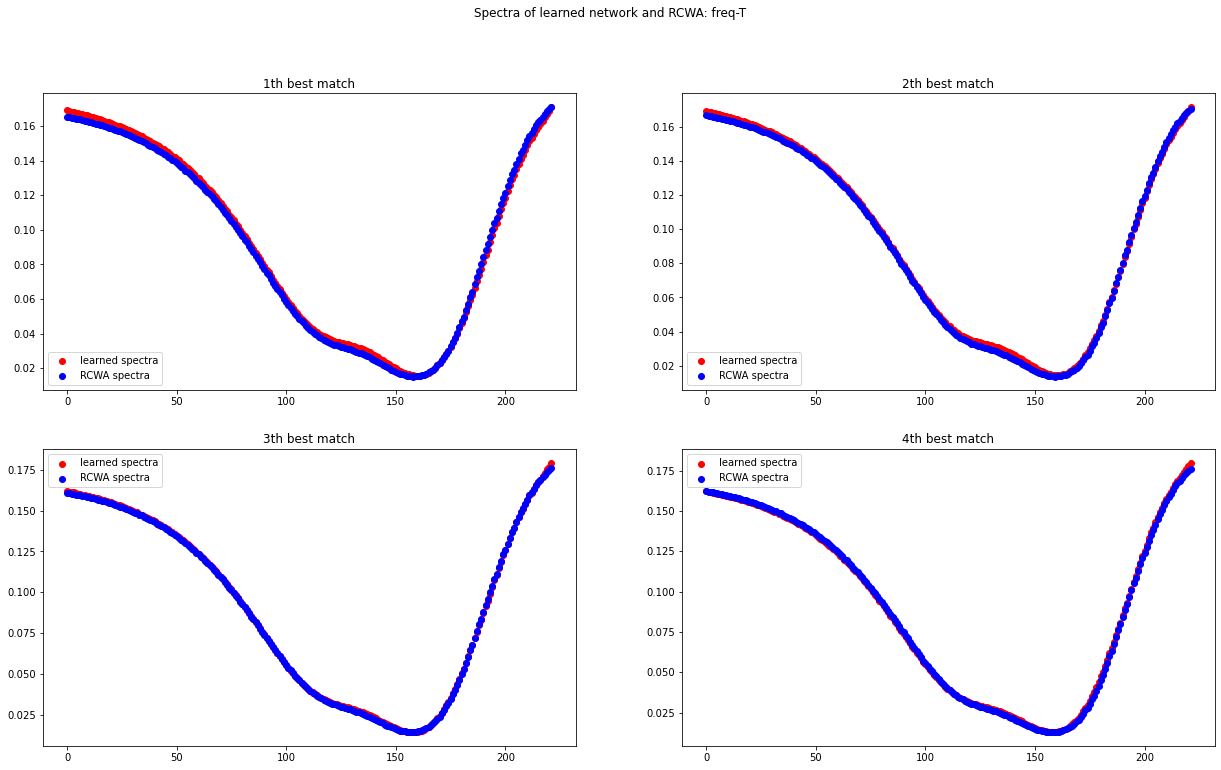

** Model saved.
**************************** ROUND 10 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 2000
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [130. 150.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 53. 133.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 81. 148.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [65. 50.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [121. 139.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [117. 131.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [114. 146.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 71. 116.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [132.  95.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [63. 82.]
Calculation 

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 99. 129.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [ 69. 104.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [111. 118.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 68. 106.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [150. 113.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 64. 107.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [57. 68.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [142.  70.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 76. 131.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 86. 102.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [101. 119.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 61. 140.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.8495655490402782e-05
### TEST LOSS  0.0001134478432504693
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.0078222865644194e-05
### TEST LOSS  7.421764909546861e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 5.401410442587462e-06
### TEST LOSS  2.4957172172435095e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.7819552583127063e-06
### TEST LOSS  2.3486052176243294e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.8109386716567145e-06
### TEST LOSS  1.1589200804943782e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 1.426159228145707e-06
### TEST LOSS  1.2907940363978316e-06
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.5646774501725247e-06
### TEST LOSS  6.724790845661724e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 8.311936032221467e-07
### TEST LOSS  1.115087053449315e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 8.49715922756289e-07
### TEST LOSS  7.013626240374531e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 7.59671084562541e-07
### TEST LOSS  9.267459745387896e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.226686879135968e-07
### TEST LOSS  4.2929334445792243e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 6.357553488385292e-07
### TEST LOSS  6.293236462321753e-07
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 4.26056959968335e-07
### TEST LOSS  1.0366647453944703e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 4.691099396278986e-07
### TEST LOSS  4.243054784562143e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 4.3723383101479383e-07
### TEST LOSS  3.7854250460137945e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 4.6842507850008985e-07
### TEST LOSS  5.036986522100051e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 5.174463485460023e-07
### TEST LOSS  9.177459446618741e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 4.831028939449311e-07
### TEST LOSS  5.02461368985981e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 3.969975551516569e-07
### TEST LOSS  3.2469835578770777e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 4.078053907754509e-07
### TEST LOSS  5.694414160946811e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 4.2271451821029873e-07
### TEST LOSS  4.5030262564675163e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 3.8394998618507257e-07
### TEST LOSS  4.703806439465552e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 3.9740272418420376e-07
### TEST LOSS  3.831517697487167e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 4.1185781410923993e-07
### TEST LOSS  3.363060064505892e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.755690668523215e-07
### TEST LOSS  4.560312352926606e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.4891463249285833e-07
### TEST LOSS  3.8507122894770874e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 3.8894866275462903e-07
### TEST LOSS  3.727998707366472e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 3.983265851239537e-07
### TEST LOSS  3.1681672680861083e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.383290629072945e-07
### TEST LOSS  2.7869829561192697e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.722695771484098e-07
### TEST LOSS  1.221796503614314e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.2225983573906945e-07
### TEST LOSS  4.4317829311542786e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.4525867235378767e-07
### TEST LOSS  2.7672722022013353e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.752461115187344e-07
### TEST LOSS  7.003451059972577e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.689488947280495e-07
### TEST LOSS  3.13806686828381e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.5294598570079217e-07
### TEST LOSS  6.472167295138813e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.4457487465088263e-07
### TEST LOSS  3.4848214530332674e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.504818243182939e-07
### TEST LOSS  3.710611053975299e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.190639314443189e-07
### TEST LOSS  2.978755162530433e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.5806262461690607e-07
### TEST LOSS  3.768994067362049e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.531108685823625e-07
### TEST LOSS  3.1632867016166224e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.505488313528815e-07
### TEST LOSS  3.9610036471534236e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.416265285665077e-07
### TEST LOSS  3.170138100472286e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.818393825145705e-07
### TEST LOSS  3.0106724674775857e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.664040281847747e-07
### TEST LOSS  3.430085124970598e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.59886823050104e-07
### TEST LOSS  3.2161306696328513e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.35991170022254e-07
### TEST LOSS  2.571721144780289e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.441304299585113e-07
### TEST LOSS  2.8592567247187617e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.307145293387492e-07
### TEST LOSS  3.2999681375637617e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.586526938628154e-07
### TEST LOSS  3.925484368968076e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.867422781738128e-07
### TEST LOSS  4.909090241274801e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.7601897703076757e-07
### TEST LOSS  3.458082758811543e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.4980738083945084e-07
### TEST LOSS  5.459026444517197e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.3095784244352445e-07
### TEST LOSS  4.0304084715595914e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.683403465668533e-07
### TEST LOSS  2.112216928177683e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.2811743738392353e-07
### TEST LOSS  2.412934155889464e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.173279121337913e-07
### TEST LOSS  4.2276170593898616e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.491996963518318e-07
### TEST LOSS  3.7635336222289574e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.494890201043432e-07
### TEST LOSS  3.133968907794345e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.5388155579951786e-07
### TEST LOSS  3.698832879687567e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.4737251695293736e-07
### TEST LOSS  2.6042032743589514e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.5000548705177434e-07
### TEST LOSS  1.5824914385120792e-06
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.340354861509411e-07
### TEST LOSS  3.3600627394510717e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.3865507290187225e-07
### TEST LOSS  2.5829494395187186e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.559821025831411e-07
### TEST LOSS  3.098412913497365e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.428386036663511e-07
### TEST LOSS  2.7192232892048197e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.291007135164392e-07
### TEST LOSS  4.039167379232822e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.1524599828802737e-07
### TEST LOSS  3.165963268732715e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.409832316352279e-07
### TEST LOSS  3.559833179641222e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.399229402649695e-07
### TEST LOSS  4.35848498151851e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 1.13793284174335e-06
### TEST LOSS  5.723086928810517e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 5.5407597155223695e-06
### TEST LOSS  9.788440987297994e-06
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 1.7432846820142344e-06
### TEST LOSS  1.5941721377051483e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.1196523002563483e-07
### TEST LOSS  2.8000470422284705e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.184761042440698e-07
### TEST LOSS  3.5084566718524e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.222783883511937e-07
### TEST LOSS  2.639230307484771e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.3716739899070094e-07
### TEST LOSS  3.2884782209900245e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.325182576157104e-07
### TEST LOSS  3.860159163574887e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.2125442031638585e-07
### TEST LOSS  2.531905754684279e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.219379372012554e-07
### TEST LOSS  3.093164072727935e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.961280592730375e-07
### TEST LOSS  2.534365857324398e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.2789400210386786e-07
### TEST LOSS  5.033475256747503e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.6834931098184144e-07
### TEST LOSS  3.0676687051330495e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.1246682890007095e-07
### TEST LOSS  2.6694412345780925e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.537252467324947e-07
### TEST LOSS  4.4716486134651254e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.100228683470263e-07
### TEST LOSS  2.505211725178924e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.1987375611919335e-07
### TEST LOSS  2.27568854427318e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.116308975048554e-07
### TEST LOSS  2.5851375085039763e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.117283299767237e-07
### TEST LOSS  3.0224725880619495e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.0485883973341286e-07
### TEST LOSS  3.7798570057627027e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.1614223953191355e-07
### TEST LOSS  2.6061222323884674e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.2955787265898094e-07
### TEST LOSS  3.183747746030955e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.949472424571553e-07
### TEST LOSS  2.320144962671596e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.0691692057160933e-07
### TEST LOSS  3.756176302734578e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.042460685360737e-07
### TEST LOSS  3.136660514731678e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.3069514313766035e-07
### TEST LOSS  2.9862456282595907e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 6.89269736676934e-07
### TEST LOSS  3.4929238476403647e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.373460360860392e-07
### TEST LOSS  4.305525777681396e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.009972559322449e-07
### TEST LOSS  2.1931649124932543e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.016070975547791e-07
### TEST LOSS  2.310645134192176e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.012034747804648e-07
### TEST LOSS  2.776608023206487e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.9147658213624086e-07
### TEST LOSS  2.2503835737097688e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.905657703795583e-07
### TEST LOSS  2.944381643980402e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.093998472287751e-07
### TEST LOSS  4.083258952884231e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.543924030926405e-07
### TEST LOSS  3.601315810897177e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 5.22308121636783e-07
### TEST LOSS  2.885768073686753e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.264916325083078e-07
### TEST LOSS  2.7923063707172937e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.6569857581003615e-07
### TEST LOSS  5.658792730400819e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.124941352794508e-07
### TEST LOSS  2.3204484117892813e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.081168084229091e-07
### TEST LOSS  4.45133530035946e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.313322087681314e-07
### TEST LOSS  3.434421766238908e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.2600358898893233e-07
### TEST LOSS  7.020931832357747e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 8.082411182428472e-07
### TEST LOSS  2.7998568773076236e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.07737116408191e-07
### TEST LOSS  4.2237063269112696e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.957283934463817e-07
### TEST LOSS  2.7292760194086443e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.9742037699964643e-07
### TEST LOSS  2.3757369499814255e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.1731329465145565e-07
### TEST LOSS  2.1585909356266106e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.1816202286094606e-07
### TEST LOSS  2.543698116141968e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.856862041227259e-07
### TEST LOSS  4.2060008145957305e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.079471452522853e-07
### TEST LOSS  2.152184355471339e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.937550707091674e-07
### TEST LOSS  2.829909457583805e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.931060808837316e-07
### TEST LOSS  2.329459457920772e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.907835968146699e-07
### TEST LOSS  5.328185295638832e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 4.524526110900595e-07
### TEST LOSS  8.306051502889508e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.3985807790237743e-07
### TEST LOSS  3.0002089014639446e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.879692635611164e-07
### TEST LOSS  3.719433346797511e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.046038505276627e-07
### TEST LOSS  2.21952907963896e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.24377129514275e-07
### TEST LOSS  3.098670376289192e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.817773468848372e-07
### TEST LOSS  2.945469115426628e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.180872664092504e-07
### TEST LOSS  3.9817936586435584e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.0163620743905995e-07
### TEST LOSS  2.1049468301725938e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.0972094797476757e-07
### TEST LOSS  2.464080959422669e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.961884622889599e-07
### TEST LOSS  3.34726646163593e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.821876317034011e-07
### TEST LOSS  3.0505346918137853e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.831039110740008e-07
### TEST LOSS  3.118229789341361e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.805092097286632e-07
### TEST LOSS  3.153614827056117e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.4227600521319346e-07
### TEST LOSS  3.3596156328030703e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.9825957168760907e-07
### TEST LOSS  3.296797913776572e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.85750669855922e-07
### TEST LOSS  3.6708426023324135e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.9964012999350585e-07
### TEST LOSS  2.4030479484811924e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.895657919221861e-07
### TEST LOSS  3.6420180625403495e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.8754069635716915e-07
### TEST LOSS  3.226019960796596e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.6659133951589806e-07
### TEST LOSS  3.0326230084180375e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.847581703608881e-07
### TEST LOSS  1.630035924904405e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.1877018024850656e-07
### TEST LOSS  3.000760808428519e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.743508504927661e-07
### TEST LOSS  3.272760807249142e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.906484820561772e-07
### TEST LOSS  2.772330631728437e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.2175288170144254e-07
### TEST LOSS  2.9003228974033846e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.952423348014932e-07
### TEST LOSS  2.5938124347627915e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.69529089487186e-07
### TEST LOSS  1.9207107442298367e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.9571359075575286e-07
### TEST LOSS  3.219099208232971e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.770908596745336e-07
### TEST LOSS  3.016802817038903e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.826346418594028e-07
### TEST LOSS  2.11796325307508e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.794335249287627e-07
### TEST LOSS  2.793736977461473e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.9939184611826873e-07
### TEST LOSS  2.5340417598348115e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.751357928048037e-07
### TEST LOSS  2.5430208457540476e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.2562061739227487e-07
### TEST LOSS  3.3257577503794284e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.002939584044739e-07
### TEST LOSS  3.0440683550144363e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.7945107053817254e-07
### TEST LOSS  2.8712876485315066e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.9443156213115884e-07
### TEST LOSS  2.4367569579908376e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.7194651522766123e-07
### TEST LOSS  2.6185827977087684e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.897248656541507e-07
### TEST LOSS  2.7881731530972803e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.7864686068745926e-07
### TEST LOSS  2.1711374339853743e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.6903935664090994e-07
### TEST LOSS  2.5752419077207376e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.692784397746451e-07
### TEST LOSS  3.4480088212755314e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.811646030380643e-07
### TEST LOSS  2.5233661157623523e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.8460632337612425e-07
### TEST LOSS  2.0677033158259898e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.999935732539427e-07
### TEST LOSS  2.481067757760987e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.9215653205261203e-07
### TEST LOSS  2.0062845228115595e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.75258236635878e-07
### TEST LOSS  2.7337384220042317e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.6977707969777496e-07
### TEST LOSS  2.4363372593446303e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.7696339380245407e-07
### TEST LOSS  3.058869059676302e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.8312237621186396e-07
### TEST LOSS  3.0581071257529403e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.735617959945813e-07
### TEST LOSS  2.733921301493562e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.845847028059012e-07
### TEST LOSS  2.9380301782566674e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 3.185879816962611e-07
### TEST LOSS  3.5940036013926147e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.7995800335212095e-07
### TEST LOSS  3.367317579735148e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.9483361109683415e-07
### TEST LOSS  2.4527018780418077e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.1868595385109446e-07
### TEST LOSS  2.6381895139593326e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.6655465821257e-07
### TEST LOSS  2.628738007122896e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.025901258562058e-07
### TEST LOSS  2.72755799812785e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.9840653785484505e-07
### TEST LOSS  2.797167179361774e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.900165086980877e-07
### TEST LOSS  2.5589178183812084e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.774279757700171e-07
### TEST LOSS  2.0538649986671468e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.7990868062310883e-07
### TEST LOSS  3.4110185206751943e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.8395632903155386e-07
### TEST LOSS  2.110139670700543e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.7812116607872636e-07
### TEST LOSS  2.626436459725786e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.68849388254111e-07
### TEST LOSS  1.9260494733922922e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.586520365328582e-07
### TEST LOSS  2.931215969207794e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.7321155462267655e-07
### TEST LOSS  2.6362739333762877e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.7181888499150377e-07
### TEST LOSS  1.7786384537051466e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.7995942569702945e-07
### TEST LOSS  2.687703907137499e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.765697860951377e-07
### TEST LOSS  2.419364188691967e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.724040394355143e-07
### TEST LOSS  2.0805484979291577e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.8790718019511275e-07
### TEST LOSS  2.3946513654967324e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.9517430313319435e-07
### TEST LOSS  2.3599791726762002e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.8353296709671127e-07
### TEST LOSS  2.07958585463075e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.889463560169503e-07
### TEST LOSS  2.912481567326116e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.844031495197186e-07
### TEST LOSS  2.2449923164913343e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.855394422534019e-07
### TEST LOSS  1.873016335215046e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.9279777112378724e-07
### TEST LOSS  2.2496772705456655e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.1626230199233164e-07
### TEST LOSS  2.2743629320605882e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.595280908188613e-07
### TEST LOSS  2.2526811183828006e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.7742140848818763e-07
### TEST LOSS  2.434976228945137e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.746973460201474e-07
### TEST LOSS  2.569438947830349e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.7997421227965446e-07
### TEST LOSS  2.0671953867198076e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.648031420235952e-07
### TEST LOSS  2.761844299925542e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.7174616307767963e-07
### TEST LOSS  2.8859211672245994e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.8047399302533195e-07
### TEST LOSS  2.4467673019519984e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.676125974527821e-07
### TEST LOSS  2.8705672245147676e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.6765265547279424e-07
### TEST LOSS  2.2298829236433448e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.7159875206095307e-07
### TEST LOSS  2.5706797212402914e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.6930674423297775e-07
### TEST LOSS  3.3140110341870844e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.783351794395372e-07
### TEST LOSS  2.0291278891212035e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.604856289210034e-07
### TEST LOSS  2.087255722926784e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.912765544973439e-07
### TEST LOSS  2.7386113525077843e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.8073492402747036e-07
### TEST LOSS  2.798138282855689e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.5962134626400514e-07
### TEST LOSS  4.5672793191897654e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.5954158190000244e-07
### TEST LOSS  2.3266592421578026e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.648453321327793e-07
### TEST LOSS  3.0658286362950096e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.797906925096072e-07
### TEST LOSS  3.087578761551413e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.4450979226564583e-07
### TEST LOSS  1.9548993606122168e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.4511729505150013e-07
### TEST LOSS  2.358248963219012e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.7481391133754587e-07
### TEST LOSS  2.189085572960418e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.7204798744673297e-07
### TEST LOSS  2.747964624442526e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.6527934731657154e-07
### TEST LOSS  2.6221380409197084e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.6598413105638487e-07
### TEST LOSS  2.1770269332440269e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.899647093546065e-07
### TEST LOSS  2.7422041976403003e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.3869220710869284e-07
### TEST LOSS  2.5711536390341885e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.667753546523599e-07
### TEST LOSS  2.874349860348957e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.844542717692633e-07
### TEST LOSS  2.6093257948408185e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.5742706959519523e-07
### TEST LOSS  1.8349152621037018e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.702464386734604e-07
### TEST LOSS  2.2775437381975888e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.637763040373997e-07
### TEST LOSS  3.111754570757815e-07
** loss_train 2.637763040373997e-07
** loss_test 3.111754570757815e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


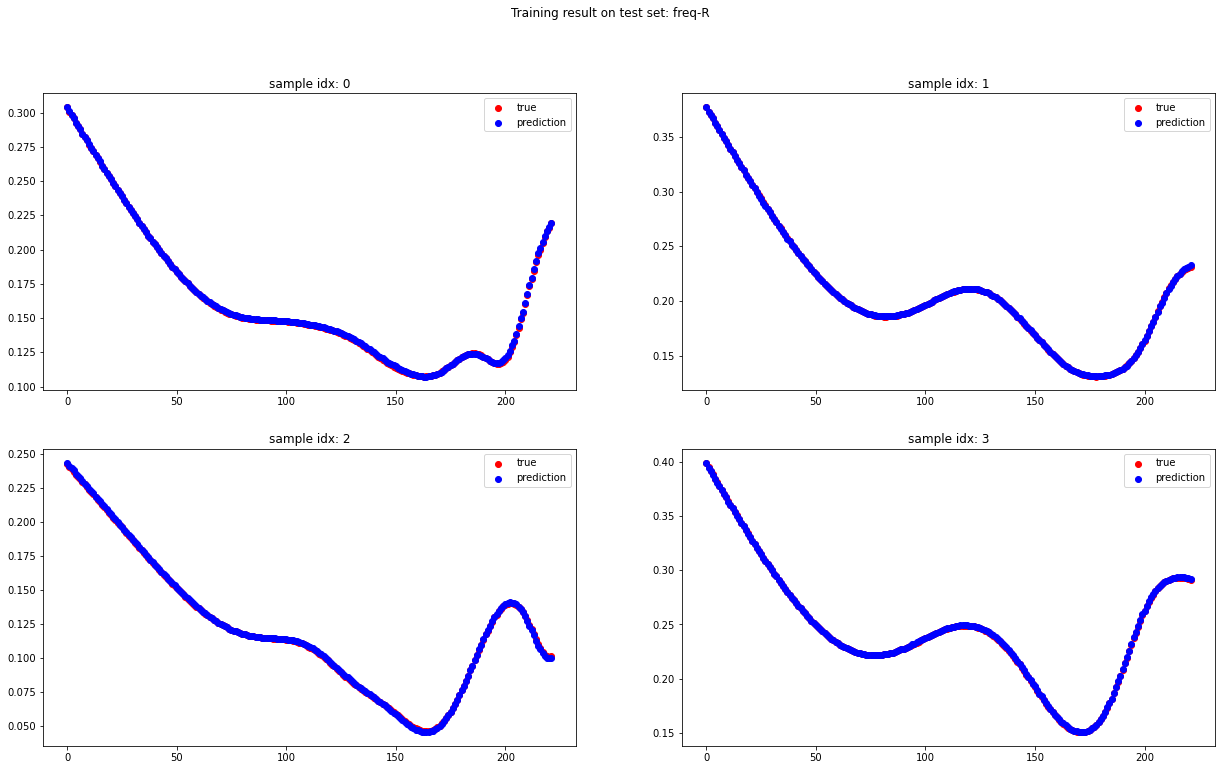

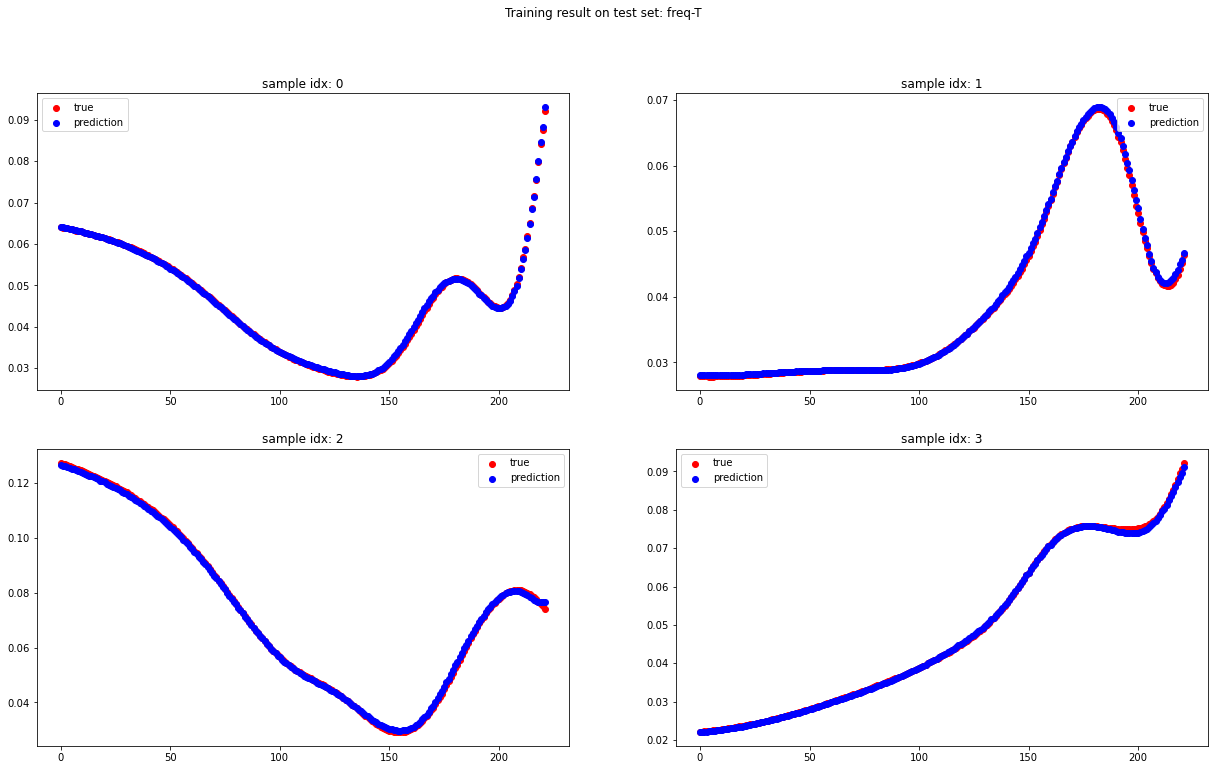

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [145. 122. 160.  75.]
 [146. 123. 160.  75.]
 [145. 121. 160.  75.]
 [145. 123. 160.  75.]
 [146. 121. 160.  75.]
 [146. 120. 160.  75.]
 [147. 123. 160.  75.]
 [145. 120. 160.  75.]
 [147. 122. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


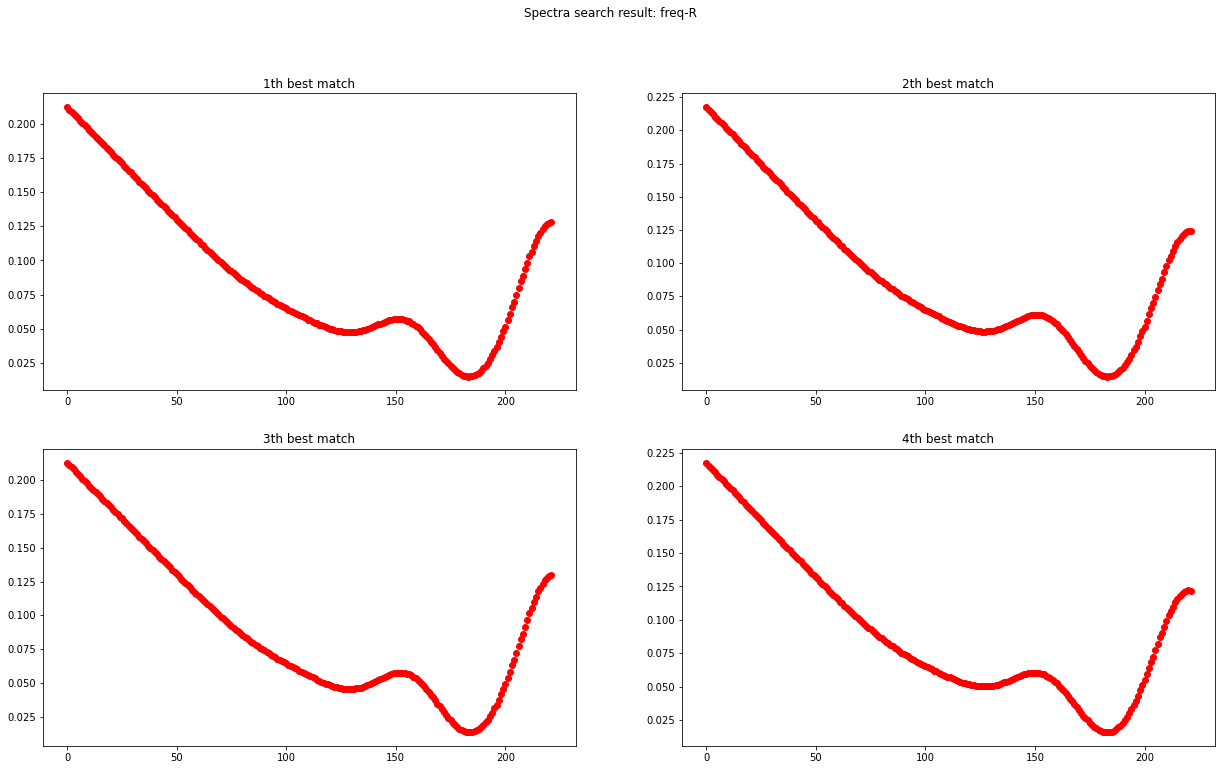

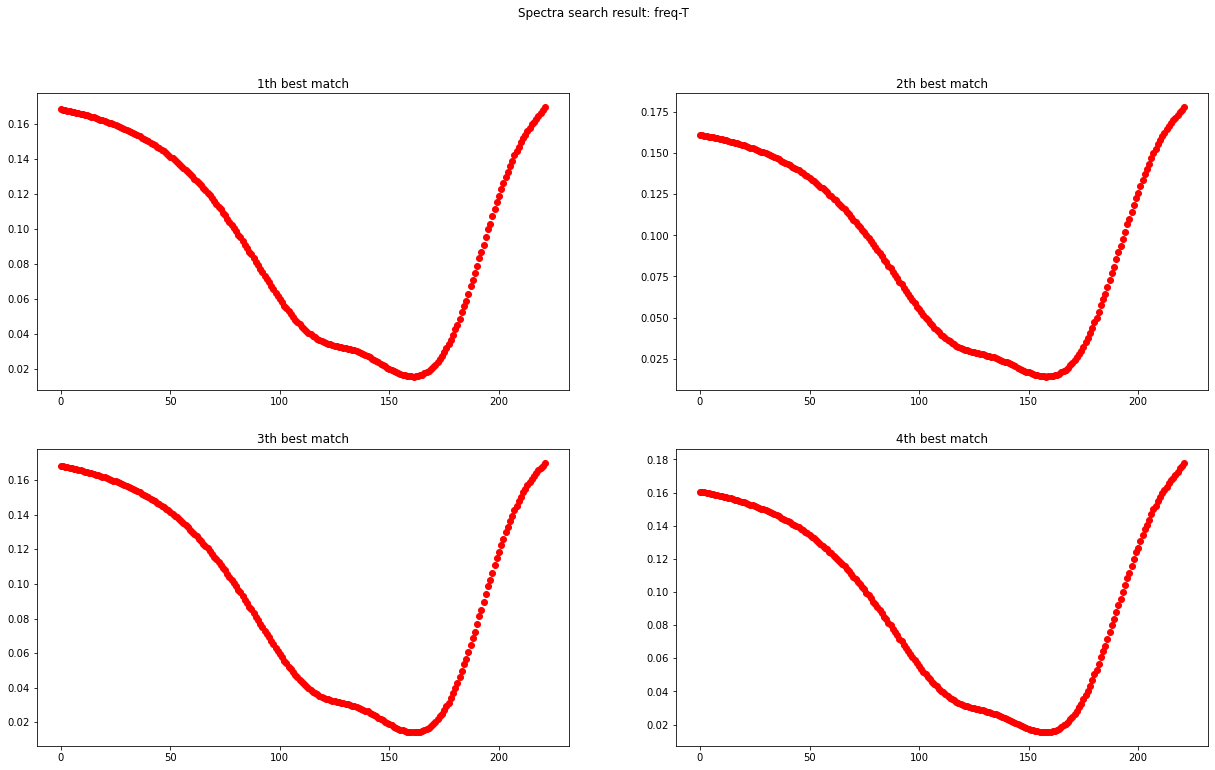

*** Reruning RCWA on picked params
params_dict.shape: (2017, 4)
R_dict.shape: (2017, 222)
T_dict.shape: (2017, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
---------

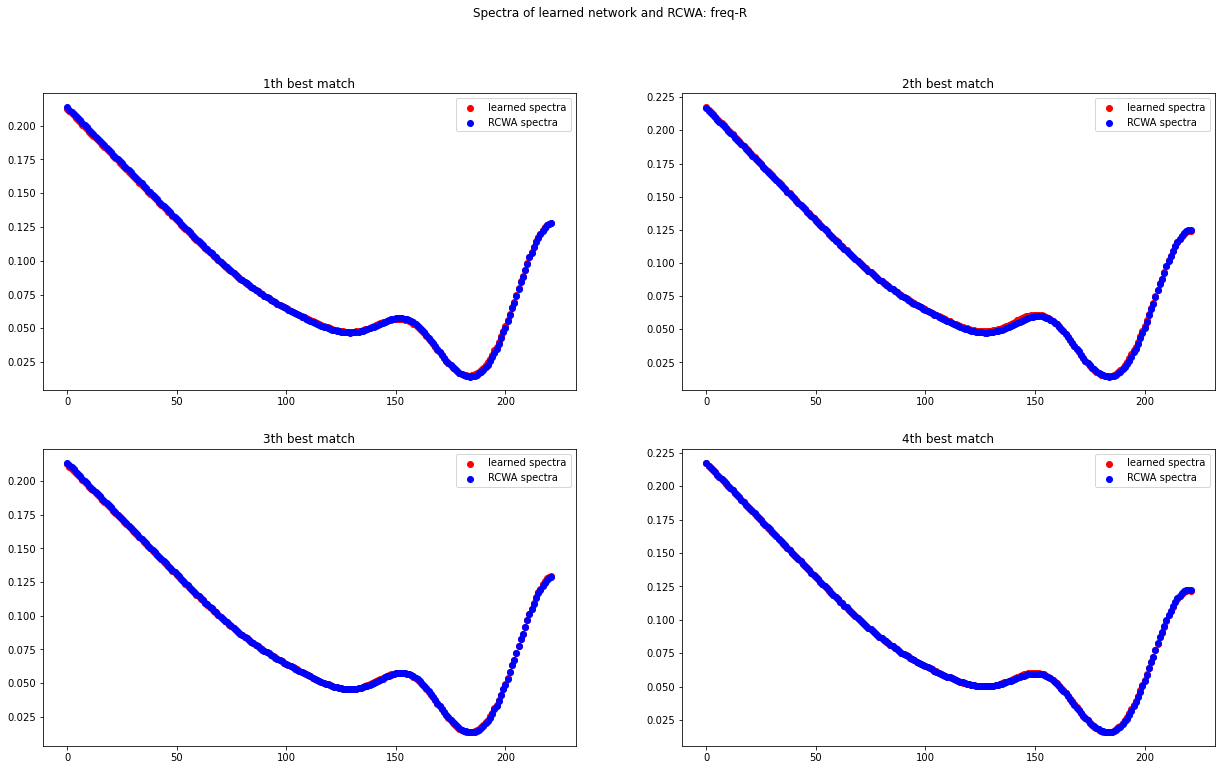

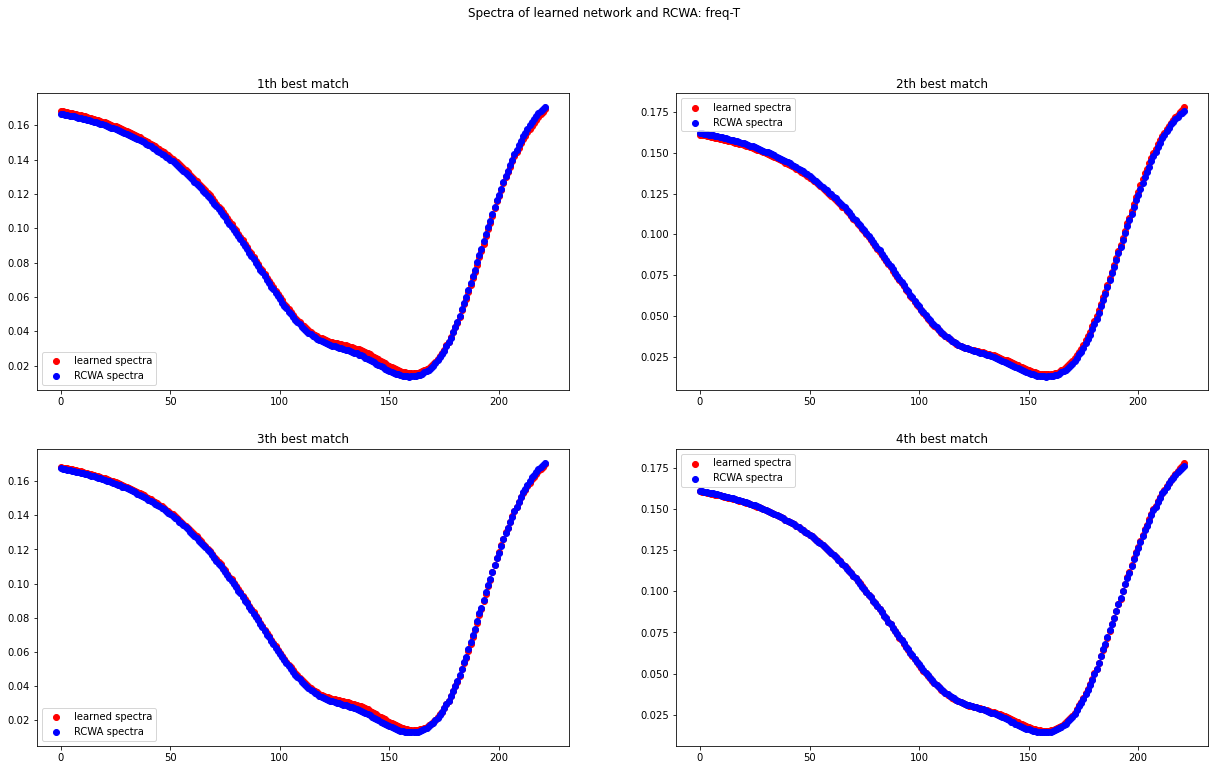

** Model saved.
**************************** ROUND 11 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 2200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [143.  88.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [134. 128.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [142. 104.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [109. 108.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [132.  93.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [70. 65.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [73. 83.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [109.  63.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [107.  56.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [136.  56.]
Calculation 

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 62. 145.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [ 57. 105.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [109. 117.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [115.  58.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [73. 67.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [98. 97.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [120.  84.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [97. 70.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [142. 121.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 75. 135.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 87. 134.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [65. 99.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.1043870546603474e-05
### TEST LOSS  7.334881163181059e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.212891490695256e-05
### TEST LOSS  3.8028199400507603e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 2.508966601811577e-06
### TEST LOSS  3.2855390545040737e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 7.145934913081414e-06
### TEST LOSS  2.450981810397934e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.7216422698117526e-06
### TEST LOSS  1.6462002084457101e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 1.7054053513990394e-06
### TEST LOSS  7.702403048838415e-07
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 6.886663278506753e-07
### TEST LOSS  6.83599974095297e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 7.0413449599985e-07
### TEST LOSS  6.967818182367795e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 6.769250577983014e-07
### TEST LOSS  5.63185346546754e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 7.554939180355223e-07
### TEST LOSS  6.668449965686842e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.92965876722204e-07
### TEST LOSS  8.4556945074093e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 6.920411365724471e-07
### TEST LOSS  9.424688214769985e-07
----------------------------------------------------------------------
*** EP

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 5.808888141329243e-07
### TEST LOSS  7.344847531523114e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 5.699057390241468e-07
### TEST LOSS  5.079183989492417e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 6.745280951973727e-07
### TEST LOSS  7.359984072701825e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.621362762873869e-07
### TEST LOSS  4.220088419859883e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 5.440788734648292e-07
### TEST LOSS  4.494977586642618e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 5.784431898237973e-07
### TEST LOSS  6.103888372790882e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 5.163803488337428e-07
### TEST LOSS  6.938546207355544e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 5.011023722658401e-07
### TEST LOSS  3.237211728040193e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.632453075192374e-07
### TEST LOSS  4.65461112346957e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.627855152826297e-07
### TEST LOSS  5.845717665083199e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.5603613609113413e-06
### TEST LOSS  1.1350578058061893e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 2.1678753955098078e-06
### TEST LOSS  7.077799587091939e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.599276306342533e-07
### TEST LOSS  3.8604795115519885e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.183462581567513e-07
### TEST LOSS  4.3934301347138843e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.312229488730294e-07
### TEST LOSS  3.9639293318445695e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 4.4091275212210237e-07
### TEST LOSS  3.306024006743621e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.60535139388918e-07
### TEST LOSS  1.281705465316918e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.6444349341615265e-07
### TEST LOSS  3.8282303194137057e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.2842191392722386e-07
### TEST LOSS  3.0385603732804267e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.262544891108818e-07
### TEST LOSS  4.6451557977889024e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.6814095892729185e-07
### TEST LOSS  5.269827557764405e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.1791400899665e-07
### TEST LOSS  4.1736547104571375e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.085000413500169e-07
### TEST LOSS  4.6421589352328074e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.6355281919975186e-07
### TEST LOSS  3.9829308034864935e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 5.166604807901624e-07
### TEST LOSS  6.181083191139888e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.495303951102476e-07
### TEST LOSS  4.1821179892890953e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.943724279274616e-07
### TEST LOSS  3.3975616211343795e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.4796371771773446e-07
### TEST LOSS  3.390898543233506e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.577873109099719e-07
### TEST LOSS  3.821208331304881e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.4733431785298257e-07
### TEST LOSS  1.0343250750972375e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.069096584884009e-07
### TEST LOSS  3.108064156480616e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.1688737897984463e-07
### TEST LOSS  3.785861672371759e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.591280792774135e-07
### TEST LOSS  4.3120361552114034e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.134433743242415e-07
### TEST LOSS  3.9807181734073366e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.1948344501592644e-07
### TEST LOSS  3.063300106236277e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.010349863634779e-07
### TEST LOSS  4.120843798180872e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.8124337871052333e-07
### TEST LOSS  2.48135127852341e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.966229361328611e-07
### TEST LOSS  4.213505435197448e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 8.081795477369011e-07
### TEST LOSS  3.63067519429299e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.992602205675858e-07
### TEST LOSS  6.157770361493352e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.1871755376893757e-07
### TEST LOSS  4.207577407297239e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.002929899775283e-07
### TEST LOSS  4.5823835500524374e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.2025243803791375e-07
### TEST LOSS  3.40820008659648e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.9576730726328693e-07
### TEST LOSS  3.7481499827084586e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.051305860773947e-07
### TEST LOSS  2.2520745327862338e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.0496823379466593e-07
### TEST LOSS  2.6968509924892825e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.554178241892001e-07
### TEST LOSS  3.358281785184855e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 1.2222244225041318e-06
### TEST LOSS  5.105641819089656e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.645389508046605e-07
### TEST LOSS  5.150147804518687e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.1052095286789575e-07
### TEST LOSS  4.976068770233586e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.105616288928683e-07
### TEST LOSS  4.1843407822825335e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.8671302343796686e-07
### TEST LOSS  2.80299193095192e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.31566956453431e-07
### TEST LOSS  7.630251120231564e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.9655687289071166e-07
### TEST LOSS  8.573846447358268e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 5.656919500974698e-07
### TEST LOSS  3.7023342732330394e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.3539717820935534e-07
### TEST LOSS  6.098248721889721e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 5.807126057517048e-07
### TEST LOSS  1.406889232453757e-06
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.5188333574909155e-07
### TEST LOSS  3.1674568519561447e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.279636194614124e-07
### TEST LOSS  3.3584823950839177e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.5050217109735257e-07
### TEST LOSS  4.759017618501578e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.287024327919265e-07
### TEST LOSS  7.574824523585861e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.172049464576136e-07
### TEST LOSS  3.0148896798616054e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.8960468283797603e-07
### TEST LOSS  3.6992481665093335e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.780415861380378e-07
### TEST LOSS  3.2070773307058326e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.1160176640434283e-07
### TEST LOSS  3.288326876248572e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.722327741614084e-07
### TEST LOSS  5.183252197281091e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.105655511937362e-07
### TEST LOSS  4.3852344936457294e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.3723754377596307e-07
### TEST LOSS  3.4682032760842546e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.837225091629648e-07
### TEST LOSS  3.8555179509620013e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.6162845905780873e-07
### TEST LOSS  2.8134633585826424e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.025875344495298e-07
### TEST LOSS  4.3101195846054796e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.5511812907820037e-07
### TEST LOSS  3.6113797861934005e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.136789519212672e-07
### TEST LOSS  2.824652804719969e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.880533025305252e-07
### TEST LOSS  3.6391331935771054e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.4270010684748927e-07
### TEST LOSS  7.98189770386781e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.786155568603016e-07
### TEST LOSS  2.93387954846394e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.5435471247392445e-07
### TEST LOSS  3.569291924109028e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.6653710445477826e-07
### TEST LOSS  5.089742378941358e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.17630967681873e-06
### TEST LOSS  9.778358906425473e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 5.832498168297077e-07
### TEST LOSS  3.913071972847044e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.6960464323211216e-07
### TEST LOSS  2.8390314551788004e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.7682749442360185e-07
### TEST LOSS  3.330691311709939e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.8042148841974857e-07
### TEST LOSS  3.7267926355718484e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.5843920749814824e-07
### TEST LOSS  3.350092547613961e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.8921272127012685e-07
### TEST LOSS  3.765573692052468e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 6.441197030552943e-07
### TEST LOSS  4.262243404548027e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 5.534350390234977e-07
### TEST LOSS  4.760814929892204e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.9006671929959164e-07
### TEST LOSS  6.847651014030623e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.5818768982438926e-07
### TEST LOSS  4.263505306915139e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.320082954516579e-07
### TEST LOSS  2.8998010748182423e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.4353400991287747e-07
### TEST LOSS  3.402023037152145e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.5875028745670856e-07
### TEST LOSS  4.376958858384486e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.4448463513101694e-07
### TEST LOSS  4.1364363786063524e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.429939535528413e-07
### TEST LOSS  4.3206733060039615e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.5711013401334475e-07
### TEST LOSS  2.592095155891498e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.646058379399878e-07
### TEST LOSS  2.5425008145978634e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 4.6347708042046325e-07
### TEST LOSS  3.490657477276259e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.279371999521562e-07
### TEST LOSS  3.252691017809356e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.274812325315679e-07
### TEST LOSS  4.583987731621164e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.4898862800180164e-07
### TEST LOSS  2.782526904914476e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.5581141748589316e-07
### TEST LOSS  3.175819134674274e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.7480749203844255e-07
### TEST LOSS  2.546801768534296e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.6850528896630923e-07
### TEST LOSS  2.8365791310437943e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.521774985399356e-07
### TEST LOSS  3.404531429568482e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.538790239397051e-07
### TEST LOSS  2.680212661103228e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.2261499776046906e-07
### TEST LOSS  2.913512396458607e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.518582362651366e-07
### TEST LOSS  3.261306473363716e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.539667513731036e-07
### TEST LOSS  3.9094011109834054e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.270891484411206e-07
### TEST LOSS  9.319362268825264e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.535014850490499e-07
### TEST LOSS  2.8370521974783047e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.4187311133784056e-07
### TEST LOSS  2.886737966243593e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.1537971309896826e-07
### TEST LOSS  2.7323020064655296e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.445253167943075e-07
### TEST LOSS  3.337366486062599e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.553133050198715e-07
### TEST LOSS  3.2599399403490237e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.778524783484081e-07
### TEST LOSS  2.540656792558421e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.9614471469949887e-07
### TEST LOSS  3.066233394595959e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.347525471591501e-07
### TEST LOSS  3.284978256281399e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.3353974489245464e-07
### TEST LOSS  2.816086079478323e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.532650287625798e-07
### TEST LOSS  2.1587692818532864e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 4.372201818935263e-07
### TEST LOSS  2.9553540145750023e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.320074480212492e-07
### TEST LOSS  4.658599395539072e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.564014133110179e-07
### TEST LOSS  3.3098148771221697e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.267010793014694e-07
### TEST LOSS  3.266814923625299e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.566105173582266e-07
### TEST LOSS  4.846993307995889e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 4.656918827143515e-07
### TEST LOSS  4.2438258267821133e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.368457134959742e-07
### TEST LOSS  3.866168090856566e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.325732060515724e-07
### TEST LOSS  3.5938178784404457e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.2944262932685125e-07
### TEST LOSS  6.299033397240374e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.989110088747925e-07
### TEST LOSS  2.5504347089474433e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.1175259047893693e-07
### TEST LOSS  3.3411940979600663e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.326453591689926e-07
### TEST LOSS  4.986746100230173e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.418652302933367e-07
### TEST LOSS  5.519378408859087e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.4775575321852803e-07
### TEST LOSS  2.5335807386068843e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.085272267904832e-07
### TEST LOSS  7.608565398999362e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.403138808234406e-07
### TEST LOSS  2.806142076954557e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.873498282367584e-07
### TEST LOSS  2.538285405700497e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.282578412805942e-07
### TEST LOSS  4.4089121374644025e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.5286394493541905e-07
### TEST LOSS  2.564919101084315e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.3646220669067166e-07
### TEST LOSS  3.1595988780213013e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.23697975867661e-07
### TEST LOSS  2.2069556590312542e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.0726250703206793e-07
### TEST LOSS  2.0996596709100038e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.2740191565526865e-07
### TEST LOSS  2.44942812645549e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.517655276276021e-07
### TEST LOSS  2.5569225670096785e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.183742620972329e-07
### TEST LOSS  2.3801220679202248e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.2499185329306424e-07
### TEST LOSS  4.1801038805439905e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.5339712827532243e-07
### TEST LOSS  3.0865728095966805e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.2495854256515084e-07
### TEST LOSS  3.2338678191866743e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.0594642609087103e-07
### TEST LOSS  2.6037334927850403e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.1488228872333936e-07
### TEST LOSS  3.627108812355745e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.240042284884998e-07
### TEST LOSS  3.532883705716041e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.158948582311764e-07
### TEST LOSS  2.7474074560166517e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.9946323804465955e-07
### TEST LOSS  3.3661325201964326e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.1675514377741107e-07
### TEST LOSS  2.5846532111879217e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.195308262378531e-07
### TEST LOSS  2.5910341691721417e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.1882366929797906e-07
### TEST LOSS  2.6933680541071336e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.4998827478008565e-07
### TEST LOSS  3.931734399333381e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 3.273597207854483e-07
### TEST LOSS  3.096361672650153e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.931921495323438e-07
### TEST LOSS  2.556448475671101e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.3799579787279814e-07
### TEST LOSS  3.535396684362764e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.0293931603092066e-07
### TEST LOSS  2.1730406618906162e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.127568224266368e-07
### TEST LOSS  2.813538943104449e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.326129157957522e-07
### TEST LOSS  4.6297060493722686e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 3.4486864777411533e-07
### TEST LOSS  2.7114011765771656e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.5311790019062787e-07
### TEST LOSS  4.1630125028032955e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.2676831979827625e-07
### TEST LOSS  3.879000053419793e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.296701662236501e-07
### TEST LOSS  3.149968005221705e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.1125562736019935e-07
### TEST LOSS  5.642756455224365e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.277925522966867e-07
### TEST LOSS  3.4728607846718107e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.966281542074708e-07
### TEST LOSS  2.6589326296289073e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.382210978098886e-07
### TEST LOSS  3.3438450941503106e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.417866546778276e-07
### TEST LOSS  4.163509895637286e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.059916811309904e-07
### TEST LOSS  3.202095827549728e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.05666733364518e-07
### TEST LOSS  3.278942983797606e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.268485183692927e-07
### TEST LOSS  3.495084968108131e-07
---------------------------------------------------------

KeyboardInterrupt: 

In [6]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define Target Spectra ======
tg_idx_freq_R = np.array([129])
tg_value_R = np.array([0.03])
tg_idx_freq_T = np.array([0, 167])
tg_value_T = np.array([0.23, 0.])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 200
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(params_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    # add param dict check here to save more time
    print('*** Reruning RCWA on picked params')
    if ROUND==1:
        params_dict = params_all
        R_dict = R_all
        T_dict = T_all
    else:
        params_dict = np.concatenate((params_dict, params), axis=0)
        R_dict = np.concatenate((R_dict, R), axis=0)
        T_dict = np.concatenate((T_dict, T), axis=0)
    print('params_dict.shape:', params_dict.shape)
    print('R_dict.shape:', R_dict.shape)
    print('T_dict.shape:', T_dict.shape)
    
    rerun_params, R_simu, T_simu = np.zeros_like(params_pick), np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(R_pick.shape[0]):  # for each in N_top
        print('--------------------')
        print(idx_pick+1, 'th match')
        if np.any(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the dict
            print('Already in the dict.')
            idx_same = np.argwhere(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)==True)[0].squeeze()  # get the idx in the dict
            print('# params_dict:', params_dict[idx_same], 'params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = params_dict[idx_same][np.newaxis,...], R_dict[idx_same][np.newaxis,...], T_dict[idx_same][np.newaxis,...]
        else:  # picked params not in the dict, call rcwa solver
            print('Not in the dict, calling RCWA...')
            params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
            print('# params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=params_pick_rcwa)
            # add unseen simu data into dict
            params_dict = np.concatenate((params_dict, rerun_params_i), axis=0)
            R_dict = np.concatenate((R_dict, R_simu_i), axis=0)
            T_dict = np.concatenate((T_dict, T_simu_i), axis=0)
        rerun_params[idx_pick], R_simu[idx_pick], T_simu[idx_pick] = rerun_params_i, R_simu_i, T_simu_i
    # save the dict
    path_dict = './data/' + path_material_name + '/data_dict_' + path_material_name + '.npz'
    np.savez(path_dict, params=params_dict, R=R_dict, T=T_dict)
    print('** Dict data saved.')
            
#     print('*** Reruning RCWA on picked params')
#     rerun_params, R_simu, T_simu = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
#                                            path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=param_pick)
    
    print('rerun_params.shape:', rerun_params.shape)
    print('R_simu.shape:', R_simu.shape)  # [N_top, N_freq]
    print('T_simu.shape:', T_simu.shape)
    # loss between learned spectra and simulated spectra
    loss_R = np.average(np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    loss_T = np.average(np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    loss_RT_avg = np.average([loss_R, loss_T])
    loss = loss_RT_avg
    
    print('*** Average Loss between Trained Spectra and RCWA Spectra:', loss_RT_avg)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
#     if ROUND>3:
#         loss = 1e-7
    ROUND += 1
    
plt.ioff()

In [9]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[1,2,2],[4,9,6]])
norm = np.linalg.norm(a-b, ord=2, axis=-1)

print(norm)
print(np.average(norm))

[1. 4.]
2.5


## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')